# Flatiron Health aNSCLC: Data Wrangling Training Set

**OBJECTIVE: Identify a training cohort and create a dataframe of relevant variables which can be used to build machine learning survival models.**

**BACKGROUND: There are three main sections to this notebook. First, the final cohort will then be split 80-20 into a training and test set. Given the rise of immunotherapy treatment in the past 5 years and increasing data missingness in the earlier years, the split will ensure the distribution of diagnosis years is the same in the training and test set.**

**After identifiying the final cohort in the training set, the second part of this notebook involves reading CSV files from Flatiron and preparing the dataframes so that each row corresponds to a unique patient from the training set and each column is a relevant variable for mortality prognositication. There are 10 CSV files from Flatiron that will be used. Flatiron files that won't be used are treatment, progression data, and visits. The eligibility window for collecting variables is -90 days and +30 days from index date, which is time of advanced diagnosis. Plus 30 was selected as the upper bound of the eligibility window given that median time to start of first line treatment is 32 days from time of advanced diagnosis.**

**Lastly, the processed dataframes for patients in the training set will be merged into a master dataframe which will be saved and later used for building machine learning survival models.** 

**Missing data will be handled in the machine learning building notebooks.** 

**OUTLINE:**
1. **Creating training and test cohort**
2. **File cleaning for patients in training set**
3. **Merge files to create master training dataframe**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import linregress 

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

## Part 1: Creating training and test cohort

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

**Patients will be split into a training and test set (80/20) stratified by advanced diagnosis year.**

In [5]:
enhanced_adv = pd.read_csv('Enhanced_AdvancedNSCLC.csv')

In [6]:
row_ID(enhanced_adv)

(68483, 68483)

In [7]:
enhanced_adv.loc[:, 'AdvancedDiagnosisDate'] = pd.to_datetime(enhanced_adv['AdvancedDiagnosisDate'])

In [8]:
enhanced_adv = enhanced_adv.rename(columns = {'AdvancedDiagnosisDate': 'adv_date'})

In [9]:
enhanced_adv['adv_date'].dt.year.value_counts()/len(enhanced_adv)

2017    0.114627
2016    0.112758
2018    0.112159
2015    0.111239
2014    0.106479
2019    0.104844
2013    0.097294
2020    0.085715
2012    0.083043
2011    0.065272
2021    0.006571
Name: adv_date, dtype: float64

In [10]:
enhanced_adv['adv_date'].dt.year.describe()

count    68483.000000
mean      2015.754581
std          2.712143
min       2011.000000
25%       2014.000000
50%       2016.000000
75%       2018.000000
max       2021.000000
Name: adv_date, dtype: float64

<AxesSubplot:xlabel='adv_date'>

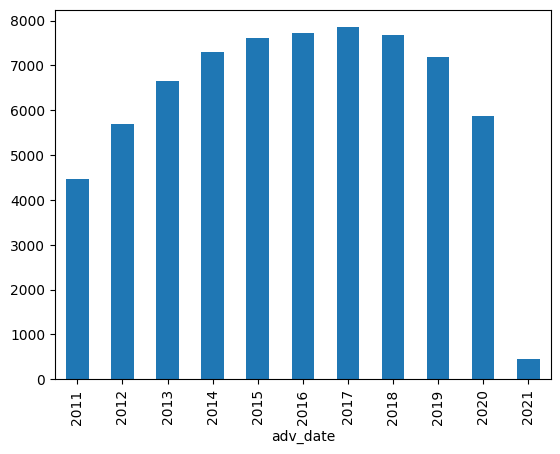

In [11]:
enhanced_adv.groupby([enhanced_adv['adv_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='adv_date'>

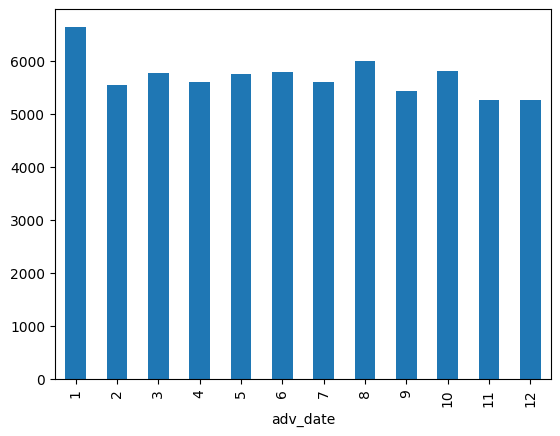

In [12]:
enhanced_adv.groupby([enhanced_adv['adv_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

In [13]:
enhanced_adv['adv_year_cat'] = pd.cut(enhanced_adv['adv_date'].dt.year,
                                      bins = [2010, 2012, 2014, 2016, 2018, 2021],
                                      labels = ['11-12', '13-14', '15-16', '17-18', '19-21'])

In [14]:
enhanced_adv['adv_year_cat'].value_counts(normalize = True, dropna = False)

17-18    0.226786
15-16    0.223997
13-14    0.203773
19-21    0.197129
11-12    0.148314
Name: adv_year_cat, dtype: float64

<AxesSubplot:xlabel='adv_year_cat'>

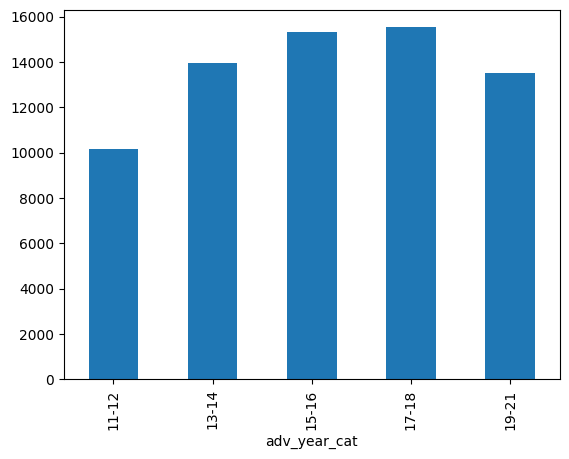

In [15]:
enhanced_adv.groupby([enhanced_adv['adv_year_cat']])['PatientID'].count().plot(kind = 'bar')

In [16]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in sss.split(enhanced_adv, enhanced_adv['adv_year_cat']):
    train_set = enhanced_adv.iloc[train_index]
    test_set = enhanced_adv.iloc[test_index]

In [17]:
train_set['adv_year_cat'].value_counts()/len(train_set)

17-18    0.226792
15-16    0.223999
13-14    0.203775
19-21    0.197131
11-12    0.148304
Name: adv_year_cat, dtype: float64

In [18]:
test_set['adv_year_cat'].value_counts()/len(test_set)

17-18    0.226765
15-16    0.223991
13-14    0.203767
19-21    0.197123
11-12    0.148354
Name: adv_year_cat, dtype: float64

In [19]:
row_ID(train_set)

(54786, 54786)

In [20]:
row_ID(test_set)

(13697, 13697)

In [21]:
# Array of PatientIDs in training set.
train_IDs = train_set['PatientID'].to_numpy()

In [22]:
pd.DataFrame(train_IDs, columns = ['PatientID']).to_csv('train_IDs.csv', index = False, header = True)

In [23]:
# Array of PatientIDs in test set.
test_IDs = test_set['PatientID'].to_numpy()

In [24]:
pd.DataFrame(test_IDs, columns = ['PatientID']).to_csv('test_IDs.csv', index = False, header = True)

In [25]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
enhanced_adv   DataFrame               PatientID Diag<...>n[68483 rows x 7 columns]
test_set       DataFrame               PatientID Diag<...>n[13697 rows x 7 columns]
train_set      DataFrame               PatientID Diag<...>n[54786 rows x 7 columns]


In [26]:
# Keep enhanced_adv.
del test_set
del train_set

## Part 2: File cleaning for patients in training set 

**The following 10 CSV files from Flatiron will be cleaned:**
1. **Demographics**
2. **Enhanced_AdvancedNSCLC**
3. **Enhanced_Mortality_V2**
4. **MedicationAdministration**
5. **Enhanced_AdvNSCLCBiomarkers**
6. **Insurance**
7. **ECOG**
8. **Vitals**
9. **Labs**
10. **Diagnosis**

### 1. Demographics 

In [27]:
demographics = pd.read_csv('Demographics.csv')

In [28]:
demographics.sample(5)

,PatientID,PracticeID,PracticeType,PrimaryPhysicianID,BirthYear,Gender,Race,Ethnicity,State
66451,FB6224B61E372,S0D3580DF32FE,COMMUNITY,TAA92B2ED6087,1936,M,Black or African American,NaN,OH
15003,F600F09ED9360,S9E5E89299301,COMMUNITY,T4A719418255E,1952,F,White,NaN,IL
64514,F4D05E22A5F86,SD3D2C8943B18,COMMUNITY,T9D3F2EC1C49B,1951,M,NaN,NaN,AL
10241,FDE4D7DD10DFA,S260DA7B3CE37,COMMUNITY,T454A2111FEA9,1936,M,NaN,NaN,PA
23701,FC7B54B376752,S507DCE5DD8C6,ACADEMIC,NaN,1953,F,White,NaN,NaN


In [29]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68483 entries, 0 to 68482
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PatientID           68483 non-null  object
 1   PracticeID          68483 non-null  object
 2   PracticeType        68483 non-null  object
 3   PrimaryPhysicianID  61093 non-null  object
 4   BirthYear           68483 non-null  int64 
 5   Gender              68478 non-null  object
 6   Race                60887 non-null  object
 7   Ethnicity           2217 non-null   object
 8   State               59646 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.7+ MB


In [30]:
demographics = demographics[demographics['PatientID'].isin(train_IDs)]

In [31]:
row_ID(demographics)

(54786, 54786)

#### 1.1 Race and Ethnicity

In [32]:
demographics['Race'].value_counts(normalize = True, dropna = False)*100

White                        68.119593
NaN                          11.150659
Other Race                    9.611945
Black or African American     8.432811
Asian                         2.555397
Hispanic or Latino            0.129595
Name: Race, dtype: float64

In [33]:
demographics['Ethnicity'].value_counts(normalize = True, dropna = False)*100

NaN                   96.716314
Hispanic or Latino     3.283686
Name: Ethnicity, dtype: float64

In [34]:
demographics.query('Ethnicity == "Hispanic or Latino"').sample(5)

,PatientID,PracticeID,PracticeType,PrimaryPhysicianID,BirthYear,Gender,Race,Ethnicity,State
28558,F2B724A6023F9,SBA0283E855FA,COMMUNITY,TBDA0EEDA17BB,1942,M,White,Hispanic or Latino,TX
3848,F7485DA2770D1,S87C279DB0C8A,COMMUNITY,T3218FF36DD43,1971,F,Hispanic or Latino,Hispanic or Latino,AZ
60269,F5ED64866392B,SD4C2AE2A1773,COMMUNITY,T4C9306A62086,1954,F,Other Race,Hispanic or Latino,NaN
44604,F9BFA3B41815A,S87C279DB0C8A,COMMUNITY,TBAF59120B45A,1936,F,Hispanic or Latino,Hispanic or Latino,AZ
20867,F815CB17D4697,S36B27BE0F013,COMMUNITY,TB08F0A5CD6AA,1937,M,Other Race,Hispanic or Latino,CA


In [35]:
demographics.query('Race == "Hispanic or Latino"').sample(5)

,PatientID,PracticeID,PracticeType,PrimaryPhysicianID,BirthYear,Gender,Race,Ethnicity,State
45200,F2D701311A6C2,S87C279DB0C8A,COMMUNITY,T5ECB7D3F7FDA,1944,F,Hispanic or Latino,Hispanic or Latino,AZ
7777,F260D048DA34D,S291CF564BD92,COMMUNITY,TEB895592FFB3,1962,M,Hispanic or Latino,Hispanic or Latino,TN
56222,FB242FF0F22B9,S291CF564BD92,COMMUNITY,TAFF77FFC82E6,1955,F,Hispanic or Latino,Hispanic or Latino,TN
25610,F7EDBD94B3D80,S291CF564BD92,COMMUNITY,TA9008DC0B38D,1957,F,Hispanic or Latino,Hispanic or Latino,TN
65023,FFD1CF5F58EA6,S87C279DB0C8A,COMMUNITY,T47837C490BF9,1962,M,Hispanic or Latino,Hispanic or Latino,AZ


**There are unexpected values where “Hispanic or Latino” appears as a race rather than ethnicity. Ethnicity will be recoded to align with the FDA standards for collecting race and ethnicity variables for clinical trials. Patients with a race value of “Hispanic or Latino” will have their race recoded as "Unknown" and ethnicity as “Hispanic or Latino.” Of note, ethnicity and race information is likely to be poorly captured since EHR platforms typically do not require documentation of race or ethnicity.**  

In [36]:
# If race value is 'Hispanic or Latino', code as unknown, otherwise value unchanged.
demographics['race'] = (
    np.where(demographics['Race'] == 'Hispanic or Latino', 'unknown', demographics['Race'])
)

In [37]:
# Missing race value will be recoded as Unknown
demographics['race'] = demographics['race'].fillna('unknown')

In [38]:
demographics['race'].value_counts().sum()

54786

In [39]:
demographics['race'].value_counts(normalize = True, dropna = False)*100

White                        68.119593
unknown                      11.280254
Other Race                    9.611945
Black or African American     8.432811
Asian                         2.555397
Name: race, dtype: float64

In [40]:
# If race value is equal to 'Hispanic or Latino', code ethnicity as 'Hispanic or Latino', otherwise unchanged. 
demographics['ethnicity'] = (
    np.where(demographics['Race'] == 'Hispanic or Latino', 'hispanic_latino', demographics['Ethnicity'])
)

In [41]:
demographics['ethnicity'] = demographics['ethnicity'].fillna('unknown')

In [42]:
demographics['ethnicity'] = demographics['ethnicity'].replace({'Hispanic or Latino': 'hispanic_latino'})

In [43]:
demographics['ethnicity'].value_counts(normalize = True, dropna = False)*100

unknown            96.692586
hispanic_latino     3.307414
Name: ethnicity, dtype: float64

In [44]:
(
    demographics
    .groupby(['ethnicity', 'race'])['PatientID'].count()
    .divide(len(demographics))
    .sort_values(ascending = False)
)

ethnicity        race                     
unknown          White                        0.669715
                 unknown                      0.107071
                 Black or African American    0.083708
                 Other Race                   0.081116
                 Asian                        0.025317
hispanic_latino  Other Race                   0.015004
                 White                        0.011481
                 unknown                      0.005731
                 Black or African American    0.000621
                 Asian                        0.000237
Name: PatientID, dtype: float64

In [45]:
demographics = demographics.drop(columns = ['Race', 'Ethnicity'])

#### 1.2 BirthYear

In [46]:
demographics['BirthYear'].describe()

count    54786.000000
mean      1947.392473
std          9.511752
min       1936.000000
25%       1939.000000
50%       1946.000000
75%       1954.000000
max       2001.000000
Name: BirthYear, dtype: float64

array([[<AxesSubplot:title={'center':'BirthYear'}>]], dtype=object)

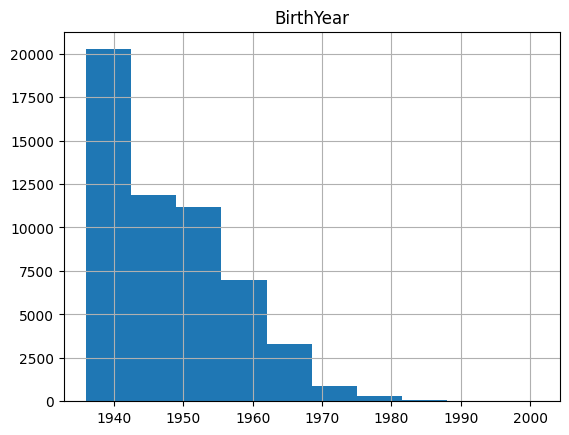

In [47]:
demographics.hist(column = 'BirthYear')

In [48]:
# Top 10 birth years.
demographics['BirthYear'].value_counts(normalize = True, dropna = False).head(10)

1936    0.177691
1947    0.039079
1943    0.038477
1942    0.037145
1946    0.036652
1944    0.035630
1941    0.035082
1948    0.033603
1949    0.033074
1945    0.032910
Name: BirthYear, dtype: float64

**Dispraportionate number of patients aged 85. Flatiron aggregates patients 85 and older into a single category of 85 years of age to limit potential for re-identification of older patients.**

In [49]:
demographics = pd.merge(demographics, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID')

In [50]:
demographics.loc[:, 'age'] = demographics['adv_date'].dt.year - demographics['BirthYear']

In [51]:
demographics = demographics.drop(columns = ['BirthYear', 'adv_date'])

#### 1.3 PracticeType

In [52]:
demographics['PracticeType'].value_counts(normalize=True, dropna=False)*100

COMMUNITY    90.347899
ACADEMIC      9.652101
Name: PracticeType, dtype: float64

#### 1.4 Gender

In [53]:
demographics['Gender'].value_counts(normalize = True, dropna = False)*100

M      52.172088
F      47.820611
NaN     0.007301
Name: Gender, dtype: float64

In [54]:
# Impute M as unknown given most common gender. 
demographics['Gender'] = demographics['Gender'].fillna('M')

In [55]:
demographics = demographics.rename(columns = {'Gender': 'gender'})

#### 1.5 State

In [56]:
demographics['State'].isna().sum()

7065

In [57]:
demographics['State'].value_counts(normalize = True, dropna = False).head(20)

NaN    0.128956
FL     0.076899
TN     0.070492
CA     0.053882
PA     0.052641
MI     0.052331
NY     0.051710
AL     0.051637
AZ     0.051236
NJ     0.045011
VA     0.041270
TX     0.037656
IL     0.025919
OH     0.025901
OK     0.022451
WA     0.021721
MS     0.019750
AR     0.017851
IN     0.017742
GA     0.016665
Name: State, dtype: float64

**For de-identification reasons, State is nulled out for a few low-population states (e.g., AK, MT, ND, SD, VT, and WY). New variable will be created to group states into Census-Bureau regions for simplicity.** 

In [58]:
# Group states into Census-Bureau regions  
state_dict = { 
    'ME': 'northeast', 
    'NH': 'northeast',
    'VT': 'northeast', 
    'MA': 'northeast',
    'CT': 'northeast',
    'RI': 'northeast',  
    'NY': 'northeast', 
    'NJ': 'northeast', 
    'PA': 'northeast', 
    'IL': 'midwest', 
    'IN': 'midwest', 
    'MI': 'midwest', 
    'OH': 'midwest', 
    'WI': 'midwest',
    'IA': 'midwest',
    'KS': 'midwest',
    'MN': 'midwest',
    'MO': 'midwest', 
    'NE': 'midwest',
    'ND': 'midwest',
    'SD': 'midwest',
    'DE': 'south',
    'FL': 'south',
    'GA': 'south',
    'MD': 'south',
    'NC': 'south', 
    'SC': 'south',
    'VA': 'south',
    'DC': 'south',
    'WV': 'south',
    'AL': 'south',
    'KY': 'south',
    'MS': 'south',
    'TN': 'south',
    'AR': 'south',
    'LA': 'south',
    'OK': 'south',
    'TX': 'south',
    'AZ': 'west',
    'CO': 'west',
    'ID': 'west',
    'MT': 'west',
    'NV': 'west',
    'NM': 'west',
    'UT': 'west',
    'WY': 'west',
    'AK': 'west',
    'CA': 'west',
    'HI': 'west',
    'OR': 'west',
    'WA': 'west',
    'PR': 'unknown'
}

demographics['region'] = demographics['State'].map(state_dict)

In [59]:
demographics['region'] = demographics['region'].fillna('unknown')

In [60]:
demographics['region'].value_counts(normalize = True, dropna = False)

south        0.398478
northeast    0.173840
west         0.148596
midwest      0.143431
unknown      0.135655
Name: region, dtype: float64

In [61]:
demographics['region'].value_counts(dropna = False).sum()

54786

<AxesSubplot:xlabel='region'>

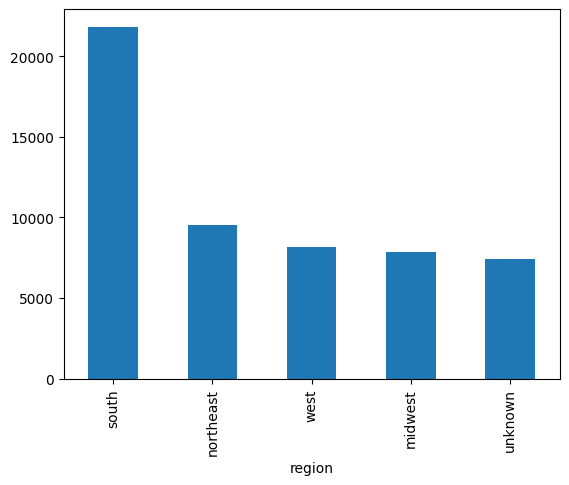

In [62]:
demographics.groupby('region')['PatientID'].count().sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:xlabel='PracticeType,region'>

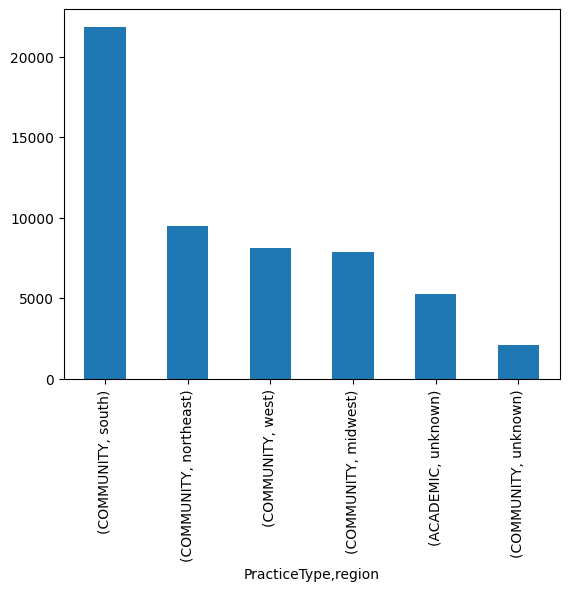

In [63]:
demographics.groupby(['PracticeType', 'region'])['PatientID'].count().sort_values(ascending = False).plot(kind = 'bar')

**Most patients come from community programs in the south. Interestingly, all academic patients are from an unknown region, likely for de-identification purposes.**

In [64]:
demographics = demographics.drop(columns = ['State'])

#### 1.6 PracticeID

In [65]:
demographics['PracticeID'].nunique()

155

In [66]:
demographics['PracticeID'].value_counts(normalize = True, dropna = False).head(10)

S291CF564BD92    0.073212
S507DCE5DD8C6    0.067682
S87C279DB0C8A    0.031395
S32D7D3854A0D    0.030154
SD6317E5462ED    0.029862
S6DCB6AF0A70F    0.028730
S10787FE9E379    0.028146
S19210F786354    0.025481
S260DA7B3CE37    0.022013
SD2555DC0ACD7    0.022013
Name: PracticeID, dtype: float64

In [67]:
demographics = demographics.drop(columns = ['PracticeID'])

#### 1.7 PrimaryPhysicianID

In [68]:
demographics['PrimaryPhysicianID'].nunique()

1661

In [69]:
demographics['PrimaryPhysicianID'].value_counts(normalize = True, dropna = False).head(10)

NaN              0.107966
TDA8B41161687    0.008214
TB265DE7448E6    0.006096
T8BBC5E6BC74E    0.005713
T4BD7593DF5D2    0.004636
TD36E479F7705    0.004563
T49F94535692C    0.004216
TF20BCACCB2FC    0.004034
T929DA10B68C8    0.003924
T1C00C217F1E9    0.003742
Name: PrimaryPhysicianID, dtype: float64

In [70]:
demographics = demographics.drop(columns = ['PrimaryPhysicianID'])

In [71]:
# Final training demographics table.
demographics.sample(5)

,PatientID,PracticeType,gender,race,ethnicity,age,region
12241,F158640A70B0F,COMMUNITY,F,White,unknown,64,south
16678,FC6909B780CE3,COMMUNITY,F,Asian,unknown,77,west
22668,FC091914B1AA3,COMMUNITY,M,White,unknown,74,south
25197,FB0F921BC9062,ACADEMIC,M,White,unknown,78,unknown
52812,FF919C85F8FE3,COMMUNITY,M,unknown,unknown,55,midwest


In [72]:
row_ID(demographics)

(54786, 54786)

In [73]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
demographics   DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
enhanced_adv   DataFrame               PatientID Diag<...>n[68483 rows x 7 columns]


### 2. Enhanced_AdvancedNSCLC

In [74]:
enhanced_adv.sample(5)

,PatientID,DiagnosisDate,adv_date,Histology,GroupStage,SmokingStatus,adv_year_cat
37878,F99C6A9DB85F9,2018-11-23,2018-11-23,Non-squamous cell carcinoma,Stage IIIB,No history of smoking,17-18
24520,F729887AEE193,2012-09-05,2012-09-05,Non-squamous cell carcinoma,Stage IV,Unknown/Not documented,11-12
4000,F5C8B4167B87E,2014-02-27,2014-02-27,Non-squamous cell carcinoma,Stage IV,History of smoking,13-14
42667,F86CA46FBCB08,2020-11-27,2020-11-27,Non-squamous cell carcinoma,Stage IVB,History of smoking,19-21
32925,F122B7A79EC5E,2019-07-02,2020-06-01,Non-squamous cell carcinoma,Stage II,History of smoking,19-21


In [75]:
enhanced_adv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68483 entries, 0 to 68482
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PatientID      68483 non-null  object        
 1   DiagnosisDate  68447 non-null  object        
 2   adv_date       68483 non-null  datetime64[ns]
 3   Histology      68483 non-null  object        
 4   GroupStage     68483 non-null  object        
 5   SmokingStatus  68483 non-null  object        
 6   adv_year_cat   68483 non-null  category      
dtypes: category(1), datetime64[ns](1), object(5)
memory usage: 3.2+ MB


In [76]:
enhanced_adv = enhanced_adv[enhanced_adv['PatientID'].isin(train_IDs)]

In [77]:
row_ID(enhanced_adv)

(54786, 54786)

#### 2.1 Histology

In [78]:
enhanced_adv['Histology'].value_counts(normalize = True, dropna = False)

Non-squamous cell carcinoma    0.689172
Squamous cell carcinoma        0.258040
NSCLC histology NOS            0.052787
Name: Histology, dtype: float64

#### 2.2 GroupStage

In [79]:
enhanced_adv['GroupStage'].value_counts(normalize = True, dropna = False)

Stage IV                       0.556200
Stage IIIB                     0.109481
Stage IIIA                     0.081024
Stage IA                       0.036688
Group stage is not reported    0.033749
Stage IB                       0.032216
Stage IVA                      0.030847
Stage IVB                      0.026448
Stage IIA                      0.023710
Stage IIB                      0.023546
Stage I                        0.018107
Stage III                      0.013142
Stage II                       0.005458
Stage IIIC                     0.005403
Stage IA3                      0.001752
Stage IA2                      0.001570
Stage IA1                      0.000475
Stage 0                        0.000110
Occult                         0.000073
Name: GroupStage, dtype: float64

In [80]:
# Dictionary for regrouping stages
stage_dict = { 
    'Stage I': 'I',
    'Stage IA': 'I',
    'Stage IA1': 'I', 
    'Stage IA2': 'I',
    'Stage IA3': 'I', 
    'Stage IB': 'I',
    'Stage II': 'II',
    'Stage IIA': 'II',
    'Stage IIB': 'II',
    'Stage III': 'III',
    'Stage IIIA': 'IIIA',
    'Stage IIIB': 'IIIB',
    'Stage IIIC': 'IIIC',
    'Stage IV': 'IV',
    'Stage IVA': 'IV',
    'Stage IVB': 'IV'
}

enhanced_adv['stage'] = enhanced_adv['GroupStage'].map(stage_dict)

In [81]:
enhanced_adv['stage'] = enhanced_adv['stage'].fillna('unknown')

In [82]:
enhanced_adv['stage'].value_counts(normalize = True, dropna = False)

IV         0.613496
IIIB       0.109481
I          0.090808
IIIA       0.081024
II         0.052714
unknown    0.033932
III        0.013142
IIIC       0.005403
Name: stage, dtype: float64

In [83]:
enhanced_adv = enhanced_adv.drop(columns = ['GroupStage'])

#### 2.3 SmokingStatus

In [84]:
enhanced_adv['SmokingStatus'].value_counts(normalize = True, dropna = False)*100

History of smoking        86.819625
No history of smoking     12.154565
Unknown/Not documented     1.025810
Name: SmokingStatus, dtype: float64

#### 2.4 AdvancedDiagnosisDate

In [85]:
enhanced_adv['adv_date'].min()

Timestamp('2011-01-01 00:00:00')

In [86]:
enhanced_adv['adv_date'].max()

Timestamp('2021-02-25 00:00:00')

In [87]:
enhanced_adv['adv_date'].dt.year.describe()

count    54786.000000
mean      2015.752364
std          2.712601
min       2011.000000
25%       2014.000000
50%       2016.000000
75%       2018.000000
max       2021.000000
Name: adv_date, dtype: float64

<AxesSubplot:xlabel='adv_date'>

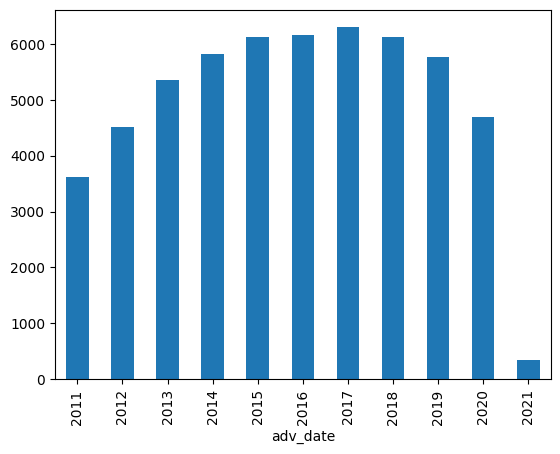

In [88]:
enhanced_adv.groupby([enhanced_adv['adv_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='adv_date'>

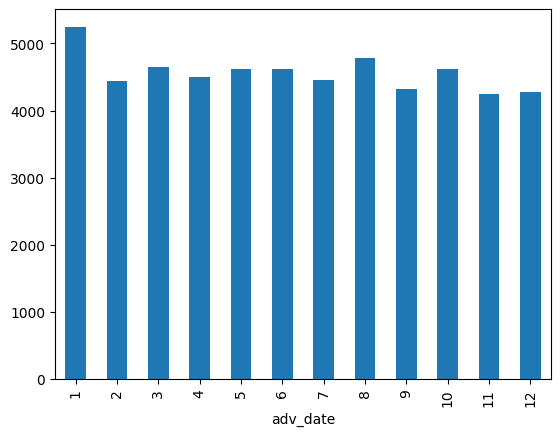

In [89]:
enhanced_adv.groupby([enhanced_adv['adv_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

In [90]:
enhanced_adv.loc[:, 'adv_year'] = enhanced_adv['adv_date'].dt.year

#### 2.5 DiagnosisDate

In [91]:
enhanced_adv['DiagnosisDate'].isna().sum()

26

In [92]:
enhanced_adv = enhanced_adv.rename(columns = {'DiagnosisDate': 'diagnosis_date'})

In [93]:
# Missing diagnosis_date will be replaced with adv_date; other dates will be left untouched. 
enhanced_adv['diagnosis_date'] = (
    np.where(enhanced_adv['diagnosis_date'].isna(), enhanced_adv['adv_date'], enhanced_adv['diagnosis_date'])
)

In [94]:
enhanced_adv['diagnosis_date'] = pd.to_datetime(enhanced_adv['diagnosis_date'])

In [95]:
enhanced_adv['diagnosis_date'].min()

Timestamp('1980-01-01 00:00:00')

In [96]:
enhanced_adv['diagnosis_date'].max()

Timestamp('2021-02-25 00:00:00')

In [97]:
enhanced_adv['diagnosis_date'].dt.year.describe()

count    54786.00000
mean      2015.18136
std          3.13868
min       1980.00000
25%       2013.00000
50%       2015.00000
75%       2018.00000
max       2021.00000
Name: diagnosis_date, dtype: float64

<AxesSubplot:xlabel='diagnosis_date'>

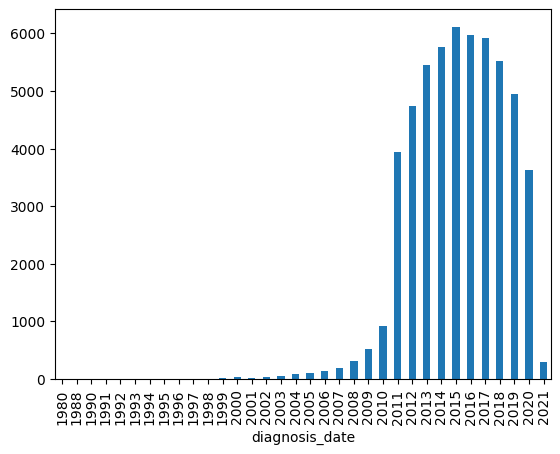

In [98]:
# Bar plot of number of new NSCLC diagnoses per year.
enhanced_adv.groupby([enhanced_adv['diagnosis_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

**The range of dates for diagnosis is 1/1980 to 2/2021 with a median year of 2015.** 

In [99]:
# Percent of patients diagnosed prior to advanced diagnosis. 
(
    enhanced_adv
    .query('diagnosis_date < adv_date')
    .shape[0]/(len(enhanced_adv))
)

0.2711824188661337

#### 2.6 Time from diagnosis date to advanced date

In [100]:
enhanced_adv.loc[:, 'delta_adv_diagnosis'] = (enhanced_adv['adv_date'] - enhanced_adv['diagnosis_date']).dt.days

In [101]:
# Brief summary statistics on time between diagnosis date and advanced diagnosis for those diagnosed prior to advanced diagnosis.
(
    enhanced_adv
    .query('delta_adv_diagnosis > 0')
    .describe()
)

,adv_year,delta_adv_diagnosis
count,14857.000000,14857.000000
mean,2015.782258,775.065154
std,2.672944,916.952853
min,2011.000000,1.000000
25%,2014.000000,252.000000
50%,2016.000000,462.000000
75%,2018.000000,920.000000
max,2021.000000,13062.000000


In [102]:
# Final enhanced_adv dataframe
enhanced_adv.sample(5)

,PatientID,diagnosis_date,adv_date,Histology,SmokingStatus,adv_year_cat,stage,adv_year,delta_adv_diagnosis
23989,F626357507E4C,2011-01-12,2012-10-23,Non-squamous cell carcinoma,History of smoking,11-12,I,2012,650
64918,FB3286669D878,2014-04-01,2014-04-01,Non-squamous cell carcinoma,History of smoking,13-14,IV,2014,0
34376,F59DB725F1389,2016-04-28,2016-04-28,Non-squamous cell carcinoma,History of smoking,15-16,IV,2016,0
55768,F671225712167,2010-09-16,2019-08-21,Squamous cell carcinoma,History of smoking,19-21,I,2019,3261
27207,F9F989AB3B32A,2012-03-30,2012-03-30,Squamous cell carcinoma,History of smoking,11-12,IIIB,2012,0


In [103]:
row_ID(enhanced_adv)

(54786, 54786)

In [104]:
%whos DataFrame

Variable       Type         Data/Info
-------------------------------------
demographics   DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
enhanced_adv   DataFrame               PatientID diag<...>n[54786 rows x 9 columns]


### 3. Mortality 

In [105]:
mortality = pd.read_csv('Enhanced_Mortality_V2.csv')

In [106]:
mortality.sample(5)

,PatientID,DateOfDeath
25089,FCF0263E2469C,2020-11
44772,F86ABCF198130,2013-05
47438,FD329BE4A8786,2018-12
44845,F8949C19876CC,2013-01
22088,F6F98889D69FA,2016-07


In [107]:
mortality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49082 entries, 0 to 49081
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PatientID    49082 non-null  object
 1   DateOfDeath  49082 non-null  object
dtypes: object(2)
memory usage: 767.0+ KB


In [108]:
mortality = mortality[mortality['PatientID'].isin(train_IDs)]

In [109]:
row_ID(mortality)

(39276, 39276)

In [110]:
mortality = mortality.rename(columns = {'DateOfDeath': 'death_date'})

In [111]:
# Patients with year granularity.
mortality[mortality['death_date'].str.len() == 4]

,PatientID,death_date
109,FAF6E3C8FE4AB,2019
120,F3C779F8FB75B,2019
1100,FED71A9C1D23F,2020
7372,F8998F4E8FBA0,2017
9395,F1B49E083CE0C,2015
12065,FFE3CF2351E63,2013
13575,FECA353FF9906,2014
23342,F3480BF8FFEFE,2014
24894,F67F3540EFFFB,2020
35358,FCAB88055F5DB,2016


**The date of death is generalized to the month for de-identification purposes, however a small number have just the year for date of death. For analyses requiring a day of death, Flatiron Health recommends imputing the 15th of the month since this approach best approximates the results generated from using the exact date of death. For those with a date of death at a year granularity, Flatiron recommends imputing the middle of the year and conducting a sensitivty analysis to evaluate assumption.**

In [112]:
# For patients with year granularity, impute middle of the year (ie., July 1)
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 4, mortality['death_date'] + '-07-01', mortality['death_date'])
)

In [113]:
# For patients with month granularity, impute 15th of the month.
mortality['death_date'] = (
    np.where(mortality['death_date'].str.len() == 7, mortality['death_date'] + '-15', mortality['death_date'])
)

In [114]:
mortality['death_date'] = pd.to_datetime(mortality['death_date'])

In [115]:
# Percent of patients with a death date in the training set. 
mortality.shape[0]/len(train_IDs)

0.7168984777132844

<AxesSubplot:xlabel='death_date'>

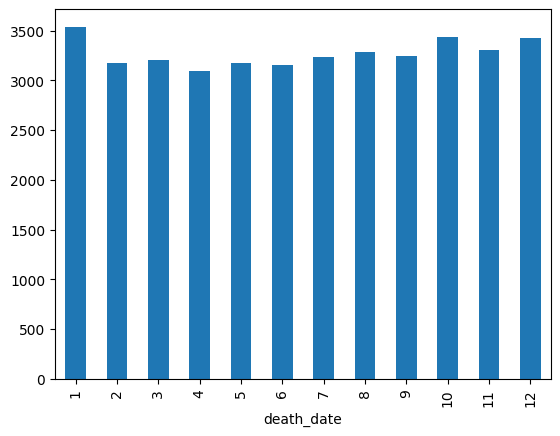

In [116]:
# Bar plot of monthly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.month])['PatientID'].count().plot(kind = 'bar')

<AxesSubplot:xlabel='death_date'>

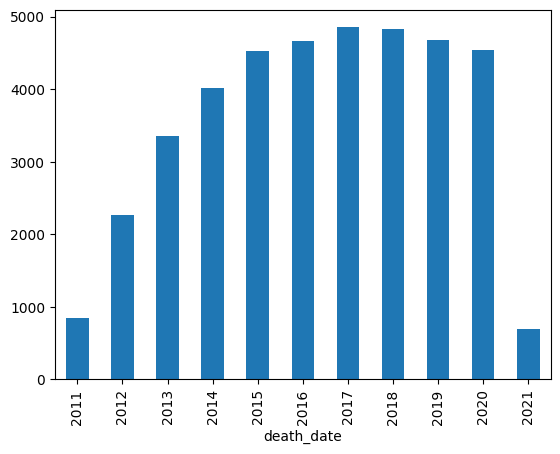

In [117]:
# Bar plot of yearly mortality for aNSCLC. 
mortality.groupby([mortality['death_date'].dt.year])['PatientID'].count().plot(kind = 'bar')

#### Censoring

**For patients for whom a date of death is not known, the censor date can be defined either as the data cutoff date or as the last confirmed activity date. The last confirmed activity date is broadly defined as the last date at which there is evidence in the EHR that a patient is alive. Evidence of a record in at least one of the items listed below qualifies as patient-level confirmed activity:**
* **Visit: VisitDate**
* **Enhanced_AdvNSCLC_Orals: StartDate or EndDate**
* **Enhanced_AdvNSCLCBiomarkers: SpecimenCollectedDate**
* **Enhanced_AdvNSCLCProgression: LastClinicNoteDate or ProgressionDate**

In [118]:
visit = pd.read_csv('Visit.csv')
telemedicine = pd.read_csv('Telemedicine.csv')
orals = pd.read_csv('Enhanced_AdvNSCLC_Orals.csv')
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')
progression = pd.read_csv ('Enhanced_AdvNSCLCProgression.csv')

##### Visit and Telemedicine

In [119]:
visit.sample(5)

,PatientID,VisitDate,VisitType,IsVitalsVisit,IsTreatmentVisit,IsLabVisit
625481,F29D6E3F1B16B,2016-01-19,Vitals,True,False,True
2377354,FFBDEF0E76F02,2018-08-09,Treatment,True,True,True
1504506,FA0A0A43615DF,2016-04-05,Treatment,True,True,True
609558,FF04757192F19,2019-10-21,Lab,False,False,True
924165,F88874882AA04,2017-01-09,Treatment,False,True,False


In [120]:
visit.shape

(2446952, 6)

In [121]:
telemedicine.sample(5)

,PatientID,VisitDate
4136,F22513E7E8F11,2020-12-14
1076,FE17F90ADEC5C,2020-06-11
11229,F1B53B490370F,2020-05-20
11206,FA5ADD4C37BDD,2020-11-16
8108,F86599F9070CF,2020-04-03


In [122]:
telemedicine.shape

(16712, 2)

In [123]:
visit_tele = (
    visit
    .drop(columns = ['VisitType', 'IsVitalsVisit', 'IsTreatmentVisit', 'IsLabVisit'])
    .append(telemedicine)
) 

In [124]:
visit_tele.shape

(2463664, 2)

In [125]:
visit_tele.loc[:,'VisitDate'] = pd.to_datetime(visit_tele['VisitDate'])

In [126]:
visit_tele.sample(5)

,PatientID,VisitDate
2426797,F4EFE6FB4AEF3,2015-08-13
1835026,FA3F806616EF6,2019-05-02
5649,FC61014BD6F14,2021-02-11
40810,F8CEBD560B162,2018-11-06
678777,F6B704401D51E,2020-06-17


In [127]:
# Select max VisitDate from combined Visit and Telemedicine table.
visit_tele_max = (
    visit_tele
    [visit_tele['PatientID'].isin(train_IDs)]
    .groupby('PatientID')['VisitDate'].max()
    .to_frame(name = 'visit_max')
    .reset_index()
)

In [128]:
row_ID(visit_tele_max)

(54786, 54786)

##### Orals

In [129]:
orals = orals[orals['PatientID'].isin(train_IDs)]

In [130]:
row_ID(orals)

(11313, 8067)

In [131]:
orals.loc[:, 'StartDate'] = pd.to_datetime(orals['StartDate'])

In [132]:
orals.loc[:, 'EndDate'] = pd.to_datetime(orals['EndDate'])

In [133]:
orals_max = (
    orals
    .assign(max_date = orals[['StartDate', 'EndDate']].max(axis = 1))
    .groupby('PatientID')['max_date'].max()
    .to_frame(name = 'orals_max')
    .reset_index()
)

##### Biomarkers

In [134]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [135]:
row_ID(biomarkers)

(203645, 40197)

In [136]:
biomarkers.loc[:, 'SpecimenCollectedDate'] = pd.to_datetime(biomarkers['SpecimenCollectedDate'])

In [137]:
biomarkers_max = (
    biomarkers
    .groupby('PatientID')['SpecimenCollectedDate'].max()
    .to_frame(name = 'biomarkers_max')
    .reset_index()
)

##### Progression

In [138]:
progression = progression[progression['PatientID'].isin(train_IDs)]

In [139]:
row_ID(progression)

(68890, 39806)

In [140]:
progression.loc[:, 'ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [141]:
progression.loc[:, 'LastClinicNoteDate'] = pd.to_datetime(progression['LastClinicNoteDate'])

In [142]:
progression_max = (
    progression
    .assign(max_date = progression[['ProgressionDate', 'LastClinicNoteDate']].max(axis = 1))
    .groupby('PatientID')['max_date'].max()
    .to_frame(name = 'progression_max')
    .reset_index()
)

##### Max date merge

In [143]:
last_activity = pd.merge(visit_tele_max, orals_max, on = 'PatientID', how = 'outer')

In [144]:
last_activity = pd.merge(last_activity, biomarkers_max, on = 'PatientID', how = 'outer')

In [145]:
last_activity = pd.merge(last_activity, progression_max, on = 'PatientID', how = 'outer')

In [146]:
row_ID(last_activity)

(54786, 54786)

In [147]:
last_activity.sample(5)

,PatientID,visit_max,orals_max,biomarkers_max,progression_max
40592,FBDE51FED14EF,2013-12-13,NaT,2012-11-15,NaT
9754,F2D9350FD9A52,2020-06-18,NaT,2014-04-04,2020-06-18
10755,F3250C29A5588,2021-01-13,NaT,2019-01-16,2020-10-21
52519,FF534EEBA7E44,2016-12-20,NaT,NaT,2016-12-21
17116,F502BDDF2C3BC,2014-06-27,NaT,2014-06-16,NaT


In [148]:
# Find max of each row. 
last_activity = (
    last_activity
    .assign(last_activity = last_activity[['visit_max', 'orals_max', 'biomarkers_max', 'progression_max']].max(axis = 1))
    .filter(items = ['PatientID', 'last_activity'])
)

In [149]:
# Append missing training IDs.
mortality = (
    mortality
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(mortality['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False
    )
)

In [150]:
mortality = pd.merge(mortality, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID')

In [151]:
mortality = pd.merge(mortality, last_activity, on = 'PatientID')

In [152]:
row_ID(mortality)

(54786, 54786)

In [153]:
mortality.loc[:, 'death_status'] = np.where(mortality['death_date'].isna(), 0, 1)

In [154]:
# timerisk_activity is time from advanced disease diagnosis to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['adv_date']).dt.days,
             (mortality['death_date'] - mortality['adv_date']).dt.days)
)

In [155]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity'] = np.where(mortality['timerisk_activity'] < 0, 0, mortality['timerisk_activity'])

In [156]:
mortality.sample(5)

,PatientID,death_date,adv_date,last_activity,death_status,timerisk_activity
12164,FCB746E5EFBA4,2013-07-15,2012-02-15,2013-07-03,1,516.0
8552,F88E4D9747071,2020-10-15,2016-04-13,2020-10-07,1,1646.0
6226,FA7473C7A8A8C,2019-10-15,2017-12-04,2019-08-26,1,680.0
23963,FD19252C8F02A,2020-11-15,2019-11-25,2020-11-11,1,356.0
44496,F9ED886039EE2,NaT,2015-08-05,2016-09-28,0,420.0


In [157]:
mortality.timerisk_activity.describe()

count    54786.000000
mean       492.921476
std        567.958201
min          0.000000
25%        111.000000
50%        285.000000
75%        652.000000
max       3707.000000
Name: timerisk_activity, dtype: float64

In [158]:
# Percent of patients censored overall. 
(mortality.shape[0] - mortality['death_status'].sum())/mortality.shape[0]

0.2831015222867156

In [159]:
# Percent of patients dying within 365 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 365)).sum()/mortality.shape[0]

0.4463366553499069

In [160]:
# Percent of patients dying within 720 days. 
((mortality['death_status'] == 1) & (mortality['timerisk_activity'] <= 720)).sum()/mortality.shape[0]

0.5929617055452123

Median survival in days: 379.0


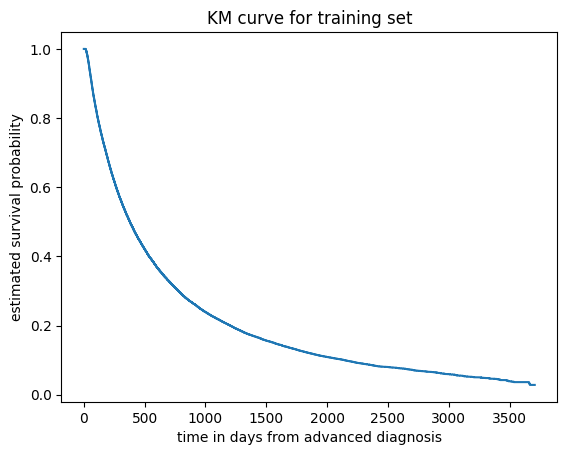

In [161]:
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

%matplotlib inline

time, survival_prob = kaplan_meier_estimator(mortality['death_status'].astype('bool'), mortality['timerisk_activity'])
plt.step(time, survival_prob, where = 'post')

plt.title('KM curve for training set')
plt.ylabel('estimated survival probability')
plt.xlabel('time in days from advanced diagnosis')
print('Median survival in days:', time[np.where(survival_prob <0.5)][0])

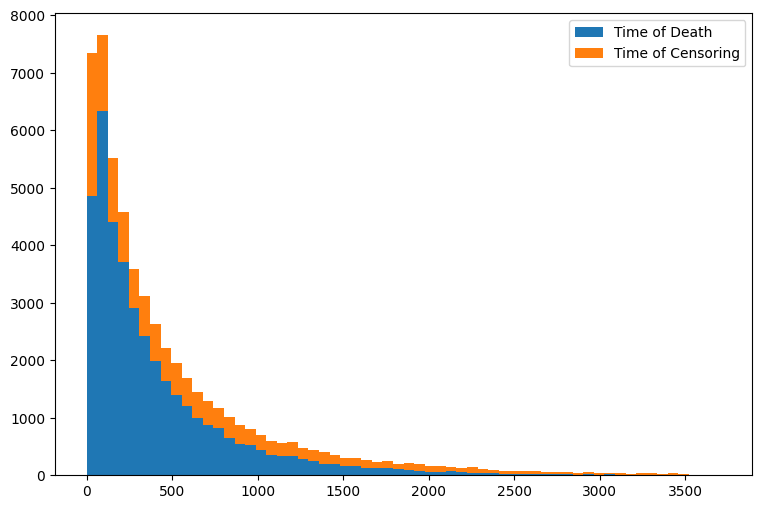

In [162]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist((mortality['timerisk_activity'][mortality['death_status'].astype('bool')],
                               mortality['timerisk_activity'][~mortality['death_status'].astype('bool')]),
                              bins = 60, stacked = True)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

In [163]:
mortality = pd.merge(mortality, enhanced_adv[['PatientID', 'diagnosis_date']], on = 'PatientID', how = 'outer')

In [164]:
# timerisk_activity_first is time from first diagnosis (advanced or not) to death or last activity if no death date.
mortality.loc[:, 'timerisk_activity_first'] = (
    np.where(mortality['death_date'].isna(),
             (mortality['last_activity'] - mortality['diagnosis_date']).dt.days,
             (mortality['death_date'] - mortality['diagnosis_date']).dt.days)
)

In [165]:
# If timerisk_activity is less than 0, set to 0 otherwise remains unchanged. 
mortality['timerisk_activity_first'] = np.where(
    mortality['timerisk_activity_first'] < 0, 0, mortality['timerisk_activity_first'])

In [166]:
mortality.to_csv('mortality_cleaned_tr.csv', index = False, header = True)

In [167]:
mortality = mortality.filter(items = ['PatientID', 'death_status', 'timerisk_activity'])

In [168]:
%whos DataFrame

Variable          Type         Data/Info
----------------------------------------
biomarkers        DataFrame                PatientID Bio<...>203645 rows x 18 columns]
biomarkers_max    DataFrame               PatientID biom<...>n[40197 rows x 2 columns]
demographics      DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
enhanced_adv      DataFrame               PatientID diag<...>n[54786 rows x 9 columns]
last_activity     DataFrame               PatientID last<...>n[54786 rows x 2 columns]
mortality         DataFrame               PatientID  dea<...>n[54786 rows x 3 columns]
orals             DataFrame               PatientID     <...>n[11313 rows x 5 columns]
orals_max         DataFrame              PatientID  oral<...>\n[8067 rows x 2 columns]
progression       DataFrame               PatientID Prog<...>n[68890 rows x 8 columns]
progression_max   DataFrame               PatientID prog<...>n[39806 rows x 2 columns]
telemedicine      DataFrame               Patien

In [169]:
# Keep mortality
del biomarkers
del biomarkers_max
del last_activity
del orals
del orals_max
del progression 
del progression_max
del visit_tele
del visit_tele_max

### 4. MedicationAdministration

In [170]:
med_admin = pd.read_csv('MedicationAdministration.csv')

In [171]:
med_admin.head()

,PatientID,OrderID,DrugName,CommonDrugName,Route,DrugCategory,DetailedDrugCategory,AdministeredDate,AdministeredAmount,AdministeredUnits
0,FE3742B2CEB28,M4D4B1CABB7301DACDE43CBD12FECFD38,pantoprazole sodium,pantoprazole,Intravenous,proton pump inhibitor,proton pump inhibitor,2020-09-14,40.0,mg
1,FE3742B2CEB28,M6B6BC37AF71B2C90622B39BFF8E1F5CD,0.9 % sodium chloride,sodium/saline preparations,Intravenous,solution-fluid,solution-fluid,2020-09-14,300.0,mL
2,FE3742B2CEB28,M6FCEFA3C3DF7C345E6C22BEBAC62D4A4,0.9 % sodium chloride,sodium/saline preparations,Intravenous,solution-fluid,solution-fluid,2020-09-14,30.0,mL/hr
3,FE3742B2CEB28,M8D5A5DCB9E6F7312DE55DC40AF15A4F3,"ringer's solution,lactated",electrolyte maintenance,Intravenous,solution-fluid,solution-fluid,2020-09-13,1000.0,mL
4,FE3742B2CEB28,M8D5E9A7AE9EBAB4484FB15B6F21852D5,pantoprazole sodium,pantoprazole,Intravenous,proton pump inhibitor,proton pump inhibitor,2020-09-14,40.0,mg


In [172]:
med_admin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3368216 entries, 0 to 3368215
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   PatientID             object 
 1   OrderID               object 
 2   DrugName              object 
 3   CommonDrugName        object 
 4   Route                 object 
 5   DrugCategory          object 
 6   DetailedDrugCategory  object 
 7   AdministeredDate      object 
 8   AdministeredAmount    float64
 9   AdministeredUnits     object 
dtypes: float64(1), object(9)
memory usage: 257.0+ MB


In [173]:
row_ID(med_admin)

(3368216, 52146)

In [174]:
# Select Patient IDs from training set. 
med_admin = med_admin[med_admin['PatientID'].isin(train_IDs)]

In [175]:
row_ID(med_admin)

(2696916, 41687)

**The Medication Administration table documents the date a medication was administered to a patient. An indicator variable for clinically relevant administered medications received between -90 days from advanced diagnosis and up to time of first line of therapy or +30 from index dates, whichever comes first, will be created as columns. The reason for including time of first line therapy as upper bound of elgibility window is that steroids are given as part of treamtent for chemotherapy induced nausea and vomiting, so steroids might inadvertently capture chemotherpay treatment information if upper bound is after first line of treatment.** 

In [176]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [177]:
line_therapy_1 = (
    line_therapy 
    .query('LineNumber == 1 and IsMaintenanceTherapy == False')
)

In [178]:
med_admin = pd.merge(med_admin, line_therapy_1[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [179]:
med_admin = pd.merge(med_admin, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [180]:
med_admin.loc[:, 'AdministeredDate'] = pd.to_datetime(med_admin['AdministeredDate'])

In [181]:
med_admin.loc[:, 'StartDate'] = pd.to_datetime(med_admin['StartDate'])

In [182]:
med_admin['AdministeredDate'].isna().sum()

0

In [183]:
# Median days from advanced date to start of first line of therapy. 
(
    med_admin
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .assign(start_adv_diff = lambda x: (x.StartDate - x.adv_date).dt.days)
    .start_adv_diff
    .median()
)

35.0

In [184]:
# New variable upper_bound which defines upper bound
# If no StartDate (ie., no treatment received), then upper bound +30 from advanced diagnosis 
# If StartDate is greater than 30 days from advanced diagnosis, then upper bound +30 from advanced diagnosis
# If StartDate is less than or equal 30 from advanced diagnosis, then upper bound is one day before StartDate
conditions = [
    (med_admin['StartDate'].isna()) | ((med_admin['StartDate'] - med_admin['adv_date']).dt.days > 30),
    ((med_admin['StartDate'] - med_admin['adv_date']).dt.days <= 30)]    

choices = [30, (med_admin['StartDate'] - med_admin['adv_date']).dt.days - 1]
    
med_admin.loc[:, 'upper_bound'] = np.select(conditions, choices)

In [185]:
med_admin.loc[:, 'upper_bound_date'] = (
    np.where(med_admin['upper_bound'] != 30, 
             med_admin['StartDate'] - pd.DateOffset(days = 1), 
             med_admin['adv_date'] + pd.DateOffset(days = 30))
)

In [186]:
# Select window of -90 days and from advanced diagnosis and remove clinical study drug. 
med_admin_win = (
    med_admin
    [((med_admin['AdministeredDate'] - med_admin['adv_date']).dt.days >= -90) &
    (med_admin['AdministeredDate'] <= med_admin['upper_bound_date']) &
    (med_admin['CommonDrugName'] != 'Clinical study drug')]
)

In [187]:
row_ID(med_admin_win)

(162243, 11193)

#### 4.1 Antineoplastic

In [188]:
(
    med_admin_win
    .query('DrugCategory == "antineoplastic"')
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

carboplatin                 0.284101
paclitaxel                  0.217646
durvalumab                  0.080429
pemetrexed                  0.065074
etoposide                   0.055732
cisplatin                   0.050370
gemcitabine                 0.035990
paclitaxel protein-bound    0.030709
docetaxel                   0.026485
nivolumab                   0.025916
pembrolizumab               0.021285
vinorelbine                 0.016411
bevacizumab                 0.013567
fluorouracil                0.007637
azacitidine                 0.007555
rituximab                   0.007312
bortezomib                  0.005606
cetuximab                   0.004956
bendamustine                0.004143
erlotinib                   0.003250
Name: CommonDrugName, dtype: float64

#### 4.2 Antiemetic

In [189]:
(
    med_admin_win
    .query('DrugCategory == "antiemetic"')
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

palonosetron                  0.351168
ondansetron                   0.341662
granisetron                   0.090349
fosaprepitant                 0.085461
metoclopramide                0.033768
prochlorperazine              0.028879
aprepitant                    0.023085
olanzapine                    0.018740
dronabinol                    0.008148
scopolamine                   0.005070
meclizine                     0.003983
dimenhydrinate                0.002806
fosnetupitant/palonosetron    0.002716
promethazine                  0.002082
dolasetron                    0.001901
rolapitant                    0.000091
netupitant/palonosetron       0.000091
Name: CommonDrugName, dtype: float64

#### 4.3 Solution-fluid

In [190]:
(
    med_admin_win
    .query('DrugCategory == "solution-fluid"')
    .CommonDrugName
    .value_counts(normalize = True)
)

sodium/saline preparations                     0.829724
electrolyte maintenance                        0.089274
iv solutions: dextrose-saline                  0.029378
iv solutions: dextrose-water                   0.029252
sodium chloride irrigating solution            0.018826
iv solutions: dextrose and lactated ringers    0.001857
water for irrigation, sterile                  0.001688
Name: CommonDrugName, dtype: float64

#### 4.4 Glucocorticoid & steroid

In [191]:
(
    med_admin_win
    .query('DrugCategory == "glucocorticoid" or DrugCategory == "steroid"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName      Route           
dexamethasone       Intravenous         8071
                    Oral                2913
prednisone          Oral                1285
methylprednisolone  Intravenous          979
hydrocortisone      Intravenous          272
triamcinolone       Topical              110
dexamethasone       Intrajejunal         106
hydrocortisone      Topical               88
prednisolone        Ophthalmic            66
fludrocortisone     Oral                  57
mometasone furoate  Inhalation            42
cortisone           Oral                  30
methylprednisolone  Oral                  24
prednisone          enteral               23
hydrocortisone      Oral                  19
clobetasol          Topical               19
dexamethasone       Intramuscular         18
methylprednisolone  Intramuscular         14
dexamethasone       Otic                  11
                    Nasogastric           10
beclomethasone      Inhalation             8
methylprednisolone

High frequency of glucocorticoid administration. A large portion likely reflects use in prevention and treatment of chemotherapy-induced nausea and vomiting. Clinically relevant so will create glucocorticoid indicator variable. 

In [192]:
(
    med_admin_win
    [((med_admin_win['DrugCategory'] == 'glucocorticoid') | 
      (med_admin_win['CommonDrugName'] == 'hydrocortisone')) & 
     ((med_admin_win['Route'] == 'Intravenous') | 
     (med_admin_win['Route'] == 'Oral') | 
     (med_admin_win['Route'] == 'Intrajejunal'))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName      Route       
dexamethasone       Intravenous     8071
                    Oral            2913
prednisone          Oral            1285
methylprednisolone  Intravenous      979
hydrocortisone      Intravenous      272
dexamethasone       Intrajejunal     106
methylprednisolone  Oral              24
hydrocortisone      Oral              19
methylprednisolone  Intrajejunal       7
hydrocortisone      Intrajejunal       1
Name: PatientID, dtype: int64

In [193]:
med_admin_win.loc[:, 'steroid_diag'] = (
    np.where(((med_admin_win['DrugCategory'] == 'glucocorticoid') | 
              (med_admin_win['CommonDrugName'] == 'hydrocortisone')) & 
             ((med_admin_win['Route'] == 'Intravenous') | 
              (med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Intrajejunal')), 1, 0)
)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


#### 4.5 Pain agent

In [194]:
(
    med_admin_win
    .query('DrugCategory == "pain agent"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending=False)
    .head(20)
)

CommonDrugName             Route       
oxycodone                  Oral            4897
morphine                   Intravenous     2616
hydromorphone              Intravenous     2305
acetaminophen              Oral            1899
gabapentin                 Oral            1864
lidocaine                  Transdermal     1381
morphine                   Oral             950
acetaminophen/oxycodone    Oral             862
tramadol                   Oral             848
lidocaine                  Intravenous      840
hydromorphone              Oral             526
ketorolac                  Intravenous      506
ibuprofen                  Oral             495
lidocaine                  Topical          459
pregabalin                 Oral             360
morphine                   Subcutaneous     319
acetaminophen/hydrocodone  Oral             292
fentanyl                   Transdermal      250
cyclobenzaprine            Oral             218
lidocaine                  Intradermal      206


Clinically releavant. Three indicator variables from 'pain agent' category will be created:
- opioid PO: patient recieved oral opioid (fentanyl patch included)
- non-opioid PO: patient received non-opioid orally 
- pain IV: patient received pain medciation intravenously

##### 4.5a opioid PO

In [195]:
# List of avialable opioids in the US. 
opioid_list = [
    'buprenorphine',
    'codeine',
    'fentanyl',
    'hydrocodone',
    'hydromorphone',
    'methadone',
    'morphine',
    'oxycodone',
    'oxymorphone',
    'tapentadol',
    'tramadol'
]

In [196]:
(
    med_admin_win
    [((med_admin_win['Route'] == 'Oral') | 
      (med_admin_win['Route'] == 'Transdermal') | 
      (med_admin_win['Route'] == 'Sublingual')) &
     (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName             Route      
oxycodone                  Oral           4897
morphine                   Oral            950
acetaminophen/oxycodone    Oral            862
tramadol                   Oral            848
hydromorphone              Oral            526
acetaminophen/hydrocodone  Oral            292
fentanyl                   Transdermal     250
methadone                  Oral            202
acetaminophen/codeine      Oral            164
codeine                    Oral             16
buprenorphine              Sublingual       14
morphine                   Sublingual       13
fentanyl                   Sublingual        9
oxymorphone                Oral              4
tapentadol                 Oral              4
fentanyl                   Oral              1
Name: PatientID, dtype: int64

In [197]:
med_admin_win.loc[:, 'opioid_PO_diag'] = (
    np.where(((med_admin_win['Route'] == 'Oral') | 
              (med_admin_win['Route'] == 'Transdermal') | 
              (med_admin_win['Route'] == 'Sublingual')) &
             (med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### 4.5b Nonopioid PO

In [198]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & 
     (med_admin_win['Route'] == 'Oral') & 
     (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list)))]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName                     Route
acetaminophen                      Oral     1899
gabapentin                         Oral     1864
ibuprofen                          Oral      495
pregabalin                         Oral      360
cyclobenzaprine                    Oral      218
baclofen                           Oral      122
salicylates                        Oral      113
sulfasalazine                      Oral      108
acetaminophen/butalbital/caffeine  Oral       89
celecoxib                          Oral       81
naproxen                           Oral       71
phenol                             Oral       66
lidocaine                          Oral       50
benzocaine/menthol                 Oral       35
naloxegol                          Oral       31
meloxicam                          Oral       20
clonidine                          Oral       19
aspirin                            Oral       14
tizanidine                         Oral       11
methocarbamol               

In [199]:
med_admin_win.loc[:, 'nonopioid_PO_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Oral') & 
             (~med_admin_win['CommonDrugName'].str.contains('|'.join(opioid_list))), 1, 0)
)

##### 4.5c Pain IV

In [200]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'pain agent') & (med_admin_win['Route'] == 'Intravenous')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName  Route      
morphine        Intravenous    2616
hydromorphone   Intravenous    2305
lidocaine       Intravenous     840
ketorolac       Intravenous     506
acetaminophen   Intravenous     185
fentanyl        Intravenous     139
meperidine      Intravenous      34
oxymorphone     Intravenous      22
abatacept       Intravenous       9
methadone       Intravenous       6
alfentanil      Intravenous       3
droperidol      Intravenous       1
nalbuphine      Intravenous       1
Name: PatientID, dtype: int64

In [201]:
med_admin_win.loc[:, 'pain_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'pain agent') & 
             (med_admin_win['Route'] == 'Intravenous') & 
             (med_admin_win['CommonDrugName'] != 'abatacept') & 
             (med_admin_win['CommonDrugName'] != 'lidocaine'), 1, 0)
)

#### 4.6 A. Hematological agent

In [202]:
(
    med_admin_win
    [med_admin_win['DrugCategory'] == 'hematological agent']
    .CommonDrugName
    .value_counts()
    .head(20)
)

heparin (porcine)            8037
enoxaparin                   3614
aspirin                      3001
pegfilgrastim                 764
epoetin alfa                  716
clopidogrel                   401
filgrastim                    400
warfarin                      307
darbepoetin alfa              300
apixaban                      299
rivaroxaban                   246
alteplase                     173
fondaparinux                  154
albumin human                 148
filgrastim-sndz               146
sargramostim                   94
thrombin                       88
dalteparin,porcine             88
thrombin (recombinant)         69
gelatin sponge,absorbable      50
Name: CommonDrugName, dtype: int64

**A therapeutic anticoagulation indicator variable will be created from the hematological agent category and will consist of:** 
* **Heparin: patients on a heparin gtt or other pareneral agents (eg., bivilrudin or argatroban)**
* **Enoxaparin: patients administered greater than prophylactic dosing of enoxaparin or other subcutaneous agents (eg., dalteparin or fondaparinux)**
* **DOAC: patients administered any dose of apxiaban, rivaroxabn, edoxaban, or dabigatran**
* **Warfarin: patients administered any dose of warfarin.**  

##### 4.6 Aa. Heparin and other parenteral agents

In [203]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('heparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(20)
)

5000.0    0.608624
500.0     0.111749
5.0       0.039163
18.0      0.030871
15.0      0.016966
7500.0    0.013395
16.0      0.012374
20.0      0.011226
12.0      0.009440
22.0      0.009312
30.0      0.008930
17.0      0.008037
14.0      0.006123
19.0      0.005485
21.0      0.004465
23.0      0.004082
13.0      0.004082
1000.0    0.003827
2500.0    0.003827
60.0      0.003827
Name: AdministeredAmount, dtype: float64

**About 70% of administered doses of heparin are either 5000 or 500 units, likely reflecting prophylacitc dosing and catheter lock therapy, respectively. Doses in the teens likely indicate heparin gtt doses.** 

In [204]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 5000)]
    .Route
    .value_counts(normalize = True)
)

Subcutaneous    0.993711
Intravenous     0.006289
Name: Route, dtype: float64

In [205]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredAmount'] == 500)]
    .Route
    .value_counts(normalize = True)
)

Intrajejunal           0.716763
Intravenous            0.272832
Other/Miscellaneous    0.010405
Name: Route, dtype: float64

In [206]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('heparin')) & (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

18.0    0.201499
15.0    0.109908
16.0    0.080766
20.0    0.073272
12.0    0.061615
22.0    0.060783
17.0    0.052456
14.0    0.039967
19.0    0.035803
21.0    0.029142
Name: AdministeredAmount, dtype: float64

In [207]:
# Total number of instances of a patient receiving heparin, bivalrudin, or argatroban drip
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
      (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
     (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
     (med_admin_win['CommonDrugName'].str.contains('argatroban'))]
    .groupby(['CommonDrugName', 'AdministeredUnits'])['PatientID'].count()
    .sort_values(ascending = False)
 )

CommonDrugName     AdministeredUnits
heparin (porcine)  unit/kg/hr           1204
bivalirudin        mg/kg/hr               41
argatroban         mcg/kg/min             11
Name: PatientID, dtype: int64

In [208]:
med_admin_win.loc[:, 'heparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('heparin')) & 
              (med_admin_win['AdministeredUnits'] == 'unit/kg/hr')) | 
             (med_admin_win['CommonDrugName'].str.contains('bivalirudin')) | 
             (med_admin_win['CommonDrugName'].str.contains('argatroban')), 1, 0)
)

##### 4.6 Ab. Enoxaparin and other subcutaneous agents 

In [209]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('enoxaparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

40.0     0.558357
80.0     0.116997
30.0     0.115864
60.0     0.067989
120.0    0.043626
100.0    0.041360
150.0    0.014731
70.0     0.008215
90.0     0.007932
50.0     0.007082
Name: AdministeredAmount, dtype: float64

Doses of 40 or 30 likley reflect prophylactic VTE dosing and are less clinically relevant than higher doses. 

In [210]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('dalteparin')]
    .AdministeredAmount
    .value_counts(normalize = True)
    .head(10)
)

5000.0     0.522727
12500.0    0.170455
6250.0     0.113636
7500.0     0.090909
10000.0    0.056818
17500.0    0.022727
20000.0    0.011364
12400.0    0.011364
Name: AdministeredAmount, dtype: float64

**Dose of 5,000 likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [211]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('fondaparinux')]
    .AdministeredAmount
    .value_counts(normalize = True)
)

7.5     0.766234
2.5     0.136364
5.0     0.090909
10.0    0.006494
Name: AdministeredAmount, dtype: float64

**Dose of 2.5 likley reflects prophylactic VTE dosing and is less clinically relevant than higher doses.** 

In [212]:
(
    med_admin_win
    [((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
      (med_admin_win['AdministeredAmount'] > 40)) | 
     ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
      (med_admin_win['AdministeredAmount'] > 5000)) | 
     ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
      (med_admin_win['AdministeredAmount'] > 2.5))]
    .groupby(['CommonDrugName', 'AdministeredAmount'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName      AdministeredAmount
enoxaparin          80.0                  413
                    60.0                  240
                    120.0                 154
                    100.0                 146
fondaparinux        7.5                   118
enoxaparin          150.0                  52
                    70.0                   29
                    90.0                   28
                    110.0                  25
                    50.0                   25
                    130.0                  20
dalteparin,porcine  12500.0                15
fondaparinux        5.0                    14
dalteparin,porcine  6250.0                 10
                    7500.0                  8
enoxaparin          125.0                   5
dalteparin,porcine  10000.0                 5
enoxaparin          160.0                   4
                    140.0                   3
                    101.0                   2
Name: PatientID, dtype: int64

In [213]:
med_admin_win.loc[:, 'enoxaparin_diag'] = (
    np.where(((med_admin_win['CommonDrugName'].str.contains('enoxaparin')) & 
              (med_admin_win['AdministeredAmount'] > 40)) | 
             ((med_admin_win['CommonDrugName'].str.contains('dalteparin')) & 
              (med_admin_win['AdministeredAmount'] > 5000)) | 
             ((med_admin_win['CommonDrugName'].str.contains('fondaparinux')) & 
              (med_admin_win['AdministeredAmount'] > 2.5)), 1, 0)
)

##### 4.6 Ac. DOAC

In [214]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
     (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
     (med_admin_win['CommonDrugName'].str.contains('edoxaban'))]
    .CommonDrugName
    .value_counts()
)

apixaban                299
rivaroxaban             246
dabigatran etexilate     15
Name: CommonDrugName, dtype: int64

In [215]:
med_admin_win.loc[:, 'doac_diag'] = (
    np.where((med_admin_win['CommonDrugName'].str.contains('apixaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('rivaroxaban')) | 
             (med_admin_win['CommonDrugName'].str.contains('dabigatran')) | 
             (med_admin_win['CommonDrugName'].str.contains('edoxaban')), 1, 0)
)

##### 4.6 Ad. Warfarin

In [216]:
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('warfarin'))]
    .AdministeredAmount
    .value_counts()
)

5.00     124
2.50      49
2.00      35
7.50      19
6.00      19
3.00      17
4.00      16
10.00      8
1.00       8
8.00       3
0.50       2
9.00       1
12.00      1
1.25       1
1.50       1
11.00      1
Name: AdministeredAmount, dtype: int64

In [217]:
med_admin_win.loc[:, 'warfarin_diag'] = np.where((med_admin_win['CommonDrugName'].str.contains('warfarin')), 1, 0)

##### 4.6 Ae. Anticaogulation merge 

In [218]:
# Combine heparin, enoxparin, DOAC, and warfarin columns into a single anticoagulation indicator variable. 
med_admin_win['ac_diag'] = (
    med_admin_win['heparin_diag'] + med_admin_win['enoxaparin_diag'] + med_admin_win['doac_diag'] + med_admin_win['warfarin_diag']
)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [219]:
# Drop heparin, enoxaparin, DOAC, and warfarin columns. 
med_admin_win = med_admin_win.drop(columns = ['heparin_diag', 'enoxaparin_diag', 'doac_diag', 'warfarin_diag'])

#### 4.6 B. DAPT

In [220]:
# Create dataframe containing patients who received aspirin or clopidogrel. 
(
    med_admin_win
    [(med_admin_win['CommonDrugName'].str.contains('aspirin')) | 
     (med_admin_win['CommonDrugName'].str.contains('clopidogrel')) | 
     (med_admin_win['CommonDrugName'].str.contains('ticagrelor')) | 
     (med_admin_win['CommonDrugName'].str.contains('prasugrel'))]
    .drop_duplicates(subset = ['PatientID', 'CommonDrugName'], keep = 'first')
    .groupby('PatientID')['PatientID'].count()
    .to_frame(name = 'dapt')
    .query('dapt == 2')
    .count()
)

dapt    52
dtype: int64

**Considering such a small number of patients are receiving DAPT, no variable created.** 

#### 4.6 C. G-CSF

In [221]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('filgrastim')]
    .CommonDrugName
    .value_counts()
)

pegfilgrastim         764
filgrastim            400
filgrastim-sndz       146
tbo-filgrastim         35
filgrastim-aafi        15
pegfilgrastim-cbqv     12
pegfilgrastim-jmdb     10
Name: CommonDrugName, dtype: int64

**Receipt of G-CSF likely reflects chemotherapy toxicity which should not be included at time of diagnosis.** 

#### 4.6 C. ESA

In [222]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('epoetin')]
    .CommonDrugName
    .value_counts()
)

epoetin alfa         716
darbepoetin alfa     300
epoetin alfa-epbx     43
Name: CommonDrugName, dtype: int64

**No ESA variable created for the same reason as G-CSF.**

#### 4.6 D. tPA

In [223]:
(
    med_admin_win
    [med_admin_win['CommonDrugName'].str.contains('alteplase')]
    .groupby(['AdministeredAmount', 'Route'])['PatientID'].count()
    .sort_values (ascending = False)
)

AdministeredAmount  Route              
2.0                 Intravenous            83
                    Other/Miscellaneous    28
1.0                 Other/Miscellaneous    16
10.0                Intrapleural           14
2.0                 Intrajejunal            4
0.5                 Other/Miscellaneous     3
2.2                 Intravenous             2
4.0                 Intravenous             1
Name: PatientID, dtype: int64

**No indicator variable created since doses received are for catheter clearance rather than for acute ischemic stroke or pulmonary embolism.** 

#### 4.7 Anti-infective 

In [224]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective')] 
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                                 Route      
vancomycin                                     Intravenous    1414
cefazolin                                      Intravenous    1204
piperacillin/tazobactam                        Intravenous    1136
ceftriaxone                                    Intravenous    1103
doxycycline                                    Oral            633
nystatin                                       Topical         505
ampicillin/sulbactam                           Intravenous     389
ceftazidime                                    Intravenous     381
cefepime                                       Intravenous     369
nystatin                                       Oral            354
moxifloxacin                                   Oral            314
amoxicillin/clavulanic acid                    Oral            309
sulfamethoxazole/trimethoprim                  Oral            281
metronidazole                                  Intravenous     273
azi

**Clinically relevant; two separate indicator variables from the anti-infective drug category will be created:** 
* **antiinfective IV group** 
* **antiinfective PO group**

##### 4.7a Antiinfective IV 

In [225]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Intravenous')]
    .CommonDrugName
    .value_counts(normalize = True)
    .head(20)
)

vancomycin                                       0.184091
cefazolin                                        0.156750
piperacillin/tazobactam                          0.147897
ceftriaxone                                      0.143601
ampicillin/sulbactam                             0.050644
ceftazidime                                      0.049603
cefepime                                         0.048041
metronidazole                                    0.035542
azithromycin                                     0.029553
dextrose, iso-osmotic/piperacillin/tazobactam    0.023044
doxycycline                                      0.016274
moxifloxacin                                     0.016274
meropenem                                        0.016144
ciprofloxacin                                    0.009504
ertapenem                                        0.009504
oxacillin                                        0.008462
levofloxacin                                     0.007942
foscarnet     

**This group consists mainly of antibacterials. Antifungals and antivirals are also included.** 

In [226]:
med_admin_win.loc[:, 'antiinfective_IV_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Intravenous'), 1, 0)
)

##### 4.7b Antiinfective PO

In [227]:
(
    med_admin_win
    [(med_admin_win['DrugCategory'] == 'anti-infective') & 
     (med_admin_win['Route'] == 'Oral')]
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
    .head(20)
)

CommonDrugName                 Route
doxycycline                    Oral     633
nystatin                       Oral     354
moxifloxacin                   Oral     314
amoxicillin/clavulanic acid    Oral     309
sulfamethoxazole/trimethoprim  Oral     281
azithromycin                   Oral     211
ciprofloxacin                  Oral     198
cefuroxime                     Oral     159
hydroxychloroquine             Oral     156
metronidazole                  Oral     148
fluconazole                    Oral     121
levofloxacin                   Oral      83
acyclovir                      Oral      74
cephalexin                     Oral      55
vancomycin                     Oral      53
lamivudine                     Oral      49
nitrofurantoin                 Oral      47
dolutegravir                   Oral      46
emtricitabine/tenofovir        Oral      44
minocycline                    Oral      42
Name: PatientID, dtype: int64

**This group contains a very diverse collection of medications. In addition to typical antibiotics it also has HIV medications, antihemlinthic agents, and creams.**

In [228]:
med_admin_win.loc[:, 'antiinfective_diag'] = (
    np.where((med_admin_win['DrugCategory'] == 'anti-infective') & 
             (med_admin_win['Route'] == 'Oral'), 1, 0)
)

#### 4.8 Anesthetic

In [229]:
(
    med_admin_win
    .query('DrugCategory == "anesthetic"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName  Route        
fentanyl        Intravenous      4524
propofol        Intravenous      4320
midazolam       Intravenous      2228
remifentanil    Intravenous       681
ketamine        Intravenous       160
etomidate       Intravenous        84
sufentanil      Intravenous        22
midazolam       Intramuscular      21
fentanyl        Buccal              6
                Intrathecal         1
                Oral                1
midazolam       Intrajejunal        1
Name: PatientID, dtype: int64

**Most likely capturing patients undergoing biopsy for new advanced diagnosis. Unclear prognostic value so no indicator variable created.** 

#### 4.9 Cytoprotective

In [230]:
(
    med_admin_win
    .query('DrugCategory == "cytoprotective"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName            Route        
vitamin b12 preparations  Intramuscular    4416
folic acid                Oral             1365
vitamin b12 preparations  Subcutaneous      910
                          Intrajejunal      555
                          Oral              267
folic acid                enteral            35
                          Intravenous        20
                          Nasogastric         6
vitamin b12 preparations  Nasogastric         4
urate oxidase             Intravenous         2
Name: PatientID, dtype: int64

#### 4.10 Antihyperglycemic

In [231]:
(
    med_admin_win
    .query('DrugCategory == "antihyperglycemic"')
    .CommonDrugName
    .value_counts(normalize = True)
)

insulin lispro                             0.528839
insulin regular                            0.204307
insulin glargine                           0.154153
metformin                                  0.046024
insulin isophane (nph)                     0.029650
sitagliptin                                0.007671
linagliptin                                0.007228
glipizide                                  0.006638
glimepiride                                0.005901
pioglitazone                               0.002065
insulin detemir                            0.001918
insulin isophane (nph)/insulin regular     0.001770
repaglinide                                0.001623
dapagliflozin                              0.000738
empagliflozin                              0.000590
glyburide                                  0.000443
insulin lispro/insulin lispro protamine    0.000443
Name: CommonDrugName, dtype: float64

In [232]:
med_admin_win.loc[:, 'antihyperglycemic_diag'] = np.where(med_admin_win['DrugCategory'] == 'antihyperglycemic', 1, 0)

#### 4.11 Proton pump inhibitor

In [233]:
(
    med_admin_win
    .query('DrugCategory == "proton pump inhibitor"')
    .groupby(['CommonDrugName', 'Route'])['PatientID'].count()
    .sort_values(ascending = False)
)

CommonDrugName  Route           
pantoprazole    Oral                3097
lansoprazole    Oral                 728
omeprazole      Oral                 667
pantoprazole    Intravenous          466
omeprazole      enteral               64
lansoprazole    enteral               42
                Nasogastric           24
esomeprazole    Intravenous            8
lansoprazole    Gastrostomy Tube       3
Name: PatientID, dtype: int64

In [234]:
med_admin_win.loc[:, 'ppi_diag'] = np.where(med_admin_win['DrugCategory'] == 'proton pump inhibitor', 1, 0)

#### 4.12 Antidepressant

In [235]:
(
    med_admin_win
    .query('DrugCategory == "antidepressant"')
    .CommonDrugName
    .value_counts()
)

escitalopram     746
trazodone        705
sertraline       565
duloxetine       413
bupropion        402
mirtazapine      312
fluoxetine       216
venlafaxine      153
paroxetine       122
amitriptyline     91
nortriptyline     79
citalopram        66
imipramine         8
Name: CommonDrugName, dtype: int64

In [236]:
med_admin_win.loc[:, 'antidepressant_diag'] = np.where(med_admin_win['DrugCategory'] == 'antidepressant', 1, 0)

#### 4.13 Bone therapy agent

In [237]:
(
    med_admin_win
    .query('DrugCategory == "bone therapy agent (bta)"')
    .CommonDrugName
    .value_counts()
)

denosumab          676
zoledronic acid    664
pamidronic acid     63
raloxifene           6
ibandronic acid      2
Name: CommonDrugName, dtype: int64

In [238]:
med_admin_win.loc[:, 'bta_diag'] = np.where(med_admin_win['DrugCategory'] == 'bone therapy agent (bta)', 1, 0)

#### 4.14 Hormone

In [239]:
(
    med_admin_win
    .query('DrugCategory == "hormone"')
    .CommonDrugName
    .value_counts()
)

levothyroxine            1359
vasopressin               106
calcitonin                 54
octreotide                 50
liothyronine               22
desmopressin               12
thyroid                    11
estrogens, conjugated      10
testosterone                7
estradiol                   4
danazol                     3
lanreotide                  2
Name: CommonDrugName, dtype: int64

**Hypothyroidism might be clinically relevant given higher all-cause mortality risk. Indicator variable will be created for patients receiving levothyroxine.** 

In [240]:
med_admin_win.loc[:, 'thyroid_diag'] = np.where(med_admin_win['CommonDrugName'] == 'levothyroxine', 1, 0)

#### 4.15 Gout and hyperurecemia agent 

In [241]:
(
    med_admin_win
    .query('DrugCategory == "gout and hyperurecemia agent"')
    .CommonDrugName
    .value_counts()
)

allopurinol    333
colchicine      98
Name: CommonDrugName, dtype: int64

#### 4.16 Immunosuppressive 

In [242]:
(
    med_admin_win
    .query('DrugCategory == "immunosuppressive"')
    .CommonDrugName
    .value_counts()
)

cyclosporine         183
tacrolimus           138
mycophenolic acid    106
azathioprine          52
sirolimus             27
Name: CommonDrugName, dtype: int64

In [243]:
med_admin_win.loc[:, 'is_diag'] = np.where(med_admin_win['DrugCategory'] == 'immunosuppressive', 1, 0)

#### 4.17 Sedative agent 

In [244]:
(
    med_admin_win
    .query('DrugCategory == "sedative agent"')
    .CommonDrugName
    .value_counts()
)

zolpidem    382
Name: CommonDrugName, dtype: int64

#### 4.18 Endocrine 

In [245]:
(
    med_admin_win
    .query('DrugCategory == "endocrine"')
    .CommonDrugName
    .value_counts()
)

oxytocin    86
Name: CommonDrugName, dtype: int64

#### 4.19 Antidote and reversal agent

In [246]:
(
    med_admin_win
    .query('DrugCategory == "antidote and reversal agent"')
    .CommonDrugName
    .value_counts()
)

acetylcysteine              148
naloxone                     69
protamine                    13
flumazenil                    8
naltrexone                    6
physostigmine                 3
methylene blue                2
vitamin b12 preparations      2
Name: CommonDrugName, dtype: int64

#### 4.20 Hyperglycemic

In [247]:
(
    med_admin_win
    .query('DrugCategory == "hyperglycemic"')
    .CommonDrugName
    .value_counts()
)

glucagon         91
carbohydrates    87
Name: CommonDrugName, dtype: int64

#### 4.21 Antithyroid agent

In [248]:
(
    med_admin_win
    .query('DrugCategory == "antithyroid agent"')
    .CommonDrugName
    .value_counts()
)

methimazole    50
Name: CommonDrugName, dtype: int64

#### 4.22 Anticholinergic

In [249]:
(
    med_admin_win
    .query('DrugCategory == "anticholinergic"')
    .CommonDrugName
    .value_counts()
)

atropine    44
Name: CommonDrugName, dtype: int64

#### 4.23 Calcimimetic 

In [250]:
(
    med_admin_win
    .query('DrugCategory == "calcimimetic"')
    .CommonDrugName
    .value_counts()
)

Series([], Name: CommonDrugName, dtype: int64)

#### 4.24 Targeted therapy 

In [251]:
(
    med_admin_win
    .query('DrugCategory == "targeted therapy"')
    .CommonDrugName
    .value_counts()
)

infliximab         2
infliximab-dyyb    2
adalimumab         1
Name: CommonDrugName, dtype: int64

#### 4.25 Anti-convulsant agent

In [252]:
(
    med_admin_win
    .query('DrugCategory == "anti-convulsant agent"')
    .CommonDrugName
    .value_counts()
)

tiagabine    9
Name: CommonDrugName, dtype: int64

#### 4.26 Route

In [253]:
(
    med_admin_win['Route']
    .value_counts(normalize = True)
    .head(10)
)

Intravenous            0.512636
Oral                   0.264854
Subcutaneous           0.124593
Intramuscular          0.030254
Intrajejunal           0.019849
Other/Miscellaneous    0.012046
Transdermal            0.011566
Topical                0.010335
enteral                0.002263
Intradermal            0.001878
Name: Route, dtype: float64

In [254]:
(
    med_admin_win
    .query('Route == "Intrajejunal"')
    .CommonDrugName
    .value_counts()
    .head(10)
)

sodium/saline preparations    1633
heparin (porcine)              623
vitamin b12 preparations       555
dexamethasone                  106
epoetin alfa                    66
morphine                        15
azacitidine                     14
hydromorphone                   13
darbepoetin alfa                12
ceftriaxone                     10
Name: CommonDrugName, dtype: int64

#### 4.27 Condensing 

In [255]:
# Select columns with indicator variables and PatientID, then collapse rows by PatientID and sum columns. 
med_admin_wide = (
    med_admin_win
    [med_admin_win.columns[med_admin_win.columns.str.contains('diag|PatientID')]]
    .groupby('PatientID').sum()
)

In [256]:
# Replace numbers greater than 1 with 1; 0 remains unchanged. 
med_admin_wide = (
    med_admin_wide.mask(med_admin_wide > 1, 1)
    .reset_index()
)

In [257]:
row_ID(med_admin_wide)

(11193, 11193)

In [258]:
# Append missing training IDs.
med_admin_wide = (
    med_admin_wide.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(med_admin_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False
    )
    .fillna(0)
)

In [259]:
row_ID(med_admin_wide)

(54786, 54786)

In [260]:
med_admin_wide.sample(5)

,PatientID,steroid_diag,opioid_PO_diag,nonopioid_PO_diag,pain_IV_diag,ac_diag,antiinfective_IV_diag,antiinfective_diag,antihyperglycemic_diag,ppi_diag,antidepressant_diag,bta_diag,thyroid_diag,is_diag
11952,FB479405667F3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9247,F018C6DBD4F2B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8467,F3C6FB8B54D84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7342,FC7914C626E7D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32604,F4AAF469B98B6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [261]:
# Percent of patients receiving relevant medications at time of advanced diagnosis. 
(med_admin_wide.iloc[:, 1:].sum()/len(med_admin_wide)).sort_values(ascending = False)

steroid_diag              0.051290
bta_diag                  0.022999
antiinfective_IV_diag     0.020991
pain_IV_diag              0.020224
opioid_PO_diag            0.018581
nonopioid_PO_diag         0.014456
ppi_diag                  0.011335
antiinfective_diag        0.010532
antihyperglycemic_diag    0.008725
antidepressant_diag       0.008050
ac_diag                   0.007776
thyroid_diag              0.003377
is_diag                   0.000584
dtype: float64

In [262]:
# Percent of patients receiving at least one of the clinically relevant medications at time of advanced diagnosis.
med_admin_wide[med_admin_wide.eq(1).any(1)].shape[0]/len(med_admin_wide)

0.09000474573796226

In [263]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
demographics     DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
enhanced_adv     DataFrame               PatientID diag<...>n[54786 rows x 9 columns]
line_therapy     DataFrame               PatientID     <...>n[95320 rows x 9 columns]
line_therapy_1   DataFrame               PatientID     <...>n[49820 rows x 9 columns]
med_admin        DataFrame                 PatientID   <...>696916 rows x 14 columns]
med_admin_wide   DataFrame               PatientID  ste<...>[54786 rows x 14 columns]
med_admin_win    DataFrame                 PatientID   <...>162243 rows x 27 columns]
mortality        DataFrame               PatientID  dea<...>n[54786 rows x 3 columns]
telemedicine     DataFrame               PatientID   Vi<...>n[16712 rows x 2 columns]
visit            DataFrame                 PatientID   <...>2446952 rows x 6 columns]


In [264]:
# Keep med_admin_wide.
del line_therapy
del line_therapy_1
del med_admin
del med_admin_win

### 5. Biomarkers 

In [265]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [266]:
biomarkers.head()

,PatientID,BiomarkerName,CellType,SpecimenCollectedDate,SpecimenReceivedDate,ResultDate,BiomarkerStatus,ExpressionLevel,BiomarkerDetail,SampleType,TissueCollectionSite,TestType,LabName,Assay,IHCClone,StainingIntensity,PercentStaining,CombinedPositiveScore
0,FE3742B2CEB28,BRAF,NaN,NaN,NaN,2020-07-02,Mutation positive,NaN,V600E BRAF mutation,Unknown,NaN,Unknown,Other,NaN,NaN,NaN,NaN,NaN
1,F14C7F1E28E8C,ALK,NaN,2015-08-04,2015-08-04,2015-08-14,Rearrangement present,NaN,NaN,Tissue,Metastatic site,NGS,ARUP,NaN,NaN,NaN,NaN,NaN
2,F14C7F1E28E8C,BRAF,NaN,2015-07-29,2015-08-04,2015-08-14,Mutation negative,NaN,NaN,Tissue,Metastatic site,NGS,ARUP,NaN,NaN,NaN,NaN,NaN
3,F14C7F1E28E8C,EGFR,NaN,2015-08-04,2015-08-04,2015-08-14,Mutation negative,NaN,NaN,Tissue,Metastatic site,NGS,ARUP,NaN,NaN,NaN,NaN,NaN
4,F14C7F1E28E8C,KRAS,NaN,2015-08-04,2015-08-04,2015-08-14,Mutation negative,NaN,NaN,Tissue,Metastatic site,NGS,ARUP,NaN,NaN,NaN,NaN,NaN


In [267]:
biomarkers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255246 entries, 0 to 255245
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   PatientID              255246 non-null  object
 1   BiomarkerName          255246 non-null  object
 2   CellType               35309 non-null   object
 3   SpecimenCollectedDate  246757 non-null  object
 4   SpecimenReceivedDate   215545 non-null  object
 5   ResultDate             241712 non-null  object
 6   BiomarkerStatus        255246 non-null  object
 7   ExpressionLevel        7965 non-null    object
 8   BiomarkerDetail        10959 non-null   object
 9   SampleType             255246 non-null  object
 10  TissueCollectionSite   200697 non-null  object
 11  TestType               255246 non-null  object
 12  LabName                255175 non-null  object
 13  Assay                  35309 non-null   object
 14  IHCClone               35309 non-null   object
 15  

In [268]:
row_ID(biomarkers)

(255246, 50357)

In [269]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(train_IDs)]

In [270]:
row_ID(biomarkers)

(203645, 40197)

In [271]:
biomarkers.groupby('BiomarkerName')['BiomarkerStatus'].value_counts(normalize = True, dropna = False)

BiomarkerName  BiomarkerStatus                  
ALK            Rearrangement not present            0.877028
               Unsuccessful/indeterminate test      0.070472
               Rearrangement present                0.024736
               Results pending                      0.013948
               Unknown                              0.013816
BRAF           Mutation negative                    0.897710
               Mutation positive                    0.048047
               Unsuccessful/indeterminate test      0.042411
               Results pending                      0.006755
               Unknown                              0.005077
EGFR           Mutation negative                    0.768132
               Mutation positive                    0.156079
               Unsuccessful/indeterminate test      0.054091
               Results pending                      0.011272
               Unknown                              0.010426
KRAS           Mutation negative    

In [272]:
biomarkers[biomarkers['BiomarkerName'] == 'PDL1'].PercentStaining.value_counts(normalize = True, dropna = False)

0%           0.222356
NaN          0.176079
< 1%         0.091492
90% - 99%    0.066317
10% - 19%    0.054173
5% - 9%      0.053571
1%           0.047445
20% - 29%    0.040824
80% - 89%    0.038452
50% - 59%    0.037284
70% - 79%    0.033920
2% - 4%      0.032893
100%         0.029813
60% - 69%    0.029317
30% - 39%    0.027688
40% - 49%    0.018376
Name: PercentStaining, dtype: float64

**The Biomarkers dataframe is in a long format. A single-row-per-patient dataframe will be built where each column represents biomarker status. Index date will be date of advanced diagnosis and elgibility windown is negative infinity to +30 days of advanced diagnosis.** 

#### 5.1 Assigning patient-level biomarker status 

In [273]:
biomarkers['SpecimenCollectedDate'].isna().sum()/biomarkers.shape[0]

0.03322939428908149

In [274]:
biomarkers['ResultDate'].isna().sum()/biomarkers.shape[0]

0.05263571411033907

In [275]:
biomarkers['SpecimenReceivedDate'].isna().sum()/biomarkers.shape[0]

0.154607282280439

**Result date is the date the biomarker result was first reported, and therefore represents the date on which the clinician would be expected to have information about the patient’s biomarker status to inform the course of treatment. Flatiron recommends using result date as the relevant biomarker test date and using specimen received date as the proxy when result date is not available.** 

In [276]:
biomarkers.loc[:, 'ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [277]:
biomarkers.loc[:, 'SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [278]:
# Percenage of missing 'ResultDate' that can be replaced by 'SpecimenReceivedDate'. 
(
    len(biomarkers[(biomarkers['ResultDate'].isna()) & (biomarkers['SpecimenReceivedDate'].notna())])
    /len(biomarkers[biomarkers['ResultDate'].isna()])
)

0.17669558727493237

In [279]:
# Replace missing result date with specimen received date. 
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [280]:
biomarkers = pd.merge(biomarkers, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [281]:
# Create new variable 'date_diff' that marks difference in days between collected specimen advanced diagnosis. 
biomarkers.loc[:, 'bio_date_diff'] = (biomarkers['result_date'] - biomarkers['adv_date']).dt.days

In [282]:
biomarker_win = biomarkers[biomarkers['bio_date_diff'] <= 30]

In [283]:
row_ID(biomarker_win)

(101519, 27594)

**Patients with at least one confirmed positive test result for the biomarker of interest within the eligibility window will be considered “ever-positive”. This will include patients who may have confirmed negative results before and/or after a positive result within the eligibility window.** 

**Patients with at least one confirmed negative test result for the biomarker of interest, and no confirmed positive test results for the same biomarker within the eligibility window may be considered “only-negative”.** 

In [284]:
biomarker_win.BiomarkerStatus.value_counts(dropna = False)

Mutation negative                    37455
Rearrangement not present            34115
No interpretation given in report     8735
Mutation positive                     7116
Unsuccessful/indeterminate test       5732
PD-L1 negative/not detected           4595
PD-L1 positive                        2081
Rearrangement present                  739
Unknown                                491
Results pending                        455
PD-L1 equivocal                          5
Name: BiomarkerStatus, dtype: int64

In [285]:
# Create indicator variable where where 2 if positive, 1 if negative, and 0 if unknown or missing. 
conditions = [
    (biomarker_win['BiomarkerStatus'] == 'Rearrangement present') | (biomarker_win['BiomarkerStatus'] == 'Mutation positive') | (biomarker_win['BiomarkerStatus'] == 'PD-L1 positive'),
    (biomarker_win['BiomarkerStatus'] == 'Rearrangement not present') | (biomarker_win['BiomarkerStatus'] == 'Mutation negative') | (biomarker_win['BiomarkerStatus'] == 'PD-L1 negative/not detected')
]

choices = [2,1]
biomarker_win.loc[:, 'bio_status'] = np.select(conditions, choices, default = 0)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [286]:
# Excluding PDL1, select highest number biomarker status among duplicates, merge with nonduplciates, then pivot. 
biomarker_notpdl1 = (
    biomarker_win.query('BiomarkerName != "PDL1"')
    .sort_values(by = ['PatientID', 'BiomarkerName', 'bio_status'], ascending = False)
    .drop_duplicates(subset = ['PatientID', 'BiomarkerName'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'bio_status')
    .reset_index()
)
biomarker_notpdl1.columns.name = None

In [287]:
row_ID(biomarker_notpdl1)

(24660, 24660)

In [288]:
biomarker_notpdl1.sample(5)

,PatientID,ALK,BRAF,EGFR,KRAS,ROS1
9043,F5E6ED8CE37C7,1.0,1.0,1.0,1.0,1.0
23132,FEFA9AE9A9633,1.0,NaN,1.0,NaN,NaN
9589,F6401849D60E2,1.0,1.0,1.0,1.0,1.0
4592,F2FCA778E6C67,1.0,1.0,1.0,2.0,1.0
6396,F42AEE02CE25A,1.0,1.0,1.0,1.0,1.0


In [289]:
# Append misisng patient IDs.
biomarker_notpdl1_wide = (
    biomarker_notpdl1
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_notpdl1['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [290]:
row_ID(biomarker_notpdl1_wide)

(54786, 54786)

In [291]:
biomarker_notpdl1_wide['ALK'] = (
    biomarker_notpdl1_wide['ALK'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [292]:
biomarker_notpdl1_wide['BRAF'] = (
    biomarker_notpdl1_wide['BRAF'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [293]:
biomarker_notpdl1_wide['EGFR'] = (
    biomarker_notpdl1_wide['EGFR'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [294]:
biomarker_notpdl1_wide['KRAS'] = (
    biomarker_notpdl1_wide['KRAS'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [295]:
biomarker_notpdl1_wide['ROS1'] = (
    biomarker_notpdl1_wide['ROS1'].replace({
        2: 'positive',
        1: 'negative',
        0: 'unknown',
        np.nan: 'unknown'})
)

In [296]:
biomarker_notpdl1_wide.sample(5)

,PatientID,ALK,BRAF,EGFR,KRAS,ROS1
948,F12E6D002FB51,unknown,unknown,unknown,unknown,unknown
3554,F252FB3B762B7,negative,negative,negative,negative,negative
28057,FB3A6236149EA,unknown,unknown,unknown,unknown,unknown
13393,F8BC27788DDC5,negative,unknown,negative,unknown,unknown
7769,FD615FDA9BE8A,unknown,unknown,unknown,unknown,unknown


#### 5.2 Assigning patient-level PD-L1

**Flatiron recommends using PercentStaining as the primary source of truth to assess PD-L1 status over other options in the Biomarker table. For patients with multiple PDL1 testing instances, the maximum PercentStaining level will be selected and assigned to the patient. PD-L1 testing instances from earlier years, specifically before 2017, are likely to be missing PercentStaining values** 

In [297]:
# Number of patients with PDL1 testing prior to 12/31/2016.
biomarker_win.query('BiomarkerName == "PDL1"').query('result_date < "2017-01-01"').PatientID.nunique()

1062

In [298]:
# Percent of patients with missing PDL1 percent staining occuring after 12/31/2016.
(
    biomarker_win
    .query('BiomarkerName == "PDL1"')
    .PercentStaining
    .value_counts(normalize = True, dropna = False)
    .loc[np.nan]
)

0.13060524381279098

In [299]:
# Percent of patients with missing PDL1 percent staining occuring prior to 12/31/2016.
(
    biomarker_win
    .query('BiomarkerName == "PDL1"')
    .query('result_date <= "2016-12-31"')
    .PercentStaining
    .value_counts(normalize = True, dropna = False)
    .loc[np.nan]
)

0.2687296416938111

In [300]:
# Percent of PDL1 results that occur before 12/31/2016. 
(
    biomarker_win
    .query('BiomarkerName == "PDL1"')
    .query('result_date <= "2016-12-31"')
    .shape[0]
    /len(biomarker_win.query('BiomarkerName == "PDL1"'))
)

0.07522666013232052

In [301]:
biomarker_win_pdl1 = (
    biomarker_win
    .query('BiomarkerName == "PDL1"')
)

In [302]:
row_ID(biomarker_win_pdl1)

(16324, 13742)

In [303]:
pdl1_dict = { 
    np.nan: 0,
    '0%': 1, 
    '< 1%': 2,
    '1%': 3, 
    '2% - 4%': 4,
    '5% - 9%': 5,
    '10% - 19%': 6,  
    '20% - 29%': 7, 
    '30% - 39%': 8, 
    '40% - 49%': 9, 
    '50% - 59%': 10, 
    '60% - 69%': 11, 
    '70% - 79%': 12, 
    '80% - 89%': 13, 
    '90% - 99%': 14,
    '100%': 15
}

biomarker_win_pdl1.loc[:, 'percent_staining'] = biomarker_win_pdl1['PercentStaining'].map(pdl1_dict)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [304]:
biomarker_pdl1_staining = (
    biomarker_win_pdl1
    .sort_values(by = ['PatientID', 'percent_staining'], ascending = False)
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'percent_staining')
    .rename(columns = {'PDL1': 'pdl1_staining'})
    .reset_index()
)
biomarker_pdl1_staining.columns.name = None

In [305]:
row_ID(biomarker_pdl1_staining)

(13742, 13742)

In [306]:
biomarker_pdl1_staining.sample(5)

,PatientID,pdl1_staining
11298,FD3BE1C17E37B,10
6228,F7583A800AB80,4
6596,F7C562480681F,3
8205,F9B84D6497046,4
1045,F1446B66FA0DD,5


In [307]:
# Percentage of patients with unknown percent staining. 
(
    biomarker_pdl1_staining
    .query('pdl1_staining == 0')
    .shape[0]
    /len(biomarker_pdl1_staining)
)

0.1021685344200262

In [308]:
pdl1_dict_rev = { 
    0: np.nan,
    1: '0%', 
    2: '0%',
    3: '1-49%', 
    4: '1-49%',
    5: '1-49%',
    6: '1-49%',  
    7: '1-49%', 
    8: '1-49%', 
    9: '1-49%', 
    10: '50-100%', 
    11: '50-100%', 
    12: '50-100%', 
    13: '50-100%', 
    14: '50-100%',
    15: '50-100%'
}

biomarker_pdl1_staining.loc[:, 'pdl1_staining'] = biomarker_pdl1_staining['pdl1_staining'].map(pdl1_dict_rev)

In [309]:
biomarker_pdl1_staining_wide = (
    biomarker_pdl1_staining
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_pdl1_staining['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna('unknown')
)

In [310]:
biomarker_pdl1_staining_wide.sample(5)

,PatientID,pdl1_staining
17813,FE27B24E4DE49,unknown
42487,F3A5E75FBDE92,unknown
10418,FC3FDC887A241,1-49%
3101,F3B22F59472D4,50-100%
50210,F8CCE8289C04A,unknown


In [311]:
biomarker_pdl1_staining_wide.shape

(54786, 2)

**Flatiron recommends considering using BiomarkerStatus to impute the missing patient-level PercentStaining category value. Impute missing PercentStaining values as follows:**
* **Impute a PercentStaining value of “≥1%” for patients with at least one confirmed positive PD-L1 result within the eligible window.** 
* **Impute a PercentStaining value of “0%” to patients with no confirmed positive PD-L1 results and at least one confirmed negative PD-L1 result within the eligible window.** 
* **Do not impute a PercentStaining value to patients who have no confirmed positive or negative PD-L1 results within the eligible window.**

In [312]:
# Among PDL1 tested patients after 12/31/2016, select highest percent staining for those with repeat testing, merge with nonduplciates, then pivot. 
biomarker_pdl1_status = (
    biomarker_win_pdl1
    .sort_values(by = ['PatientID', 'bio_status'], ascending = False)
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .pivot(index = 'PatientID', columns = 'BiomarkerName', values = 'bio_status')
    .rename(columns = {'PDL1': 'pdl1_status'})
    .reset_index()
)
biomarker_pdl1_status.columns.name = None

In [313]:
row_ID(biomarker_pdl1_status)

(13742, 13742)

In [314]:
biomarker_pdl1_status.head()

,PatientID,pdl1_status
0,F000057FA2792,1
1,F00006766024F,2
2,F000504167881,0
3,F0006A2FE267F,0
4,F0006FC2C1957,0


In [315]:
biomarker_pdl1_status_wide = (
    biomarker_pdl1_status
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(biomarker_pdl1_status['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna(0)
)

In [316]:
biomarker_pdl1 = pd.merge(biomarker_pdl1_staining_wide, biomarker_pdl1_status_wide, on = 'PatientID')

In [317]:
# If PDL1 staining is unknown, set to >=1% if ever positive and 0% if ever negative. 
# If PDL1 staining is known, set to >=1% if staining 1-100% and 0% if 0%.
conditions = [
    ((biomarker_pdl1['pdl1_staining'] == 'unknown') & (biomarker_pdl1['pdl1_status'] == 2)) | 
    (((biomarker_pdl1['pdl1_staining'] == '1-49%') | (biomarker_pdl1['pdl1_staining'] == '50-100%'))),
    ((biomarker_pdl1['pdl1_staining'] == 'unknown') & (biomarker_pdl1['pdl1_status'] == 1)) | 
    (biomarker_pdl1['pdl1_staining'] == '0%'), 
    ((biomarker_pdl1['pdl1_staining'] == 'unknown') & (biomarker_pdl1['pdl1_status'] == 0)),
]

choices = ['>=1%', '0%', 'unknown']

biomarker_pdl1.loc[:, 'pdl1_n'] = np.select(conditions, choices)

In [318]:
biomarker_pdl1.sample(5)

,PatientID,pdl1_staining,pdl1_status,pdl1_n
10914,FCC6DB2610BF1,1-49%,0.0,>=1%
21681,FCF8BA9393B90,unknown,0.0,unknown
10816,FCA90070ED565,unknown,0.0,unknown
7779,F924206C091FE,0%,1.0,0%
3933,F4B032DA1F52B,0%,1.0,0%


In [319]:
biomarker_pdl1_wide = (
    biomarker_pdl1
    .drop(columns = ['pdl1_status'])
    .rename(columns = {'pdl1_staining': 'pdl1'})
)

In [320]:
row_ID(biomarker_pdl1_wide)

(54786, 54786)

In [321]:
biomarker_wide = pd.merge(biomarker_notpdl1_wide, biomarker_pdl1_wide, on = 'PatientID')

In [322]:
row_ID(biomarker_wide)

(54786, 54786)

In [323]:
biomarker_wide.sample(5)

,PatientID,ALK,BRAF,EGFR,KRAS,ROS1,pdl1,pdl1_n
25121,FA11C1466C775,unknown,unknown,unknown,unknown,unknown,unknown,unknown
29231,FF6667371B02B,unknown,unknown,unknown,unknown,unknown,unknown,unknown
44565,F893F36A8B53E,unknown,unknown,unknown,unknown,unknown,unknown,unknown
38381,F006B6CF8456D,unknown,unknown,unknown,unknown,unknown,unknown,unknown
31661,F4D9DDD0B850D,unknown,unknown,unknown,unknown,unknown,unknown,unknown


In [324]:
biomarker_wide[['ALK']].value_counts(normalize = True, dropna = False)

ALK     
unknown     0.644544
negative    0.344814
positive    0.010641
dtype: float64

In [325]:
biomarker_wide[['BRAF']].value_counts(normalize = True, dropna = False)

BRAF    
unknown     0.826324
negative    0.165371
positive    0.008305
dtype: float64

In [326]:
biomarker_wide[['EGFR']].value_counts(normalize = True, dropna = False)

EGFR    
unknown     0.608623
negative    0.332567
positive    0.058811
dtype: float64

In [327]:
biomarker_wide[['KRAS']].value_counts(normalize = True, dropna = False)

KRAS    
unknown     0.818439
negative    0.128536
positive    0.053024
dtype: float64

In [328]:
biomarker_wide[['ROS1']].value_counts(normalize = True, dropna = False)

ROS1    
unknown     0.777662
negative    0.220166
positive    0.002172
dtype: float64

In [329]:
biomarker_wide[['pdl1']].value_counts(normalize = True, dropna = False)

pdl1   
unknown    0.774796
1-49%      0.076443
50-100%    0.075056
0%         0.073705
dtype: float64

In [330]:
biomarker_wide[['pdl1_n']].value_counts(normalize = True, dropna = False)

pdl1_n 
unknown    0.767130
>=1%       0.154364
0%         0.078505
dtype: float64

In [331]:
%whos DataFrame

Variable                       Type         Data/Info
-----------------------------------------------------
biomarker_notpdl1              DataFrame               PatientID  ALK<...>n[24660 rows x 6 columns]
biomarker_notpdl1_wide         DataFrame               PatientID     <...>n[54786 rows x 6 columns]
biomarker_pdl1                 DataFrame               PatientID pdl1<...>n[54786 rows x 4 columns]
biomarker_pdl1_staining        DataFrame               PatientID pdl1<...>n[13742 rows x 2 columns]
biomarker_pdl1_staining_wide   DataFrame               PatientID pdl1<...>n[54786 rows x 2 columns]
biomarker_pdl1_status          DataFrame               PatientID  pdl<...>n[13742 rows x 2 columns]
biomarker_pdl1_status_wide     DataFrame               PatientID  pdl<...>n[54786 rows x 2 columns]
biomarker_pdl1_wide            DataFrame               PatientID     <...>n[54786 rows x 3 columns]
biomarker_wide                 DataFrame               PatientID     <...>n[54786 rows x 8 c

In [332]:
# Keep biomarker_wide.
del biomarker_notpdl1
del biomarker_notpdl1_wide
del biomarker_pdl1
del biomarker_pdl1_staining
del biomarker_pdl1_staining_wide
del biomarker_pdl1_status
del biomarker_pdl1_status_wide
del biomarker_pdl1_wide
del biomarker_win
del biomarker_win_pdl1
del biomarkers

### 6. Insurance 

In [333]:
insurance = pd.read_csv('Insurance.csv')

In [334]:
insurance.sample(5)

,PatientID,PayerCategory,StartDate,EndDate
127370,F0152E2765B23,Other Payer - Type Unknown,2009-01-01,NaN
101289,F403D74BDD808,Medicaid,2015-04-09,NaN
9549,FD1E338F3314F,Medicaid,2013-12-05,NaN
69363,F2E681C549E90,Medicare,NaN,NaN
119185,FDFBB96EF9A6A,Commercial Health Plan,2008-01-01,NaN


In [335]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147794 entries, 0 to 147793
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   PatientID      147794 non-null  object
 1   PayerCategory  147794 non-null  object
 2   StartDate      121882 non-null  object
 3   EndDate        43285 non-null   object
dtypes: object(4)
memory usage: 4.5+ MB


In [336]:
row_ID(insurance)

(147794, 63396)

In [337]:
insurance = insurance[insurance['PatientID'].isin(train_IDs)]

In [338]:
row_ID(insurance)

(118357, 50696)

In [339]:
insurance['PayerCategory'].value_counts(normalize = True, dropna = False)

Commercial Health Plan        0.355763
Medicare                      0.246094
Other Payer - Type Unknown    0.236082
Patient Assistance Program    0.061391
Medicaid                      0.046554
Other Government Program      0.038130
Self Pay                      0.015622
Workers Compensation          0.000363
Name: PayerCategory, dtype: float64

In [340]:
# Percent missing start date. 
insurance['StartDate'].isna().sum()/len(insurance)

0.175207212078711

In [341]:
# Percent missing end date. 
insurance['EndDate'].isna().sum()/len(insurance)

0.7075289167518609

In [342]:
# Brief statistics on number of insurances listed for each patient. 
(
    insurance
    .groupby('PatientID')['PatientID'].count()
    .describe()
)

count    50696.000000
mean         2.334642
std          1.442947
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         27.000000
Name: PatientID, dtype: float64

**The insurance table contains patient insurance/payer information. Patients may have multiple payer categories concurrently. Start date is populated roughly 80% of the time, while end date is populated about 20% of the time. This mutiple-row-per-patient table will be transformed into a single-row-per-patient table. Indicator variables for each payer category active at time of advacned diagnosis will be made as columns. Insurance will be considered active if start date is less than 30 days from advanced diagnosis regardless of end date.** 

In [343]:
insurance.loc[:, 'StartDate'] = pd.to_datetime(insurance['StartDate'])

In [344]:
insurance = pd.merge(insurance, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [345]:
(insurance['StartDate']).dt.year.describe()

count    97620.000000
mean      2013.044919
std          7.246462
min       1694.000000
25%       2011.000000
50%       2015.000000
75%       2018.000000
max       2021.000000
Name: StartDate, dtype: float64

In [346]:
# Remove years with start dates less than 1900 (eg., 1694) which is likely a coding error. 
insurance = insurance[(insurance['StartDate']).dt.year >= 1900]

In [347]:
insurance.loc[:, 'insurance_date_diff'] = (insurance['StartDate'] - insurance['adv_date']).dt.days

In [348]:
insurance_win = insurance[insurance['insurance_date_diff'] <= 30]

In [349]:
row_ID(insurance)

(97619, 45580)

In [350]:
insurance_win['PayerCategory'].value_counts(normalize = True, dropna = False)

Commercial Health Plan        0.372908
Medicare                      0.294020
Other Payer - Type Unknown    0.211485
Medicaid                      0.041032
Other Government Program      0.036959
Patient Assistance Program    0.034139
Self Pay                      0.008973
Workers Compensation          0.000484
Name: PayerCategory, dtype: float64

#### 6.1 Commerical

In [351]:
insurance_win.loc[:, 'commercial'] = np.where(insurance_win['PayerCategory'] == 'Commercial Health Plan', 1, 0)

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


#### 6.2 Medicare

In [352]:
insurance_win.loc[:, 'medicare'] = np.where(insurance_win['PayerCategory'] == 'Medicare', 1, 0)

#### 6.3 Medicaid

In [353]:
insurance_win.loc[:, 'medicaid'] = np.where(insurance_win['PayerCategory'] == 'Medicaid', 1, 0)

#### 6.4 Other

In [354]:
insurance_win.loc[:, 'other_insurance'] = (
    np.where(
        (insurance_win['PayerCategory'] != 'Commercial Health Plan') & 
        (insurance_win['PayerCategory'] != 'Medicare') &
        (insurance_win['PayerCategory'] != 'Medicaid'), 1, 0)
)

#### 6.5 Condense rows 

In [355]:
# After dropping 'insurance_date_diff', add columns by PatientID.
insurance_wide = (
    insurance_win
    .drop(columns = ['insurance_date_diff'])
    .groupby('PatientID').sum()
)

In [356]:
# Set any value greater than 1 to 1; leave 0 unchanged. 
insurance_wide = (
    insurance_wide
    .mask(insurance_wide > 1, 1)
    .reset_index()
)

In [357]:
row_ID(insurance_wide)

(40215, 40215)

In [358]:
# Append missing training IDs.
insurance_wide = (
    insurance_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(insurance_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [359]:
row_ID(insurance_wide)

(54786, 54786)

In [360]:
insurance_wide = insurance_wide.fillna(0)

In [361]:
# Percent of patients with at least one insurance documented with start date prior to 30 days from advanced diagnosis.
insurance_wide.eq(1).any(1).sum()/insurance_wide.shape[0]

0.7340378928923448

In [362]:
# Percentage breakdown of insurance by type at time of advanced diagnosis.
(insurance_wide.iloc[:, 1:5].sum()/insurance_wide.shape[0]).sort_values(ascending = False)

commercial         0.403698
medicare           0.343099
other_insurance    0.302194
medicaid           0.047822
dtype: float64

In [363]:
insurance_wide.sample(5)

,PatientID,commercial,medicare,medicaid,other_insurance
22649,F90D6B9C8E28A,0.0,1.0,1.0,1.0
23439,F961E4EED16E8,0.0,0.0,0.0,1.0
35065,FDF606688C7E7,1.0,1.0,0.0,0.0
3109,F6BEA9B130DB7,0.0,0.0,0.0,0.0
34238,FDA202B790468,1.0,1.0,0.0,0.0


In [364]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
biomarker_wide   DataFrame               PatientID     <...>n[54786 rows x 8 columns]
demographics     DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
enhanced_adv     DataFrame               PatientID diag<...>n[54786 rows x 9 columns]
insurance        DataFrame                PatientID    <...>n[97619 rows x 6 columns]
insurance_wide   DataFrame               PatientID  com<...>n[54786 rows x 5 columns]
insurance_win    DataFrame                PatientID    <...>[70213 rows x 10 columns]
med_admin_wide   DataFrame               PatientID  ste<...>[54786 rows x 14 columns]
mortality        DataFrame               PatientID  dea<...>n[54786 rows x 3 columns]
telemedicine     DataFrame               PatientID   Vi<...>n[16712 rows x 2 columns]
visit            DataFrame                 PatientID   <...>2446952 rows x 6 columns]


In [365]:
# Keep insurance_wide.
del insurance
del insurance_win

### 7. ECOG

In [366]:
ecog = pd.read_csv('ECOG.csv')

In [367]:
baseline_ecog = pd.read_csv ('BaselineECOG.csv')

In [368]:
ecog.sample(5)

,PatientID,EcogDate,EcogValue
497641,FCBBC969A4F5A,2016-08-10,2
719937,F49C3751B031D,2018-08-29,0
236062,FA50A163E2828,2015-10-06,1
576192,F015499A6F881,2019-08-27,0
401581,FA9F0DC723CA4,2018-06-06,0


In [369]:
ecog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822210 entries, 0 to 822209
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   PatientID  822210 non-null  object
 1   EcogDate   822210 non-null  object
 2   EcogValue  822210 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 18.8+ MB


In [370]:
row_ID(ecog)

(822210, 48418)

In [371]:
ecog = ecog[ecog['PatientID'].isin(train_IDs)]

In [372]:
row_ID(ecog)

(658153, 38668)

In [373]:
ecog['EcogValue'].value_counts(normalize = True, dropna = False)

1    0.487327
0    0.297527
2    0.171106
3    0.041533
4    0.002507
Name: EcogValue, dtype: float64

In [374]:
baseline_ecog.sample(5)

,PatientID,ECOGSource,LineNumber,LineStartDate,ECOGValue,ECOGDate,EnhancedCohort
52629,F4AAF3E9D02C6,Structured,1,2018-04-24,2,2018-04-23,AdvancedNSCLC
76497,FC148E261B5D5,Extracted,1,2015-08-10,Unknown,NaN,AdvancedNSCLC
26168,F9C216FF9DB42,Structured,1,2014-10-15,1,2014-10-15,AdvancedNSCLC
21343,F345B9DD96629,Structured,1,2018-09-18,2,2018-09-18,AdvancedNSCLC
41738,F8AAECC989C87,Structured,2,2014-03-19,0,2014-03-19,AdvancedNSCLC


In [375]:
baseline_ecog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95320 entries, 0 to 95319
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PatientID       95320 non-null  object
 1   ECOGSource      95320 non-null  object
 2   LineNumber      95320 non-null  int64 
 3   LineStartDate   95320 non-null  object
 4   ECOGValue       95320 non-null  object
 5   ECOGDate        73595 non-null  object
 6   EnhancedCohort  95320 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.1+ MB


In [376]:
row_ID(baseline_ecog)

(95320, 49820)

In [377]:
baseline_ecog = baseline_ecog[baseline_ecog['PatientID'].isin(train_IDs)]

In [378]:
row_ID(baseline_ecog)

(76128, 39828)

**The ECOG table is a longitudinal record of structured ECOG scores captured in the EHR for each patient. Many patients have multiple ECOG scores reported. A new dataframe will be built where one ECOG score will be assigned to each patient. The index date will be date of advanced diagnosis with an elgible window period of +30 days to -90 days from advanced diagnosis. The ECOG score closest to index date will be assigned to the patient. In the case of two ECOG scores on the same day or equidistant but on opposite sides of the index date, the higher ECOG score (worse performance) will be selected.** 

**BaselineECOG is a composite table that selects one ECOG score within +7 days and -30 days of a line of therapy. Of note, patients might have two baseline ECOG values for line number 1 due to maintenance therapy. BaselineECOG will not be used for creating baseline models.** 

#### 7.1 ECOG at time of advanced diagnosis

In [379]:
ecog = pd.merge(ecog, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [380]:
ecog.loc[:, 'EcogDate'] = pd.to_datetime(ecog['EcogDate'])      

In [381]:
ecog.loc[:, 'ecog_date_diff'] = (ecog['EcogDate'] - ecog['adv_date']).dt.days

In [382]:
ecog_win = ecog[(ecog['ecog_date_diff'] >= -90) & (ecog['ecog_date_diff'] <= 30)]

In [383]:
row_ID(ecog_win)

(65714, 25767)

In [384]:
# Delta in ECOG date and advanced diagnosis will be converted to an absolute value. 
ecog_win.loc[:, 'ecog_date_diff'] = ecog_win['ecog_date_diff'].abs()

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [385]:
# Sort values with ECOG nearest to time of diagnosis as top row (and largest ECOG if multiple ECOGs that day) then select top row.   ECOG date nearest to day of diagnosis as top row and largest ES
ecog_diagnosis_wide = (
    ecog_win
    .sort_values(by = ['PatientID', 'ecog_date_diff', 'EcogValue'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first' )
    .filter(items = ['PatientID', 'EcogValue'])
    .rename(columns = {'EcogValue': 'ecog_diagnosis'})
)

In [386]:
row_ID(ecog_diagnosis_wide)

(25767, 25767)

In [387]:
ecog_diagnosis_wide['ecog_diagnosis'].value_counts(normalize = True, dropna = False)

1    0.446152
0    0.323243
2    0.177126
3    0.050879
4    0.002600
Name: ecog_diagnosis, dtype: float64

In [388]:
# Append missing training IDs. 
ecog_diagnosis_wide = (
    ecog_diagnosis_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(ecog_diagnosis_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .fillna('unknown')
)

In [389]:
row_ID(ecog_diagnosis_wide)

(54786, 54786)

In [390]:
ecog_diagnosis_wide.sample(5)

,PatientID,ecog_diagnosis
37862,F641E84EE3764,unknown
7874,F2B2F5E4C3E13,unknown
141194,F30EFB30C55C7,1.0
24265,FDE23232FF940,0.0
606492,F6253FB8827EA,1.0


In [391]:
ecog_diagnosis_wide['ecog_diagnosis'].value_counts(normalize = True, dropna = False)

unknown    0.529679
1.0        0.209835
0.0        0.152028
2.0        0.083306
3.0        0.023929
4.0        0.001223
Name: ecog_diagnosis, dtype: float64

**About half of the patients in the training set do not have a ECOG score at time of advanced diagnosis using a window of -90 to +30 days from advanced diagnosis. The most common ECOG score is 1 during this window period. If the window period is extended to -90 days to +90 days from index date, unknown ECOG scores drops by about 11%. For now, we'll continue with the previously defined window period of -90 days to +30 days from advanced diagnosis.** 

In [392]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
baseline_ecog         DataFrame               PatientID ECOG<...>n[76128 rows x 7 columns]
biomarker_wide        DataFrame               PatientID     <...>n[54786 rows x 8 columns]
demographics          DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
ecog                  DataFrame                PatientID   E<...>[658153 rows x 5 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[54786 rows x 2 columns]
ecog_win              DataFrame                PatientID   E<...>n[65714 rows x 5 columns]
enhanced_adv          DataFrame               PatientID diag<...>n[54786 rows x 9 columns]
insurance_wide        DataFrame               PatientID  com<...>n[54786 rows x 5 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[54786 rows x 14 columns]
mortality             DataFrame               PatientID  dea<...>n[54786 rows x 3 columns]


In [393]:
# Keep ecog_diagnosis_wide 
del baseline_ecog 
del ecog 
del ecog_win 

### 8. Vitals

In [394]:
vitals = pd.read_csv('Vitals.csv')

In [395]:
vitals.sample(5)

,PatientID,TestDate,LOINC,Test,LabComponent,TestBaseName,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
10155141,FCAF796AD9750,2014-09-04,8310-5,body temperature,Body temperature,body temperature,NaN,NaN,NaN,97.6,NaN,NaN,NaN,NaN,NaN
1256395,F197BF52F55B7,2020-03-17,8302-2,body height,Body Height,body height,in,cm,NaN,68,172.72,NaN,NaN,NaN,NaN
10835668,FD80A11800C28,2015-04-16,59408-5,oxygen saturation in arterial blood by pulse o...,Oxygen saturation in Arterial blood by Pulse o...,oxygen saturation,%,%,NaN,98,98.00,NaN,NaN,NaN,NaN
5091299,F660680C7F307,2012-10-17,8480-6,systolic blood pressure,Systolic blood pressure,intravascular systolic,NaN,NaN,NaN,142,NaN,NaN,NaN,NaN,NaN
10981498,FDABCB55F1749,2013-10-16,8867-4,heart rate,Heart rate,heart rate,NaN,NaN,NaN,88,NaN,NaN,NaN,NaN,NaN


In [396]:
vitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12814491 entries, 0 to 12814490
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   PatientID          object 
 1   TestDate           object 
 2   LOINC              object 
 3   Test               object 
 4   LabComponent       object 
 5   TestBaseName       object 
 6   TestUnits          object 
 7   TestUnitsCleaned   object 
 8   ResultDate         object 
 9   TestResult         object 
 10  TestResultCleaned  float64
 11  MinNorm            float64
 12  MinNormCleaned     float64
 13  MaxNorm            float64
 14  MaxNormCleaned     float64
dtypes: float64(5), object(10)
memory usage: 1.4+ GB


In [397]:
row_ID(vitals)

(12814491, 68313)

In [398]:
vitals = vitals[vitals['PatientID'].isin(train_IDs)]

In [399]:
row_ID(vitals)

(10280765, 54645)

In [400]:
vitals['Test'].value_counts(normalize = True, dropna = False).head(10)

heart rate                                                       0.192997
body temperature                                                 0.152707
body weight                                                      0.134980
systolic blood pressure                                          0.126764
diastolic blood pressure                                         0.126576
body height                                                      0.118379
oxygen saturation in arterial blood by pulse oximetry            0.088977
respiratory rate                                                 0.038012
pain severity - 0-10 verbal numeric rating [score] - reported    0.019295
body surface area                                                0.001313
Name: Test, dtype: float64

In [401]:
# Percent of TestDates missing. 
vitals['TestDate'].isna().sum()/len(vitals)

0.0

In [402]:
# Percent of ResultDates missing. 
vitals['ResultDate'].isna().sum()/len(vitals)

0.982664714153081

**The Vitals table is a longitudinal record of vitals captured in the EHR for each patient. A weight and BMI variable at time of advanced diagnosis will be created. The elgibility window will be -90 days to +30 days from advanced diagnosis. Average height from all visits will be used to calculate BMI. In the case of two weights on the same day or equidistant but on opposite sides of the index date, the lowest weight will be selected. Percent change in weight and weight slope 3 months within advanced diagnosis will be calculated as in the LCPI model. Patients must have at least two weight recordings to calculate percent change in weight or weight slope.** 

#### 8.1 Weight  and BMI

In [403]:
# Create weight dataframe; remove weight values that are empty or equal to zero.
weight = (
    vitals
    .query('Test == "body weight"')
    .filter(items = ['PatientID', 'TestDate', 'TestResultCleaned'])
    .rename(columns = {'TestResultCleaned': 'weight'})
    .dropna(subset = ['weight'])
    .query('weight != 0')
)

In [404]:
weight.loc[:, 'TestDate'] = pd.to_datetime(weight['TestDate'])

In [405]:
weight = pd.merge(weight, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [406]:
# Weight elgibliity window is -90 and +30 from advanced diagnosis. 
weight_win_bmi = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['adv_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 30')
)

In [407]:
row_ID(weight_win_bmi)

(141929, 43248)

In [408]:
weight_win_bmi.loc[:, 'weight_date_diff'] = weight_win_bmi['weight_date_diff'].abs()

In [409]:
# Select weight closest to date of advanced diagnosis; lowest weight selected in the event of two weights on same day or equidistant. 
weight_bmi_wide = (
    weight_win_bmi
    .sort_values(by = ['PatientID', 'weight_date_diff', 'weight'], ascending = [True, True, True])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    .filter(items = ['PatientID', 'weight'])
    .rename(columns = {'weight': 'weight_diag'})
)

In [410]:
row_ID(weight_bmi_wide)

(43248, 43248)

In [411]:
# Dataframe of average height for each patient. 
height_avg = (
    vitals
    .query('Test == "body height"')
    .filter(items = ['PatientID', 'TestResultCleaned'])
    .groupby('PatientID')['TestResultCleaned'].mean()
    .to_frame()
    .reset_index()
    .rename(columns = {'TestResultCleaned': 'height_avg'})
)

In [412]:
weight_bmi_wide = pd.merge(weight_bmi_wide, height_avg, on = 'PatientID', how = 'left')

In [413]:
# Create BMI column. 
weight_bmi_wide = (
    weight_bmi_wide
    .assign(bmi_diag = lambda x: (x['weight_diag']/(x['height_avg']*x['height_avg']))*10000)
    .drop(columns = ['height_avg'])
)

In [414]:
weight_bmi_wide.describe()

,weight_diag,bmi_diag
count,43248.000000,42875.000000
mean,74.513016,26.235467
std,19.268893,6.115963
min,4.989512,2.006380
25%,61.234920,22.198978
50%,72.574720,25.512747
75%,85.456733,29.409301
max,905.823224,322.863976


In [415]:
# Append excluded IDs from training set and create a missing variable for those without BMI at diagnosis. 
weight_bmi_wide = (
    weight_bmi_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_bmi_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [416]:
row_ID(weight_bmi_wide)

(54786, 54786)

In [417]:
weight_bmi_wide.loc[:, 'bmi_diag_na'] = np.where(weight_bmi_wide['bmi_diag'].isna(), 1, 0)

In [418]:
weight_bmi_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na
38839,FE5B9C08B9187,54.884632,22.722594,0
13358,F4F3612132088,120.020443,46.529765,0
33225,FC4D746B47662,93.893544,28.870320,0
38277,FE27A16D1F144,81.192968,27.568511,0
38470,FE388D18D8FB7,75.799192,29.507908,0


#### 8.2 Percent change 

In [419]:
# Select elgbility window of -90 to +90 days from advanced diagnosis.
weight_win_summary = (
    weight
    .assign(weight_date_diff = (weight['TestDate'] - weight['adv_date']).dt.days)
    .query('weight_date_diff >= -90 and weight_date_diff <= 90')
)

In [420]:
# Select patients with more than 1 weight recording within elgibility window.
weight_win_summary = weight_win_summary[weight_win_summary.duplicated(subset = ['PatientID'], keep = False)]

In [421]:
row_ID(weight_win_summary)

(316778, 44190)

In [422]:
# Select weight from the earliest time within elgibility window. 
weight_tmin = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmin()]

In [423]:
# Select weight from the latest time within elgibility window. 
weight_tmax = weight_win_summary.loc[weight_win_summary.groupby('PatientID')['weight_date_diff'].idxmax()]

In [424]:
# Combine above two dataframes and sort from earliest recorded weight to latest recorded weight for each patient. 
weight_tcomb = (
    pd.concat([weight_tmin, weight_tmax])
    .sort_values(by = ['PatientID', 'weight_date_diff'], ascending = True)
)

In [425]:
row_ID(weight_tcomb)

(88380, 44190)

In [426]:
weight_tcomb.loc[:, 'weight_pct_change'] = weight_tcomb.groupby('PatientID')['weight'].pct_change()

In [427]:
weight_tcomb.loc[:, 'diff_date_diff'] = weight_tcomb['weight_date_diff'].diff()

In [428]:
# Drop empty rows for weight_pct_change.
weight_pct_wide = (
    weight_tcomb
    .dropna(subset = ['weight_pct_change'])
    .filter(items = ['PatientID', 'weight_pct_change', 'diff_date_diff'])
)

In [429]:
row_ID(weight_pct_wide)

(44190, 44190)

In [430]:
weight_pct_wide.describe()

,weight_pct_change,diff_date_diff
count,44190.000000,44190.000000
mean,-0.026570,71.252025
std,0.467214,39.079891
min,-0.906475,0.000000
25%,-0.062326,46.000000
50%,-0.023408,69.000000
75%,0.005747,88.000000
max,96.748507,180.000000


In [431]:
weight_pct_wide.describe(percentiles=[0.05, 0.1, 0.2])

,weight_pct_change,diff_date_diff
count,44190.000000,44190.000000
mean,-0.026570,71.252025
std,0.467214,39.079891
min,-0.906475,0.000000
5%,-0.135537,13.000000
10%,-0.106127,21.000000
20%,-0.073472,38.000000
50%,-0.023408,69.000000
max,96.748507,180.000000


In [432]:
# Append missing training IDs and create a missing variable for those without weight_pct_change. 
weight_pct_wide = (
    weight_pct_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_pct_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
    .drop(columns = ['diff_date_diff'])
)

In [433]:
row_ID(weight_pct_wide)

(54786, 54786)

In [434]:
weight_pct_wide.loc[:, 'weight_pct_na'] = np.where(weight_pct_wide['weight_pct_change'].isna(), 1, 0)

In [435]:
weight_pct_wide.sample(5)

,PatientID,weight_pct_change,weight_pct_na
41266,F07FFCA8E8179,0.002614,0
1290617,FF6F14E660FB9,-0.090137,0
238609,F2DF2C2427F93,-0.024204,0
247298,F2FADE079CADB,0.015748,0
529186,F65F4496AAC7F,-0.017544,0


#### 8.3 Weight slope

In [436]:
weight_win_summary.loc[:, 'date_ordinal'] = weight_win_summary['TestDate'].map(dt.datetime.toordinal)

In [437]:
# Dataframe of slope for weight recordings within window period (kg/day).
weight_slope_wide = (
    weight_win_summary
    .groupby('PatientID')
    .apply(lambda x: pd.Series(linregress(x['date_ordinal'], x['weight'])))
    .rename(columns = {0: 'weight_slope'})
    .reset_index()
    .filter(items = ['PatientID', 'weight_slope']))   

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


In [438]:
row_ID(weight_slope_wide)

(44190, 44190)

In [439]:
weight_slope_wide.describe()

,weight_slope
count,44172.000000
mean,-0.037548
std,0.629352
min,-16.782904
25%,-0.075475
50%,-0.027408
75%,0.006268
max,123.716934


In [440]:
# Append missing training IDs. 
weight_slope_wide = (
    weight_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(weight_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [441]:
row_ID(weight_slope_wide)

(54786, 54786)

In [442]:
weight_slope_wide.sample(5)

,PatientID,weight_slope
429,F02911CF941C4,0.211676
807,F367FE6006653,NaN
3333,F139C6BFDD451,-0.104884
23611,F89C30FD15821,-0.014064
32178,FBA3C0EDB3930,-0.122059


#### 8.4 Merge 

In [443]:
weight_wide = pd.merge(weight_bmi_wide, weight_pct_wide, on = 'PatientID')

In [444]:
weight_wide = pd.merge(weight_wide, weight_slope_wide, on = 'PatientID')

In [445]:
row_ID(weight_wide)

(54786, 54786)

In [446]:
weight_wide.sample(5)

,PatientID,weight_diag,bmi_diag,bmi_diag_na,weight_pct_change,weight_pct_na,weight_slope
25543,F97DECD3E47F4,68.945984,27.521406,0,0.019639,0,-0.001175
51224,F1812E3A8BD92,NaN,NaN,1,NaN,1,NaN
53504,FE8377BB1D5A2,NaN,NaN,1,NaN,1,NaN
1805,F0AF8C3C92546,87.543256,27.692310,0,0.073415,0,0.171069
30801,FB62D230BE39F,56.971155,22.972286,0,-0.014331,0,0.000607


In [447]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[54786 rows x 8 columns]
demographics          DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[54786 rows x 2 columns]
enhanced_adv          DataFrame               PatientID diag<...>n[54786 rows x 9 columns]
height_avg            DataFrame               PatientID  hei<...>n[54049 rows x 2 columns]
insurance_wide        DataFrame               PatientID  com<...>n[54786 rows x 5 columns]
med_admin_wide        DataFrame               PatientID  ste<...>[54786 rows x 14 columns]
mortality             DataFrame               PatientID  dea<...>n[54786 rows x 3 columns]
telemedicine          DataFrame               PatientID   Vi<...>n[16712 rows x 2 columns]
visit                 DataFrame                 PatientID   <...>2446952 rows x 6 columns]


In [448]:
# Keep weight_wide.
del height_avg
del vitals
del weight
del weight_bmi_wide
del weight_pct_wide
del weight_slope_wide
del weight_tcomb
del weight_tmax
del weight_tmin
del weight_win_bmi
del weight_win_summary

### 9. Lab

In [449]:
lab = pd.read_csv('Lab.csv')

In [450]:
lab.sample(5)

,PatientID,TestDate,LOINC,Test,LabComponent,TestBaseName,LabSource,TestUnits,TestUnitsCleaned,ResultDate,TestResult,TestResultCleaned,MinNorm,MinNormCleaned,MaxNorm,MaxNormCleaned
25967112,FA873E55C1A86,2019-12-02,26499-4,neutrophils [#/volume] in blood,Neutrophil count (absolute),neutrophils,source,10*3/uL,10*9/L,2019-12-02,16.78,16.78,1.8,1.8,7.5,7.5
6633629,F2B4C855AEB69,2020-07-30,26485-3,monocytes/100 leukocytes in blood,Monocyte (fractionated),monocytes/100 leukocytes,source,%,%,2020-07-30,7.50,7.50,2.0,2.0,10.0,10.0
25106377,FA2B106CFF7AB,2020-03-03,17861-6,calcium [mass/volume] in serum or plasma,"Calcium, serum",calcium,source,mg/dL,mg/dL,2020-03-03,8.1,8.10,8.6,8.6,10.3,10.3
852341,F058168458B6F,2015-09-17,1920-8,aspartate aminotransferase [enzymatic activity...,Aspartate aminotransferase (AST or SGOT),aspartate aminotransferase,source,iU/L,U/L,2015-09-18,23,23.00,0.0,0.0,40.0,40.0
1574446,F0A12477E29A7,2013-10-23,2160-0,creatinine [mass/volume] in serum or plasma,"Creatinine, serum",creatinine,source,mg/dL,mg/dL,2013-10-23,0.62,0.62,0.6,0.6,1.3,1.3


In [451]:
lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39492037 entries, 0 to 39492036
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   PatientID          object 
 1   TestDate           object 
 2   LOINC              object 
 3   Test               object 
 4   LabComponent       object 
 5   TestBaseName       object 
 6   LabSource          object 
 7   TestUnits          object 
 8   TestUnitsCleaned   object 
 9   ResultDate         object 
 10  TestResult         object 
 11  TestResultCleaned  float64
 12  MinNorm            float64
 13  MinNormCleaned     float64
 14  MaxNorm            float64
 15  MaxNormCleaned     float64
dtypes: float64(5), object(11)
memory usage: 4.7+ GB


In [452]:
lab['LabComponent'].value_counts(normalize = True, dropna = False).head(10)

Platelet count                     0.039119
Hematocrit                         0.038763
Hemoglobin, whole blood            0.038458
White Blood Cell Count             0.038356
Red Blood Cell Count               0.037648
Lymphocyte Count Absolute          0.037026
Lymphocyte Count (fractionated)    0.036108
Monocyte count                     0.032735
Monocyte (fractionated)            0.032212
Creatinine, serum                  0.031054
Name: LabComponent, dtype: float64

In [453]:
# Selecting PatientIDs from training set. 
lab = lab[lab['PatientID'].isin(train_IDs)]

In [454]:
row_ID(lab)

(31628480, 51833)

**The Lab table is a longitudinal record of lab captured in the EHR with multiple-rows-per-patient. A single-patient-per-row table will be built focusing on the following NCCN recommended labs (ie., CMP and CBC):** 
* **Creatinine -- (LOINC: 2160-0 and 38483-4)**
* **Hemoglobin -- (LOINC: 718-7 and 20509-6)**
* **White blood cell count -- (LOINC: 26464-8 and 6690-2)**
* **Neutrophil count -- (LOINC: 26499-4, 751-8, 30451-9, and 753-4)**
* **Albumin, serum -- (LOINC: 1751-7)**
* **Total bilirubin -- (LOINC: 42719-5 and 1975-2)**
* **Sodium — (LOINC: 2947-0 and 2951-2)**
* **Bicarb — (LOINC: 1963-8, 1959-6, 14627-4, 1960-4, and 2028-9)**
* **Calcium — (LOINC: 17861-6 and 49765-1)** 
* **AST — (LOINC: 1920-8)**
* **ALT — (LOINC: 1742-6, 1743-4, and 1744-2)**
* **Platelet -- (LOINC: 26515-7, 777-3, 778-1, and 49497-1)**
* **Potassium -- (LOINC: 6298-4 and 2823-3)**
* **Chloride -- (LOINC: 2075-0)**
* **BUN -- (LOINC: 3094-0)**
* **ALP -- (LOINC: 6768-6)**

**The index date will be time of advanced diagnosis with an elgibility window of -90 days to +30 days. The lab value closest to the index date will be selected for each patient. The following summary statistics, using an elgibility window of negative infinity to +30 days from advanced diagnosis, will also be created for some of the above variables:** 
* **Max**
* **Min**
* **Mean**
* **Standard deviation** 
* **Slope**

#### Baseline lab values

In [455]:
lab = pd.merge(lab, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [456]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate'], errors = 'coerce') 

In [457]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "26464-8") |
    (lab['LOINC'] == "6690-2") |
    (lab['LOINC'] == "26499-4") |
    (lab['LOINC'] == "751-8") |
    (lab['LOINC'] == "30451-9") |
    (lab['LOINC'] == "753-4") |
    (lab['LOINC'] == "1751-7") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2") |
    (lab['LOINC'] == "2947-0") |
    (lab['LOINC'] == "2951-2") |
    (lab['LOINC'] == "1963-8") |
    (lab['LOINC'] == "1959-6") |
    (lab['LOINC'] == "14627-4") |
    (lab['LOINC'] == "1960-4") |
    (lab['LOINC'] == "2028-9") |
    (lab['LOINC'] == "17861-6") |
    (lab['LOINC'] == "49765-1") |
    (lab['LOINC'] == "1920-8") |
    (lab['LOINC'] == "1742-6") | 
    (lab['LOINC'] == "1743-4") |
    (lab['LOINC'] == "1744-2") |
    (lab['LOINC'] == "26515-7") | 
    (lab['LOINC'] == "777-3") |
    (lab['LOINC'] == "778-1") |
    (lab['LOINC'] == "49497-1") | 
    (lab['LOINC'] == "6298-4") |
    (lab['LOINC'] == "2823-3") |
    (lab['LOINC'] == "2075-0") | 
    (lab['LOINC'] == "3094-0") | 
    (lab['LOINC'] == "6768-6")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'adv_date'])
)

In [458]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '26464-8') | (lab_core['LOINC'] == '6690-2')), 
    ((lab_core['LOINC'] == '26499-4') | (lab_core['LOINC'] == '751-8') | (lab_core['LOINC'] == '30451-9') | (lab_core['LOINC'] == '753-4')),
    (lab_core['LOINC'] == '1751-7'),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2')),
    ((lab_core['LOINC'] == '2947-0') | (lab_core['LOINC'] == '2951-2')),
    ((lab_core['LOINC'] == '1963-8') | (lab_core['LOINC'] == '1959-6') | (lab_core['LOINC'] == '14627-4') | (lab_core['LOINC'] == '1960-4') | (lab_core['LOINC'] == '2028-9')),
    ((lab_core['LOINC'] == '17861-6') | (lab_core['LOINC'] == '49765-1')),
    (lab_core['LOINC'] == '1920-8'),
    ((lab_core['LOINC'] == '1742-6') | (lab_core['LOINC'] == '1743-4') | (lab_core['LOINC'] == '1744-2')),
    ((lab_core['LOINC'] == '26515-7') | (lab_core['LOINC'] == '777-3') | (lab_core['LOINC'] == '778-1') | (lab_core['LOINC'] == '49497-1')),
    ((lab_core['LOINC'] == '6298-4') | (lab_core['LOINC'] == '2823-3')),
    (lab_core['LOINC'] == '2075-0'), 
    (lab_core['LOINC'] == '3094-0'),
    (lab_core['LOINC'] == '6768-6')]

choices = ['creatinine', 
           'hemoglobin', 
           'wbc', 
           'neutrophil_count',  
           'albumin', 
           'total_bilirubin', 
           'sodium', 
           'bicarb',
           'calcium',
           'ast', 
           'alt',
           'platelet',
           'potassium', 
           'chloride',
           'bun',
           'alp']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [459]:
# Remove missing lab values. 
lab_core = lab_core.dropna(subset = ['TestResultCleaned'])

In [460]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

10*3/uL     0.898337
10*3/L      0.045239
10*3/mm3    0.041335
10*9/L      0.009741
cell/uL     0.003916
Name: TestUnits, dtype: float64

In [461]:
(
    lab_core
    .query('lab_name == "wbc" or lab_name == "neutrophil_count" or lab_name == "platelet"')
    .query('TestUnits == "10*3/L"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,adv_date,lab_name
2727605,F168992E78E03,2019-12-06,777-3,Platelet count,10*3/L,10*9/L,143,0.000143,2019-04-22,platelet
10046886,F51EAC0E8AAD3,2018-03-15,777-3,Platelet count,10*3/L,10*9/L,251,0.000251,2015-08-31,platelet
25534106,FCF45762E438F,2019-04-20,751-8,Neutrophil count (absolute),10*3/L,10*9/L,4.1,0.000004,2017-08-16,neutrophil_count
7003006,F384F31776E20,2019-07-24,751-8,Neutrophil count (absolute),10*3/L,10*9/L,7.0,0.000007,2018-09-13,neutrophil_count
9249519,F4B023CF1EF40,2020-06-18,777-3,Platelet count,10*3/L,10*9/L,257,0.000257,2020-08-05,platelet


In [462]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .TestUnits.value_counts(normalize = True)
    .head(5)
)

g/dL     0.999469
g/uL     0.000523
mg/dL    0.000007
Name: TestUnits, dtype: float64

In [463]:
(
    lab_core
    .query('lab_name == "hemoglobin"')
    .query('TestUnits == "g/uL"')
    .sample(5)
)

,PatientID,ResultDate,LOINC,LabComponent,TestUnits,TestUnitsCleaned,TestResult,TestResultCleaned,adv_date,lab_name
22538784,FB69E2F904F92,2011-05-25,718-7,"Hemoglobin, whole blood",g/uL,g/dL,11.8,1180000.0,2011-02-01,hemoglobin
14098743,F721C75793570,2012-02-08,718-7,"Hemoglobin, whole blood",g/uL,g/dL,13.5,1350000.0,2012-12-04,hemoglobin
29994906,FF287CF6ABF39,2011-12-12,718-7,"Hemoglobin, whole blood",g/uL,g/dL,9.3,930000.0,2012-11-02,hemoglobin
10843953,F58777DAA5179,2012-01-24,718-7,"Hemoglobin, whole blood",g/uL,g/dL,10.7,1070000.0,2012-05-14,hemoglobin
14098582,F721C75793570,2011-10-26,718-7,"Hemoglobin, whole blood",g/uL,g/dL,13.5,1350000.0,2012-12-04,hemoglobin


In [464]:
conditions = [
    ((lab_core['lab_name'] == 'wbc') | (lab_core['lab_name'] == 'neutrophil_count') | (lab_core['lab_name'] == 'platelet')) & 
    (lab_core['TestUnits'] == '10*3/L'),
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] * 1000000,
           lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [465]:
# Elgibliity window is -90 and +30 from advanced diagnosis. 
lab_core_win = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['adv_date']).dt.days)
    .query('lab_date_diff >= -90 and lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'adv_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [466]:
lab_core_win.loc[:, 'lab_date_diff'] = lab_core_win['lab_date_diff'].abs()

In [467]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_diag_wide = (
    lab_core_win
    .loc[lab_core_win.groupby(['PatientID', 'lab_name'])['lab_date_diff'].idxmin()]
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_diag',
        'creatinine': 'creatinine_diag',
        'hemoglobin': 'hemoglobin_diag',
        'neutrophil_count': 'neutrophil_count_diag',
        'total_bilirubin': 'total_bilirubin_diag',
        'wbc': 'wbc_diag',
        'sodium': 'sodium_diag', 
        'bicarb': 'bicarb_diag',
        'calcium': 'calcium_diag',
        'ast': 'ast_diag', 
        'alt': 'alt_diag',
        'platelet': 'platelet_diag',
        'potassium': 'potassium_diag',
        'chloride': 'chloride_diag',
        'bun': 'bun_diag',
        'alp': 'alp_diag'})
)

lab_diag_wide.columns.name = None

In [468]:
row_ID(lab_diag_wide)

(37788, 37788)

In [469]:
lab_diag_wide = (
    lab_diag_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_diag_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [470]:
row_ID(lab_diag_wide)

(54786, 54786)

In [471]:
lab_diag_wide.describe()

,albumin_diag,alp_diag,alt_diag,ast_diag,bicarb_diag,bun_diag,calcium_diag,chloride_diag,creatinine_diag,hemoglobin_diag,neutrophil_count_diag,platelet_diag,potassium_diag,sodium_diag,total_bilirubin_diag,wbc_diag
count,32460.000000,33770.000000,33390.000000,33788.000000,28597.000000,34614.000000,34176.000000,25493.000000,35791.000000,36157.000000,26369.000000,33031.000000,29296.000000,29283.000000,32680.000000,34292.000000
mean,37.680772,111.849769,24.898736,24.111877,26.187985,17.650529,9.434728,100.241090,0.943704,12.600041,8.749232,304.843319,4.324769,137.979744,0.497293,10.023404
std,5.335208,477.216271,39.682302,40.048667,3.486305,8.752838,4.834656,4.555686,0.705015,1.897591,103.084667,124.700151,0.544922,3.968144,0.440486,6.289899
min,-17.000000,13.000000,0.000000,1.000000,0.000000,1.000000,0.600000,1.000000,0.000000,0.100000,0.000000,0.134000,0.600000,26.000000,0.000000,0.003300
25%,35.000000,73.000000,12.000000,15.000000,24.000000,12.000000,9.000000,98.000000,0.700000,11.400000,4.500000,221.000000,4.000000,136.000000,0.300000,6.900000
50%,38.000000,91.000000,18.000000,19.000000,26.000000,16.000000,9.400000,101.000000,0.860000,12.700000,6.200000,285.000000,4.300000,138.000000,0.400000,8.800000
75%,41.000000,116.000000,28.000000,26.000000,28.000000,21.000000,9.700000,103.000000,1.060000,13.900000,8.741700,366.000000,4.600000,141.000000,0.600000,11.590000
max,77.000000,86000.000000,3488.000000,5116.000000,47.000000,142.000000,890.000000,120.000000,99.000000,44.000000,9348.000000,1973.000000,40.000000,159.000000,28.200000,362.900000


In [472]:
# Percentage of patients missing lab at time of advanced diagnosis.
x = ((lab_diag_wide['albumin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing albumin: {x:.2f}%')

x = ((lab_diag_wide['total_bilirubin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing total_bilirubin: {x:.2f}%')

x = ((lab_diag_wide['creatinine_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing creatinine: {x:.2f}%')

x = ((lab_diag_wide['hemoglobin_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing hemoglobin: {x:.2f}%')

x = ((lab_diag_wide['neutrophil_count_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing neutrophil: {x:.2f}%')

x = ((lab_diag_wide['wbc_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing wbc: {x:.2f}%')

x = ((lab_diag_wide['sodium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing sodium: {x:.2f}%')

x = ((lab_diag_wide['bicarb_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bicarb: {x:.2f}%')

x = ((lab_diag_wide['calcium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing calcium: {x:.2f}%')

x = ((lab_diag_wide['ast_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing ast: {x:.2f}%')

x = ((lab_diag_wide['alt_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alt: {x:.2f}%')

x = ((lab_diag_wide['platelet_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing platelet: {x:.2f}%')

x = ((lab_diag_wide['potassium_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing potassium: {x:.2f}%')

x = ((lab_diag_wide['chloride_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing chloride: {x:.2f}%')

x = ((lab_diag_wide['bun_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing bun: {x:.2f}%')

x = ((lab_diag_wide['alp_diag'].isna().sum())/len(lab_diag_wide))*100
print(f'Missing alp {x:.2f}%')

Missing albumin: 40.75%
Missing total_bilirubin: 40.35%
Missing creatinine: 34.67%
Missing hemoglobin: 34.00%
Missing neutrophil: 51.87%
Missing wbc: 37.41%
Missing sodium: 46.55%
Missing bicarb: 47.80%
Missing calcium: 37.62%
Missing ast: 38.33%
Missing alt: 39.05%
Missing platelet: 39.71%
Missing potassium: 46.53%
Missing chloride: 53.47%
Missing bun: 36.82%
Missing alp 38.36%


In [473]:
# Create missing variables for labs at time of diagnosis. 
for x in range (1, len(lab_diag_wide.columns)):
    lab_diag_wide.loc[:, lab_diag_wide.columns[x]+'_na'] = np.where(lab_diag_wide[lab_diag_wide.columns[x]].isna(), 1, 0)

In [474]:
list(lab_diag_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na']

In [475]:
# Percentage of patients with all labs collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide.isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.25311210893293906

In [476]:
# Percentage of patients with creatinine, hemoglobin, WBC, albumin, and bilirubin, collected at time of advanced diagnosis.
(
    lab_diag_wide
    [~lab_diag_wide[['albumin_diag', 'total_bilirubin_diag', 'creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
    .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.5256634906727996

In [477]:
# Percentage of patients with creatinine, hemoglobin, and WBC colleced at time of advanced diagnosis. 
(
    lab_diag_wide
    [~lab_diag_wide[['creatinine_diag', 'hemoglobin_diag', 'wbc_diag']]
     .isnull().any(axis = 1)]
    .shape[0]
    /len(lab_diag_wide)
)

0.5906618479173511

#### Mean, max, min, and standard deviation

In [478]:
# Elgibility window is negative infinity to +30 from advanced diagnosis. 
lab_core_win_summ = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['adv_date']).dt.days)
    .query('lab_date_diff <= 30')
    .filter(items = ['PatientID', 'ResultDate', 'TestResultCleaned', 'lab_name', 'adv_date', 'test_result_cleaned', 'lab_date_diff'])
)

In [479]:
# Pivot table of average values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_avg_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].mean()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_avg',
        'creatinine': 'creatinine_avg',
        'hemoglobin': 'hemoglobin_avg',
        'neutrophil_count': 'neutrophil_count_avg',
        'total_bilirubin': 'total_bilirubin_avg',
        'wbc': 'wbc_avg',
        'sodium': 'sodium_avg', 
        'bicarb': 'bicarb_avg',
        'calcium': 'calcium_avg',
        'ast': 'ast_avg', 
        'alt': 'alt_avg',
        'platelet': 'platelet_avg',
        'potassium': 'potassium_avg',
        'chloride': 'chloride_avg',
        'bun': 'bun_avg',
        'alp': 'alp_avg'})
)

lab_avg_wide.columns.name = None

In [480]:
row_ID(lab_avg_wide)

(39520, 39520)

In [481]:
# Pivot table of maximum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_max_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].max()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_max',
        'creatinine': 'creatinine_max',
        'hemoglobin': 'hemoglobin_max',
        'neutrophil_count': 'neutrophil_count_max',
        'total_bilirubin': 'total_bilirubin_max',
        'wbc': 'wbc_max', 
        'sodium': 'sodium_max', 
        'bicarb': 'bicarb_max',
        'calcium': 'calcium_max',
        'ast': 'ast_max', 
        'alt': 'alt_max',
        'platelet': 'platelet_max',
        'potassium': 'potassium_max',
        'chloride': 'chloride_max',
        'bun': 'bun_max', 
        'alp': 'alp_max'})
)

lab_max_wide.columns.name = None

In [482]:
row_ID(lab_max_wide)

(39520, 39520)

In [483]:
# Pivot table of minimum values for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_min_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].min()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_min',
        'creatinine': 'creatinine_min',
        'hemoglobin': 'hemoglobin_min',
        'neutrophil_count': 'neutrophil_count_min',
        'total_bilirubin': 'total_bilirubin_min',
        'wbc': 'wbc_min',
        'sodium': 'sodium_min', 
        'bicarb': 'bicarb_min',
        'calcium': 'calcium_min',
        'ast': 'ast_min', 
        'alt': 'alt_min',
        'platelet': 'platelet_min',
        'potassium': 'potassium_min',
        'chloride': 'chloride_min',
        'bun': 'bun_min',
        'alp': 'alp_min'})
)

lab_min_wide.columns.name = None

In [484]:
row_ID(lab_min_wide)

(39520, 39520)

In [485]:
# Pivot table of standard deviation for core labs during elgibility period of -90 to -30 days from advanced diagnosis. 
lab_std_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])['test_result_cleaned'].std()
    .to_frame()
    .reset_index()
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_std',
        'creatinine': 'creatinine_std',
        'hemoglobin': 'hemoglobin_std',
        'neutrophil_count': 'neutrophil_count_std',
        'total_bilirubin': 'total_bilirubin_std',
        'wbc': 'wbc_std',
        'sodium': 'sodium_std', 
        'bicarb': 'bicarb_std',
        'calcium': 'calcium_std',
        'ast': 'ast_std', 
        'alt': 'alt_std',
        'platelet': 'platelet_std',
        'potassium': 'potassium_std',
        'chloride': 'chloride_std',
        'bun': 'bun_std', 
        'alp': 'alp_std'})
)

lab_std_wide.columns.name = None

In [486]:
row_ID(lab_std_wide)

(39520, 39520)

In [487]:
lab_summary_wide = pd.merge(lab_avg_wide, lab_max_wide, on = 'PatientID', how = 'outer')

In [488]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_min_wide, on = 'PatientID', how = 'outer')

In [489]:
lab_summary_wide = pd.merge(lab_summary_wide, lab_std_wide, on = 'PatientID', how = 'outer')

In [490]:
row_ID(lab_summary_wide)

(39520, 39520)

In [491]:
lab_summary_wide = (
    lab_summary_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_summary_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [492]:
row_ID(lab_summary_wide)

(54786, 54786)

In [493]:
lab_summary_wide.sample(5)

,PatientID,albumin_avg,alp_avg,alt_avg,ast_avg,bicarb_avg,bun_avg,calcium_avg,chloride_avg,creatinine_avg,...,calcium_std,chloride_std,creatinine_std,hemoglobin_std,neutrophil_count_std,platelet_std,potassium_std,sodium_std,total_bilirubin_std,wbc_std
7075,F2E2D52650926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35389,FE519E1FE33FA,41.0,52.5,11.00,22.00,26.166667,14.583333,9.550,NaN,1.081667,...,0.070711,NaN,0.126981,0.507254,3.642725,64.108390,0.324271,2.35327,0.212132,4.331684
358,F0244FAA0AE42,37.0,77.0,23.00,20.00,27.000000,26.000000,9.500,NaN,2.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24432,F9EABBF93839F,40.0,175.0,72.00,37.00,25.000000,24.000000,11.300,93.0,1.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16102,F6888D4DB2316,43.0,51.0,19.25,20.75,NaN,21.500000,9.575,NaN,1.032500,...,0.457347,NaN,0.092871,0.668331,0.070711,32.800407,NaN,NaN,0.050000,1.214839


In [494]:
list(lab_summary_wide.columns)

['PatientID',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'calcium_max',
 'chloride_max',
 'creatinine_max',
 'hemoglobin_max',
 'neutrophil_count_max',
 'platelet_max',
 'potassium_max',
 'sodium_max',
 'total_bilirubin_max',
 'wbc_max',
 'albumin_min',
 'alp_min',
 'alt_min',
 'ast_min',
 'bicarb_min',
 'bun_min',
 'calcium_min',
 'chloride_min',
 'creatinine_min',
 'hemoglobin_min',
 'neutrophil_count_min',
 'platelet_min',
 'potassium_min',
 'sodium_min',
 'total_bilirubin_min',
 'wbc_min',
 'albumin_std',
 'alp_std',
 'alt_std',
 'ast_std',
 'bicarb_std',
 'bun_std',
 'calcium_std',
 'chloride_std',
 'creatinine_std',
 'hemoglobin_std',
 'neutrophil_count_std',
 'platelet_std',
 'potassium

#### Slope

In [495]:
lab_core_win_summ.loc[:, 'result_date_ordinal'] = lab_core_win_summ['ResultDate'].map(dt.datetime.toordinal)

In [496]:
lab_slope_wide = (
    lab_core_win_summ
    .groupby(['PatientID', 'lab_name'])
    .apply(lambda x: pd.Series(linregress(x['result_date_ordinal'], x['test_result_cleaned'])))
    .rename(columns = {0: 'slope'})
    .reset_index()
    .filter(items = ['PatientID', 'lab_name', 'slope'])
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'slope')
    .reset_index()
    .rename(columns = {
        'albumin': 'albumin_slope',
        'creatinine': 'creatinine_slope',
        'hemoglobin': 'hemoglobin_slope',
        'neutrophil_count': 'neutrophil_count_slope',
        'total_bilirubin': 'total_bilirubin_slope',
        'wbc': 'wbc_slope',
        'sodium': 'sodium_slope', 
        'bicarb': 'bicarb_slope',
        'calcium': 'calcium_slope',
        'ast': 'ast_slope', 
        'alt': 'alt_slope',
        'platelet': 'platelet_slope',
        'potassium': 'potassium_slope',
        'chloride': 'chloride_slope',
        'bun': 'bun_slope',
        'alp': 'alp_slope'})
)

lab_slope_wide.columns.name = None

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [497]:
row_ID(lab_slope_wide)

(39520, 39520)

In [498]:
lab_slope_wide = (
    lab_slope_wide
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(lab_slope_wide['PatientID'])].to_frame(name = 'PatientID'),
        sort = False)
)

In [499]:
# Create missing variables for lab slope. 
for x in range (1, len(lab_slope_wide.columns)):
    lab_slope_wide.loc[:, lab_slope_wide.columns[x]+'_na'] = np.where(lab_slope_wide[lab_slope_wide.columns[x]].isna(), 1, 0)

In [500]:
row_ID(lab_slope_wide)

(54786, 54786)

#### Merge

In [501]:
lab_wide = pd.merge(lab_diag_wide, lab_summary_wide, on = 'PatientID')

In [502]:
lab_wide = pd.merge(lab_wide, lab_slope_wide, on = 'PatientID')

In [503]:
row_ID(lab_wide)

(54786, 54786)

In [504]:
list(lab_wide.columns)

['PatientID',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',
 'creatinine_diag_na',
 'hemoglobin_diag_na',
 'neutrophil_count_diag_na',
 'platelet_diag_na',
 'potassium_diag_na',
 'sodium_diag_na',
 'total_bilirubin_diag_na',
 'wbc_diag_na',
 'albumin_avg',
 'alp_avg',
 'alt_avg',
 'ast_avg',
 'bicarb_avg',
 'bun_avg',
 'calcium_avg',
 'chloride_avg',
 'creatinine_avg',
 'hemoglobin_avg',
 'neutrophil_count_avg',
 'platelet_avg',
 'potassium_avg',
 'sodium_avg',
 'total_bilirubin_avg',
 'wbc_avg',
 'albumin_max',
 'alp_max',
 'alt_max',
 'ast_max',
 'bicarb_max',
 'bun_max',
 'calcium_max',
 'chloride_max',
 'creatinin

In [505]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
biomarker_wide        DataFrame               PatientID     <...>n[54786 rows x 8 columns]
demographics          DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
ecog_diagnosis_wide   DataFrame                PatientID eco<...>n[54786 rows x 2 columns]
enhanced_adv          DataFrame               PatientID diag<...>n[54786 rows x 9 columns]
insurance_wide        DataFrame               PatientID  com<...>n[54786 rows x 5 columns]
lab                   DataFrame                  PatientID  <...>628480 rows x 17 columns]
lab_avg_wide          DataFrame               PatientID  alb<...>[39520 rows x 17 columns]
lab_core              DataFrame                  PatientID R<...>649886 rows x 11 columns]
lab_core_win          DataFrame                  PatientID R<...>1289240 rows x 7 columns]
lab_core_win_summ     DataFrame                  PatientID R<...>3257690 rows x 8 columns]


In [506]:
# Keep biomarker_wide, demographics, ecog_diagnosis_wide, enhanced_adv, insurance_wide, lab_wide, med_admin_wide, 
# mortality, and weight_wide
del lab
del lab_avg_wide
del lab_core
del lab_core_win
del lab_core_win_summ
del lab_diag_wide
del lab_max_wide
del lab_min_wide
del lab_slope_wide
del lab_std_wide
del lab_summary_wide

### 10. Diagnosis 

In [507]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [508]:
diagnosis.head(5)

,PatientID,DiagnosisDate,DiagnosisCode,DiagnosisCodeSystem,DiagnosisDescription
0,FE3742B2CEB28,2020-06-30,162.9,ICD-9-CM,"Malignant neoplasm of bronchus and lung, unspe..."
1,FE3742B2CEB28,2020-09-14,578.9,ICD-9-CM,"Hemorrhage of gastrointestinal tract, unspecified"
2,FE3742B2CEB28,2008-06-20,782.0,ICD-9-CM,Disturbance of skin sensation
3,FE3742B2CEB28,2008-05-28,793.0,ICD-9-CM,Nonspecific (abnormal) findings on radiologica...
4,FE3742B2CEB28,2008-06-20,793.0,ICD-9-CM,Nonspecific (abnormal) findings on radiologica...


In [509]:
diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499292 entries, 0 to 1499291
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   PatientID             1499292 non-null  object
 1   DiagnosisDate         1491329 non-null  object
 2   DiagnosisCode         1499292 non-null  object
 3   DiagnosisCodeSystem   1499292 non-null  object
 4   DiagnosisDescription  1499292 non-null  object
dtypes: object(5)
memory usage: 57.2+ MB


In [510]:
row_ID(diagnosis)

(1499292, 68483)

In [511]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(train_IDs)]

In [512]:
row_ID(diagnosis)

(1209131, 54786)

In [513]:
(
    diagnosis
    .groupby('PatientID')['DiagnosisCode'].count()
    .describe()
)

count    54786.000000
mean        22.070073
std         74.232961
min          1.000000
25%          3.000000
50%          7.000000
75%         13.000000
max       2390.000000
Name: DiagnosisCode, dtype: float64

In [514]:
diagnosis['DiagnosisCode'].nunique()

14472

**The Diagnosis table is in long format and has over 13,000 unique ICD 9 and 10 codes. The median number of ICD codes per patient is 7 with a standard deviation of 73.** 

**ICD codes before advanced diagnosis and up to 30 days past diagnosis will be mapped to the Elixhauser comorbidity index. ("Coding Algorithms for Defining Comorbidities in ICD-9-CM and ICD-10 Administrative Data"  by Quan et al is used as a guide for linking ICD codes to Elixhauser comorbidities.) Presence of concurrent or prior cancer diagnosis that is not lung cancer or metastasis and sites of metastases at time of diagnosis will also be created.** 

#### 11.1 Elixhauser

In [515]:
diagnosis = pd.merge(diagnosis, enhanced_adv[['PatientID', 'adv_date']], on = 'PatientID', how = 'left')

In [516]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [517]:
diagnosis.loc[:, 'diagnosis_date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['adv_date']).dt.days

In [518]:
# Remove decimal to make mapping to Elixhauser easier. 
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

##### 10.1a Elixhauser for ICD-9

In [519]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_elix_9 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [520]:
row_ID(diagnosis_elix_9)

(115721, 25868)

In [521]:
diagnosis_elix_9.loc[:, 'chf'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('39891|'
                                                          '402(01|11|91)|'
                                                          '404(01|03|[19][13])|'
                                                          '42(5[456789]|8)'), 1, 0)
)

In [522]:
diagnosis_elix_9.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('426([079]|1[023])|'
                                                          '427[012346789]|'
                                                          '7850|'
                                                          '996(01|04)|'
                                                          'V450|'
                                                          'V533'), 1, 0)
)

In [523]:
diagnosis_elix_9.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0932|'
                                                          '39[4567]|'
                                                          '424|'
                                                          '746[3456]|'
                                                          'V422|'
                                                          'V433'), 1, 0)
)

In [524]:
diagnosis_elix_9.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('41(5[01]|6|7[089])'), 1, 0)
)

In [525]:
diagnosis_elix_9.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('0930|'
                                                          '4373|'
                                                          '44([01]|3[123456789]|71)|'
                                                          '557[19]|'
                                                          'V434'), 1, 0)
)

In [526]:
diagnosis_elix_9.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('401'), 1, 0)
)

In [527]:
diagnosis_elix_9.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('40[2345]'), 1, 0)
)

In [528]:
diagnosis_elix_9.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('3341|'
                                                          '34([23]|4[01234569])'), 1, 0)
)

In [529]:
diagnosis_elix_9.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('33(19|2[01]|3([45]|92)|[45]|62)|'
                                                          '34([015]|8[13])|'
                                                          '78[04]3'), 1, 0)
)

In [530]:
diagnosis_elix_9.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('416[89]|'
                                                          '49|'
                                                          '50([012345]|64|8[18])'), 1, 0)
)

In [531]:
diagnosis_elix_9.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[0123]'), 1, 0)
)

In [532]:
diagnosis_elix_9.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('250[456789]'), 1, 0)
)

In [533]:
diagnosis_elix_9.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2409|'
                                                          '24([34]|6[18])'), 1, 0)
)

In [534]:
diagnosis_elix_9.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('403[019]1|'
                                                          '404[019][23]|'
                                                          '58([56]|80)|'
                                                          'V4(20|51)|'
                                                          'V56'), 1, 0)
)

In [535]:
diagnosis_elix_9.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('070(2[23]]|3[23]|44|54|6|9)|'
                                                          '456[012]|'
                                                          '57([01]|2[2345678]|3[3489])|'
                                                          'V427'), 1, 0)
)

In [536]:
diagnosis_elix_9.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('53[1234][79]'), 1, 0)
)

In [537]:
diagnosis_elix_9.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('04[234]'), 1, 0)
)

In [538]:
diagnosis_elix_9.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('20([012]|30)|'
                                                          '2386'), 1, 0)
)

In [539]:
diagnosis_elix_9.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('19[6789]'), 1, 0)
)

In [540]:
diagnosis_elix_9.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('1[456]|'
                                                          '17[012456789]|'
                                                          '18|'
                                                          '19([012345])'), 1, 0)
)

In [541]:
diagnosis_elix_9.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('446|'
                                                          '7010|'
                                                          '71(0[0123489]|12|4|93)|'
                                                          '72([05]|85|889|930)'), 1, 0)
)

In [542]:
diagnosis_elix_9.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(6|7[1345])'), 1, 0)
)

In [543]:
diagnosis_elix_9.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2780'), 1, 0)
)

In [544]:
diagnosis_elix_9.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('26[0123]|'
                                                          '7832|'
                                                          '7994'), 1, 0)
)

In [545]:
diagnosis_elix_9.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2(536|76)'), 1, 0)
)

In [546]:
diagnosis_elix_9.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2800'), 1, 0)
)

In [547]:
diagnosis_elix_9.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('28(0[123456789]|1)'), 1, 0)
)

In [548]:
diagnosis_elix_9.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2652|'
                                                          '291[12356789]|'
                                                          '30(3[09]|50)|'
                                                          '3575|'
                                                          '4255|'
                                                          '5353|'
                                                          '571[0123]|'
                                                          '980|'
                                                          'V113'), 1, 0)
)

In [549]:
diagnosis_elix_9.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('292|'
                                                          '30(4|5[23456789])|'
                                                          'V6542'), 1, 0)
)

In [550]:
diagnosis_elix_9.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('2938|'
                                                          '296[0145]4|'
                                                          '29[578]'), 1, 0)
)

In [551]:
diagnosis_elix_9.loc[:, 'depression'] = (
    np.where(diagnosis_elix_9['diagnosis_code'].str.match('296[235]|'
                                                          '3(004|09|11)'), 1, 0)
)

In [552]:
# Create variable that captures ICD-9 codes not included in Elixhauser. 
diagnosis_elix_9.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_9.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [553]:
# Percentage of ICD-9 codes not captured by Elixhauser.
diagnosis_elix_9['elixhauser_other'].sum()/len(diagnosis_elix_9)

0.5627759870723551

In [554]:
# Single-row-per-patient dataframe with columns as Elixhauser comorbidities. 
diagnosis_elix_9_wide = (
    diagnosis_elix_9
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [555]:
row_ID(diagnosis_elix_9_wide)

(25868, 25868)

##### 10.1b Elixhauser for ICD-10

In [556]:
# ICD-10 dataframe with unique codes for each patient.  
diagnosis_elix_10 = (
    diagnosis
    .query('diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [557]:
row_ID(diagnosis_elix_10)

(221151, 30508)

In [558]:
diagnosis_elix_10.loc[:, 'chf'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I099|'
                                                           'I1(10|3[02])|'
                                                           'I255|'
                                                           'I4(2[056789]|3)|'
                                                           'I50|'
                                                           'P290'), 1, 0)
)

In [559]:
diagnosis_elix_10.loc[:, 'cardiac_arrhythmias'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I4(4[123]|5[69]|[789])|'
                                                           'R00[018]|'
                                                           'T821|'
                                                           'Z[49]50'), 1, 0)
)

In [560]:
diagnosis_elix_10.loc[:, 'valvular_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('A520|'
                                                           'I0([5678]|9[18])|'
                                                           'I3[456789]|'
                                                           'Q23[0123]|'
                                                           'Z95[234]'), 1, 0)
)

In [561]:
diagnosis_elix_10.loc[:, 'pulmonary_circulation'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I2([67]|8[089])'), 1, 0)
)

In [562]:
diagnosis_elix_10.loc[:, 'peripheral_vascular'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I7([01]|3[189]|71|9[02])|'
                                                           'K55[189]|'
                                                           'Z95[89]'), 1, 0)
)

In [563]:
diagnosis_elix_10.loc[:, 'htn_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I10'), 1, 0)
)

In [564]:
diagnosis_elix_10.loc[:, 'htn_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1[1235]'), 1, 0)
)

In [565]:
diagnosis_elix_10.loc[:, 'paralysis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G041|'
                                                           'G114|'
                                                           'G8(0[12]|[12]|3[012349])'), 1, 0)
)

In [566]:
diagnosis_elix_10.loc[:, 'other_neuro_disorders'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('G1[0123]|'
                                                           'G2([012]|5[45])|'
                                                           'G3(1[289]|[2567])|'
                                                           'G4[01]|'
                                                           'G93[14]|'
                                                           'R470|'
                                                           'R56'), 1, 0)
)

In [567]:
diagnosis_elix_10.loc[:, 'chronic_pulmonary'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I27[89]|'
                                                           'J4[01234567]|'
                                                           'J6([01234567]|84)|'
                                                           'J70[13]'), 1, 0)
)

In [568]:
diagnosis_elix_10.loc[:, 'diabetes_uncomplicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][019]'), 1, 0)
)

In [569]:
diagnosis_elix_10.loc[:, 'diabetes_complicated'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E1[01234][2345678]'), 1, 0)
)

In [570]:
diagnosis_elix_10.loc[:, 'hypothyroidism'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E0[0123]|'
                                                           'E890'), 1, 0)
)

In [571]:
diagnosis_elix_10.loc[:, 'renal_failure'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('I1(20|31)|'
                                                           'N1[89]|'
                                                           'N250|'
                                                           'Z49[012]|'
                                                           'Z9(40|92)'), 1, 0)
)

In [572]:
diagnosis_elix_10.loc[:, 'liver_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B18|'
                                                           'I8(5|64)|'
                                                           'I982|'
                                                           'K7(0|1[13457]|[234]|6[023456789])|'
                                                           'Z944'), 1, 0)
)

In [573]:
diagnosis_elix_10.loc[:, 'peptic_ulcer_disease'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('K2[5678][79]'), 1, 0)
)

In [574]:
diagnosis_elix_10.loc[:, 'aids_hiv'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('B2[0124]'), 1, 0)
)

In [575]:
diagnosis_elix_10.loc[:, 'lymphoma'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C8[123458]|'
                                                           'C9(0[02]|6)'), 1, 0)
)

In [576]:
diagnosis_elix_10.loc[:, 'metastatic_cancer'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C(7[789]|80)'), 1, 0)
)

In [577]:
diagnosis_elix_10.loc[:, 'solid_tumor_wout_mets'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('C[01]|'
                                                           'C2[0123456]|'
                                                           'C3[01234789]|'
                                                           'C4[01356789]|'
                                                           'C5[012345678]|'
                                                           'C6|'
                                                           'C7[0123456]|'
                                                           'C97'), 1, 0)
)

In [578]:
diagnosis_elix_10.loc[:, 'rheumatoid_arthritis'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('L94[013]|'
                                                           'M0[568]|'
                                                           'M12[03]|'
                                                           'M3(0|1[0123]|[2345])|'
                                                           'M4(5|6[189])'), 1, 0)
)

In [579]:
diagnosis_elix_10.loc[:, 'coagulopathy'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D6([5678]|9[13456])'), 1, 0)
)

In [580]:
diagnosis_elix_10.loc[:, 'obesity'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E66'), 1, 0)
)

In [581]:
diagnosis_elix_10.loc[:, 'weight_loss'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E4[0123456]|'
                                                           'R6(34|4)'), 1, 0)
)

In [582]:
diagnosis_elix_10.loc[:, 'fluid_electrolyte'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('E222|'
                                                           'E8[67]'), 1, 0)
)

In [583]:
diagnosis_elix_10.loc[:, 'blood_loss_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D500'), 1, 0)
)

In [584]:
diagnosis_elix_10.loc[:, 'deficiency_anemia'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('D5(0[89]|[123])'), 1, 0)
)

In [585]:
diagnosis_elix_10.loc[:, 'alcohol_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F10|'
                                                           'E52|'
                                                           'G621|'
                                                           'I426|'
                                                           'K292|'
                                                           'K70[039]|'
                                                           'T51|'
                                                           'Z502|'
                                                           'Z7(14|21)'), 1, 0)
)

In [586]:
diagnosis_elix_10.loc[:, 'drug_abuse'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F1[12345689]|'
                                                           'Z7(15|22)'), 1, 0)
)

In [587]:
diagnosis_elix_10.loc[:, 'psychoses'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F2[0234589]|'
                                                           'F3([01]2|15)'), 1, 0)
)

In [588]:
diagnosis_elix_10.loc[:, 'depression'] = (
    np.where(diagnosis_elix_10['diagnosis_code'].str.match('F204|'
                                                           'F3(1[345]|[23]|41)|'
                                                           'F4[13]2'), 1, 0)
)

In [589]:
# Create variable that captures ICD-10 codes not included in Elixhauser. 
diagnosis_elix_10.loc[:, 'elixhauser_other'] = (
    np.where(diagnosis_elix_10.iloc[:, 3:].eq(0).all(1), 1, 0)
)

In [590]:
# Percenage of ICD-10 codes not captured by Elixhauser
diagnosis_elix_10['elixhauser_other'].sum()/len(diagnosis_elix_10)

0.6060971915116821

In [591]:
diagnosis_elix_10_wide = (
    diagnosis_elix_10
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [592]:
row_ID(diagnosis_elix_10_wide)

(30508, 30508)

In [593]:
# Merge Elixhauser 9 and 10 and sum by PatientID.
diagnosis_elixhauser = (
    pd.concat([diagnosis_elix_9_wide, diagnosis_elix_10_wide])
    .groupby('PatientID').sum()
)

In [594]:
# Create unqiue ICD count for each patient. 
diagnosis_elixhauser['icd_count'] = diagnosis_elixhauser.sum(axis = 1)  

In [595]:
# Other than unique ICD count, values greater than 1 are set to 1; 0 remains unchanged. 
diagnosis_elixhauser.iloc[:, :-1] = (
    diagnosis_elixhauser.iloc[:, :-1].mask(diagnosis_elixhauser.iloc[:, :-1] >1, 1)
)

In [596]:
diagnosis_elixhauser = diagnosis_elixhauser.reset_index()

In [597]:
row_ID(diagnosis_elixhauser)

(48928, 48928)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of diagnosis of aNSCLC')

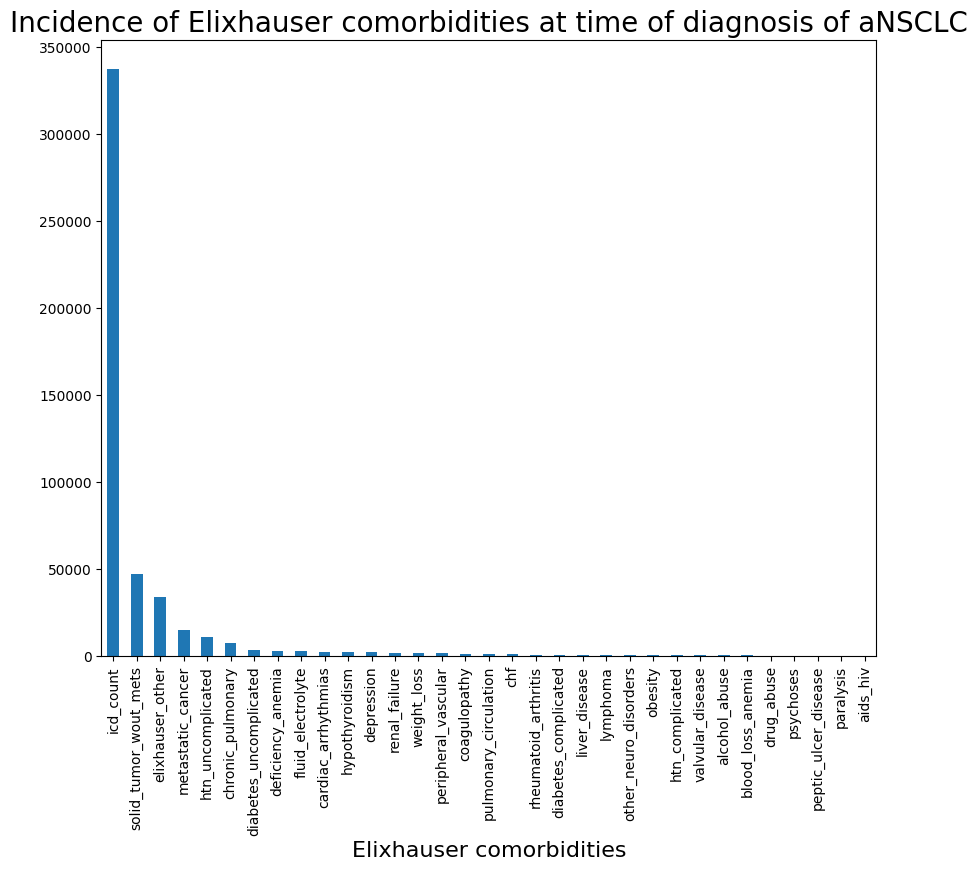

In [598]:
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:].sum(axis = 0).sort_values(ascending = False).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of diagnosis of aNSCLC', fontsize = 20)

Text(0.5, 1.0, 'Incidence of Elixhauser comorbidities at time of diagnosis of aNSCLC')

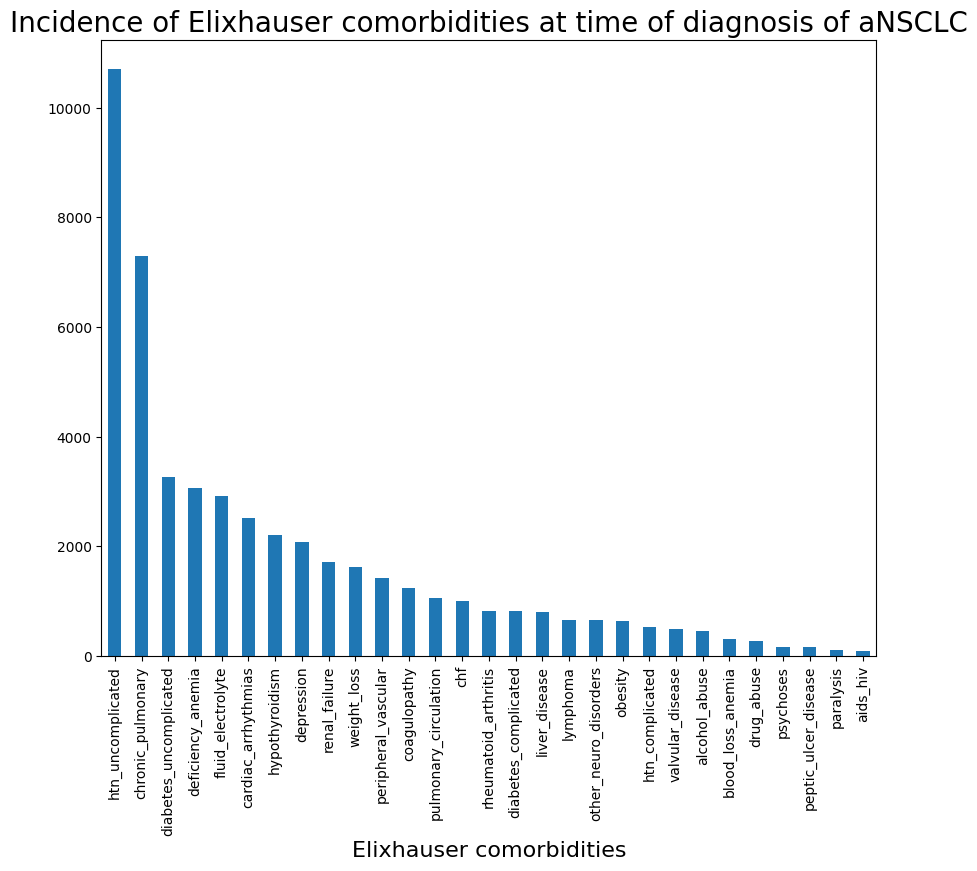

In [599]:
# Same plot as above but excluding tumor and mets.
%matplotlib inline
diagnosis_elixhauser.iloc[:, 1:].sum(axis = 0).sort_values(ascending = False).tail(29).plot(kind = 'bar', figsize = (10,8))
plt.xlabel('Elixhauser comorbidities', fontsize = 16)
plt.title('Incidence of Elixhauser comorbidities at time of diagnosis of aNSCLC', fontsize = 20)

In [600]:
# Append missing training IDs.
diagnosis_elixhauser = (
    diagnosis_elixhauser
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(diagnosis_elixhauser['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [601]:
row_ID(diagnosis_elixhauser)

(54786, 54786)

In [602]:
diagnosis_elixhauser.sample(5)

,PatientID,chf,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,htn_uncomplicated,htn_complicated,paralysis,other_neuro_disorders,...,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemia,alcohol_abuse,drug_abuse,psychoses,depression,elixhauser_other,icd_count
8996,F2F3C27DD4ED3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
45707,F6CCDC72D01BE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5992,F1F78ED85A15A,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
16994,F595E565618DA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18321,F60198903A7EF,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19.0


#### 10.2 Other cancer 

##### 10.2a ICD-9 cancer codes

In [603]:
# Select all ICD-9 cancer codes between 140-239 (excluding benign neoplasms: 210-229).
cancer_9 = (
    diagnosis_elix_9[diagnosis_elix_9['DiagnosisCode'].str.startswith(
        ('14','15', '16', '17', '18', '19', '20', '23'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [604]:
row_ID(cancer_9)

(33916, 22883)

**Remove the following ICD-9 codes representing lung cancer, metastasis, ill-defined neoplasms, and benign neoplasms of skin (BCC and SCC):**
* **162 - Malignant neoplasm of trachea, bronchus, and lung**
* **163 - Malignant neoplasm of pleura**
* **164.2 - Malignant neoplasm of anterior mediastinum**
* **164.3 - Malignant neoplasm of posterior mediastinum**
* **164.8 - Malignant neoplasm other parts of mediastinum**
* **164.9 - Malignant neoplasm of mediastinum, part unspecified** 
* **165 - Malignant neoplasm of other and ill-defined sites within respiratory system** 
* **173 - Other and unspecified malignant neoplasm of skin**
* **195.1 - Malignant neoplasm of thorax** 
* **196 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **197 - Secondary malignant neoplasm of respiratory and digestive systems**
* **198 - Secondary malignant neoplasm of other specified sites** 
* **199 - Malignant neoplasm without specification of site**
* **231.1 - Carcinoma in situ of trachea**
* **231.2 - Carcinoma in situ of bronchus and lung**
* **231.8 - Carcinoma in situ of other specified parts of respiratory system**
* **231.9 - Carcinoma in situ of respiratory system, part unspecified** 
* **235.7 - Neoplasm of uncertain behavior of trachea, bronchus, and lung**
* **235.8 - Neoplasm of uncertain behavior of pleura, thymus, and mediastinum**
* **235.9 - Neoplasm of uncertain behavior of other and unspecified respiratory organs**
* **238.8 - Neoplasm of uncertain behavior of other specified sites**
* **238.9 - Neoplasm of uncertain behavior, site unspecified**
* **239 - Neoplasms of unspecified nature**

In [605]:
# Count ICD-9 neoplasm codes that represent lung cancer or metastasis.
(
    cancer_9[cancer_9['diagnosis_code'].str.match('16([23]|4[2389]|5)|'
                                                  '173|'
                                                  '19(51|[6789])|'
                                                  '23(1[1289]|5[789]|8[89]|9)')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

162.9    0.266799
162.3    0.260049
162.5    0.127197
198.5    0.085701
162.8    0.053970
198.3    0.046123
162.4    0.030908
197.7    0.016825
162.2    0.015454
197.0    0.014940
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 codes for lung cancer and metastasis are:** 
* **162.9 - Bronchus and lung, unspecified**
* **162.3 - Upper lobe, bronchus or lung**
* **162.5 - Lower lobe, bronchus or lung**
* **198.5 - Secondary malignant neoplasm of bone and bone marrow**
* **162.8 - Other parts of bronchus or lung**
* **198.3 - Secondary malignant neoplasm of brain and spinal cord**
* **162.4 - Middle lobe, bronchus or lung**
* **197.7 - Malignant neoplasm of liver, secondary**
* **162.2 - Main bronchus**
* **197.0 - Secondary malignant neoplasm of lung** 

In [606]:
# Dataframe of ICD-9 neoplasm codes that exclude lung cancer, metastasis, or benign neoplasms.
other_cancer_9 = (
    cancer_9[~cancer_9['diagnosis_code'].str.match('16([23]|4[2389]|5)|'
                                                   '173|'
                                                   '19(51|[6789])|'
                                                   '23(1[1289]|5[789]|8[89]|9)')]
)

In [607]:
other_cancer_9.DiagnosisCode.value_counts(normalize = True).head(10)

174.9     0.113247
185       0.099091
174.4     0.050074
204.10    0.035073
153.9     0.027678
188.9     0.027044
189.0     0.020917
233.0     0.020706
174.8     0.019015
154.1     0.015212
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 codes at time of diagnosis that aren't lung cancer, metastasis, or benign neoplasm:**
* **174.9 - Malignant neoplasm of breast (female), unspecified**
* **185 - Malignant neoplasm of prostate**
* **174.4 - Malignant neoplasm of upper-outer quadrant of female breast**
* **204.10 - Chronic lymphoid leukemia, without mention of having achieved remission**
* **188.9 - Malignant neoplasm of bladder, part unspecified**
* **153.9 - Malignant neoplasm of colon, unspecified site**
* **189.0 - Malignant neoplasm of kidney, except pelvis**
* **233 - Carcinoma in situ of breast and genitourinary system**
* **174.8 - Malignant neoplasm of other specified sites of female breast** 
* **202.80 - Other malignant lymphomas, unspecified site, extranodal and solid organ site**

In [608]:
other_cancer_9.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

174    0.228185
185    0.099091
153    0.067188
238    0.064652
202    0.054511
188    0.041623
204    0.040566
189    0.027467
154    0.027044
172    0.026410
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-9 family codes at time of diagnosis that aren't lung cancer, metastasis, or benign neoplasm:**
* **174 - Malignant neoplasm of female breast**
* **185 - Malignant neoplasm of prostate**
* **153 - Malignant neoplasm of colon**
* **238 - Neoplasm of uncertain behavior of other and unspecified sites and tissues**
* **202 - Other malignant neoplasms of lymphoid and histiocytic tissue**
* **204 - Lymphoid leukemia**
* **188 - Malignant neoplasm of bladder**
* **172 - Malignant melanoma of skin**
* **189 - Malignant neoplasm of kidney and other and unspecified urinary organs**
* **154 - Malignant neoplasm of rectum rectosigmoid junction and anus**

In [609]:
other_cancer_9.loc[:,'other_cancer_9'] = 1

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [610]:
other_cancer_9 = (
    other_cancer_9
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_9'])
)

In [611]:
row_ID(other_cancer_9)

(3946, 3946)

In [612]:
other_cancer_9 = (
    other_cancer_9
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_9['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [613]:
row_ID(other_cancer_9)

(54786, 54786)

##### 10.2b ICD-10 cancer codes

In [614]:
# Select all ICD-10 codes between C00-D49 (excluding benign neoplasms: D10-D36 and benign neuroendocrine tumor: D3A) reflecting neoplasm diagnosis.
cancer_10 = (
    diagnosis_elix_10[diagnosis_elix_10['DiagnosisCode'].str.startswith(
        ('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'D0', 'D37', 'D38', 'D39', 'D4'))]
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [615]:
row_ID(cancer_10)

(50190, 28413)

**Remove the following ICD-10 codes which capture lung cancer, metastasis, and benign skin neoplasms(eg., BCC and SCC).**
* **C33 - Malignant neoplasm of trachea**
* **C34 - Malignant neoplasm of bronchus and lung**
* **C38.1 - Malignant neoplasm of anterior mediastinum**
* **C38.2 - Malignant neoplasm of posterior mediastinum**
* **C38.3 - Malignant neoplasm of mediastinum, part unspecified**
* **C38.4 - Malignant neoplasm of pleura**
* **C38.8 - Malignant neoplasm of overlapping sites of heart, mediastinum and pleura**
* **C39 - Malignant neoplasm of other and ill-defined sites in the respiratory system and intrathoracic organs**
* **C44 - Other and unspecified malignant neoplasm of skin**
* **C76.1 -  Malignant neoplasm of other and ill-defined sites: malignant neoplasm of thorax**
* **C77 - Secondary and unspecified malignant neoplasm of lymph nodes**
* **C78 - Secondary malignant neoplasm of respiratory and digestive organs**
* **C79 - Secondary malignant neoplasm of other and unspecified sites**
* **C80 - Malignant neoplasm without specification of site**
* **D02.1 - Carcinoma in situ of trachea**
* **D02.2 - Carcinoma in situ of bronchus and lung**
* **D02.3 - Carcinoma in situ of other parts of respiratory system**
* **D02.4 - Carcinoma in situ of respiratory system, unspecified**
* **D38 - Neoplasm of uncertain behavior of middle ear and respiratory and intrathoracic organs**
* **D47.2 - Monoclonal gammopathy**
* **D49 - Neoplasms of unspecified behavior** 

In [616]:
# Count of top 10 ICD-10 codes that represent lung cancer or metastasis. 
(
    cancer_10[cancer_10['diagnosis_code'].str.match('C3([34]|8[12348]|9)|'
                                                    'C44|'
                                                    'C7(61|[789])|'
                                                    'C80|'
                                                    'D(02[1234]|38|472|49)')]
    .DiagnosisCode
    .value_counts(normalize = True)
    .head(10)
)

C34.11    0.140178
C34.12    0.106820
C79.51    0.092600
C34.90    0.090968
C34.31    0.072967
C79.31    0.060724
C34.32    0.058297
C34.91    0.038084
C34.92    0.025905
C78.7     0.024638
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 codes at time of diagnosis that represent lung cancer, metastases, ill-defined neoplasm, or benign neoplasm:**
* **C34.11 - Malignant neoplasm of upper lobe, right bronchus or lung**
* **C34.12 - Malignant neoplasm of upper lobe, left bronchus or lung**
* **C79.51 - Secondary malignant neoplasm of bone**
* **C34.90 - Malignant neoplasm of unspecified part of unspecified bronchus or lung**
* **C34.31 - Malignant neoplasm of lower lobe, right bronchus or lung**
* **C79.31 - Secondary malignant neoplasm of brain**
* **C34.32 - Malignant neoplasm of lower lobe, left bronchus or lung**
* **C34.91 - Malignant neoplasm of unspecified part of right bronchus or lung**
* **C78.7 - Secondary malignant neoplasm of liver and intrahepatic bile duct**
* **C34.92 - Malignant neoplasm of unspecified part of left bronchus or lung**

In [617]:
# Dataframe of ICD-10 neoplasm codes that exclude lung cancer, metastasis, or benign neoplasms.
other_cancer_10 = (
    cancer_10[~cancer_10['diagnosis_code'].str.match('C3([34]|8[12348]|9)|'
                                                     'C44|'
                                                     'C7(61|[789])|'
                                                     'C80|'
                                                     'D(02[1234]|38|472|49)')]
)

In [618]:
other_cancer_10.DiagnosisCode.value_counts(normalize = True).head(10)

C61        0.087758
D47.3      0.040165
C67.9      0.029711
D48.5      0.027235
C50.919    0.022283
C71.9      0.020083
C18.9      0.018707
C50.912    0.018432
C91.10     0.018432
C50.911    0.018157
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 codes at time of diagnosis that aren't lung cancer, metastasis, or benign neoplasm:**
* **C61 - Malignant neoplasm of prostate**
* **D47.3 - Essential (hemorrhagic) thrombocythemia**
* **C67.9 - Malignant neoplasm of bladder, unspecified**
* **D48.5 - Neoplasm of uncertain behavior of skin**
* **C50.919 - Malignant neoplasm of unspecified site of unspecified female breast**
* **C71.9 - Malignant neoplasm of brain, unspecified**
* **C91.10 - Chronic lymphocytic leukemia of B-cell type**
* **C50.912 - Malignant neoplasm of unspecified site of left female breast**
* **C50.911 - Malignant neoplasm of unspecified site of right female breast**
* **C18.9 - Malignant neoplasm of colon, unspecified**

In [619]:
other_cancer_10.DiagnosisCode.str[0:3].value_counts(normalize = True).head(10)

C50    0.134250
C61    0.087758
C67    0.049519
D48    0.047868
D47    0.047043
C18    0.047043
C71    0.031087
C85    0.028061
C43    0.027235
C91    0.025034
Name: DiagnosisCode, dtype: float64

**The top 10 ICD-10 family codes at time of diagnosis that aren't lung cancer, metastasis, or benign neoplasm:**
* **C50 - Malignant neoplasm of breast**
* **C61 - Malignant neoplasm of prostate**
* **D47 - Other neoplasms of uncertain behavior of lymphoid, hematopoietic and related tissue**
* **C18 - Malignant neoplasm of colon**
* **D48 - Neoplasm of uncertain behavior of other and unspecified sites**
* **C67 - Malignant neoplasm of bladder**
* **C71 - Malignant neoplasm of brain**
* **C91 - Lymphoid leukemia**
* **C85 - Other specified and unspecified types of non-Hodgkin lymphoma**
* **C43 - Malignant melanoma of skin**

In [620]:
other_cancer_10.loc[:,'other_cancer_10'] = 1

In [621]:
# Drop duplicates.
other_cancer_10 = (
    other_cancer_10
    .drop_duplicates(subset = 'PatientID', keep = 'first')
    .filter(items = ['PatientID', 'other_cancer_10'])
)

In [622]:
row_ID(other_cancer_10)

(2816, 2816)

In [623]:
# Append missing training IDs.
other_cancer_10 = (
    other_cancer_10
    .append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(other_cancer_10['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [624]:
row_ID(other_cancer_10)

(54786, 54786)

In [625]:
other_cancer = pd.merge(other_cancer_9, other_cancer_10, on = 'PatientID')

In [626]:
# Combine other_cancer_9 and other_cancer_19; replace values equal to 2 with 1. 
other_cancer = (
    other_cancer
    .assign(other_cancer = other_cancer['other_cancer_9'] + other_cancer['other_cancer_10'])
    .filter(items = ['PatientID', 'other_cancer'])
    .replace(2, 1)
)

In [627]:
row_ID(other_cancer)

(54786, 54786)

In [628]:
# Percentage of patients with a cancer other than lung or mets in the training set. 
len(other_cancer[other_cancer['other_cancer'] == 1])/len(other_cancer)

0.1150841455846384

#### 10.3 Sites of metastases at diagnosis

##### 10.3a ICD-9 sites of metastases

In [629]:
# Create dataframe contianing patients with ICD-9 codes within -90 to +30 days from advanced diagnosis and remove duplicate codes.(
diagnosis_mets_9 = (
    diagnosis
    .query('diagnosis_date_diff >= -90 and diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = ['PatientID', 'DiagnosisCode'], keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

**Sites of metastasis will be grouped into the following categories according to ICD-9 codes:**
* **CNS - 198.3 and 198.4**
* **Bone - 198.5**
* **Liver - 197.7**
* **Respiratory system - 197.0, 197.1, 197.2, and 197.3**
* **Adrenal gland - 198.7**
* **Other - kidney/bladder (198.0 and 198.1), intestines (197.4 and 197.5), lymph nodes (196), other (197.6, 197.8, 198.2, 198.6, and 198.8)**

In [630]:
diagnosis_mets_9['cns_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('198[34]'), 1, 0)

In [631]:
diagnosis_mets_9['bone_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1985'), 1, 0)

In [632]:
diagnosis_mets_9['liver_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1977'), 1, 0)

In [633]:
diagnosis_mets_9['resp_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('197[0123]'), 1, 0)

In [634]:
diagnosis_mets_9['adrenal_met'] = np.where(diagnosis_mets_9['diagnosis_code'].str.match('1987'), 1, 0)

In [635]:
diagnosis_mets_9['other_met'] = (
    np.where(diagnosis_mets_9['diagnosis_code'].str.match('196|'
                                                          '197[4568]|'
                                                          '198[01268]'), 1, 0)
)

In [636]:
# Collapse columns and sum.
diagnosis_mets_9 = (
    diagnosis_mets_9
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

##### 10.3b ICD-10 sites of metastases

In [637]:
# Create dataframe contianing patients with ICD-10 codes within -90 to +30 days from advanced diagnosis and remove duplicate codes.
diagnosis_mets_10 = (
    diagnosis
    .query('diagnosis_date_diff >= -90 and diagnosis_date_diff <= 30')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = ['PatientID', 'DiagnosisCode'], keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

**Sites of metastasis will be grouped into the following categories according to ICD-10 codes:**
* **CNS - C79.3 and C79.4**
* **Bone - C79.5**
* **Liver - C78.7**
* **Respiratory system - C78.0, C78.1, C78.2, and C78.3**
* **Adrenal gland - C79.7**
* **Other - kidney/bladder (C79.0 and C79.1) intestines (C78.4 and C78.5), lymph nodes (C77), and other (C78.6, C78.8, C79.2, C79.6, C79.8, C79.9)**

In [638]:
diagnosis_mets_10['cns_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C79[34]'), 1, 0)

In [639]:
diagnosis_mets_10['bone_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C795'), 1, 0)

In [640]:
diagnosis_mets_10['liver_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C787'), 1, 0)

In [641]:
diagnosis_mets_10['resp_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C78[0123]'), 1, 0)

In [642]:
diagnosis_mets_10['adrenal_met'] = np.where(diagnosis_mets_10['diagnosis_code'].str.match('C797'), 1, 0)

In [643]:
diagnosis_mets_10['other_met'] = (
    np.where(diagnosis_mets_10['diagnosis_code'].str.match('C77|'
                                                           'C78[4568]|'
                                                           'C79[012689]'), 1, 0)
)

In [644]:
# Collapse columns and sum. 
diagnosis_mets_10 = (
    diagnosis_mets_10
    .drop(columns = ['DiagnosisCode', 'diagnosis_code'])
    .groupby('PatientID').sum()
    .reset_index()
)

In [645]:
# Merge ICD-9 and ICD-10 mets tables; collapse and sum. 
diagnosis_mets = (
    pd.concat([diagnosis_mets_9, diagnosis_mets_10])
    .groupby('PatientID').sum()
)

In [646]:
# All values >1 replaced by 1. 
diagnosis_mets = (
    diagnosis_mets.mask(diagnosis_mets > 1, 1)
    .reset_index()
)

In [647]:
# Append missing training IDs.
diagnosis_mets = (
    diagnosis_mets.append(
        pd.Series(train_IDs)[~pd.Series(train_IDs).isin(diagnosis_mets['PatientID'])].to_frame(name = 'PatientID'), 
        sort = False)
    .fillna(0)
)

In [648]:
row_ID(diagnosis_mets)

(54786, 54786)

In [649]:
# Percentage with mets by site of location at time of advacned diagnosis
(diagnosis_mets.iloc[:, 1:].sum()/len(diagnosis_mets)).sort_values(ascending = False)

bone_met       0.119830
cns_met        0.075019
other_met      0.052586
resp_met       0.032746
liver_met      0.028693
adrenal_met    0.014602
dtype: float64

In [650]:
# Percentage of patiens with ICD code denoting mets at time of advanced diagnosis. 
len(diagnosis_mets[diagnosis_mets.eq(1).any(1)])/len(diagnosis_mets)

0.2463220530792538

In [651]:
diagnosis_mets.sample(5)

,PatientID,cns_met,bone_met,liver_met,resp_met,adrenal_met,other_met
29743,FB538BC25BCCF,0.0,0.0,0.0,0.0,0.0,0.0
4421,F1B149C45687D,0.0,0.0,0.0,0.0,0.0,0.0
35249,F4D77928186AA,0.0,0.0,0.0,0.0,0.0,0.0
19883,F79CDCDD8F5D0,0.0,0.0,0.0,0.0,0.0,0.0
36865,FE0394B2E29B5,0.0,0.0,0.0,0.0,0.0,0.0


**Site of metastasis at time of advanced diagnosis gives unexpecedly low results suggesting that ICD codes are most likley poorly documented by providers.**   

#### 10.4 Merge

In [652]:
diagnosis_wide = pd.merge(diagnosis_elixhauser, other_cancer, on = 'PatientID')

In [653]:
diagnosis_wide = pd.merge(diagnosis_wide, diagnosis_mets, on = 'PatientID')

In [654]:
row_ID(diagnosis_wide)

(54786, 54786)

In [655]:
list(diagnosis_wide.columns)

['PatientID',
 'chf',
 'cardiac_arrhythmias',
 'valvular_disease',
 'pulmonary_circulation',
 'peripheral_vascular',
 'htn_uncomplicated',
 'htn_complicated',
 'paralysis',
 'other_neuro_disorders',
 'chronic_pulmonary',
 'diabetes_uncomplicated',
 'diabetes_complicated',
 'hypothyroidism',
 'renal_failure',
 'liver_disease',
 'peptic_ulcer_disease',
 'aids_hiv',
 'lymphoma',
 'metastatic_cancer',
 'solid_tumor_wout_mets',
 'rheumatoid_arthritis',
 'coagulopathy',
 'obesity',
 'weight_loss',
 'fluid_electrolyte',
 'blood_loss_anemia',
 'deficiency_anemia',
 'alcohol_abuse',
 'drug_abuse',
 'psychoses',
 'depression',
 'elixhauser_other',
 'icd_count',
 'other_cancer',
 'cns_met',
 'bone_met',
 'liver_met',
 'resp_met',
 'adrenal_met',
 'other_met']

In [656]:
%whos DataFrame

Variable                 Type         Data/Info
-----------------------------------------------
biomarker_wide           DataFrame               PatientID     <...>n[54786 rows x 8 columns]
cancer_10                DataFrame                 PatientID Di<...>n[50190 rows x 3 columns]
cancer_9                 DataFrame                 PatientID Di<...>n[33916 rows x 3 columns]
demographics             DataFrame               PatientID Prac<...>n[54786 rows x 7 columns]
diagnosis                DataFrame                 PatientID Di<...>1209131 rows x 8 columns]
diagnosis_elix_10        DataFrame                 PatientID Di<...>221151 rows x 35 columns]
diagnosis_elix_10_wide   DataFrame               PatientID  chf<...>[30508 rows x 33 columns]
diagnosis_elix_9         DataFrame                 PatientID Di<...>115721 rows x 35 columns]
diagnosis_elix_9_wide    DataFrame               PatientID  chf<...>[25868 rows x 33 columns]
diagnosis_elixhauser     DataFrame               PatientID

In [657]:
# Keep diagnosis_wide.
del cancer_10
del cancer_9
del diagnosis
del diagnosis_elix_10
del diagnosis_elix_10_wide
del diagnosis_elix_9
del diagnosis_elix_9_wide
del diagnosis_elixhauser
del diagnosis_mets
del diagnosis_mets_10
del diagnosis_mets_9
del other_cancer
del other_cancer_10
del other_cancer_9

## Merge files to create master training dataframe

In [658]:
enhanced_adv = enhanced_adv.drop(columns = ['diagnosis_date', 'adv_date', 'adv_year_cat'])

In [659]:
train_full = pd.merge(demographics, enhanced_adv, on = 'PatientID')

In [660]:
train_full = pd.merge(train_full, mortality, on = 'PatientID')

In [661]:
train_full = pd.merge(train_full, med_admin_wide, on = 'PatientID')

In [662]:
train_full = pd.merge(train_full, biomarker_wide, on = 'PatientID')

In [663]:
train_full = pd.merge(train_full, insurance_wide, on = 'PatientID')

In [664]:
train_full = pd.merge(train_full, ecog_diagnosis_wide, on = 'PatientID')

In [665]:
train_full = pd.merge(train_full, weight_wide, on = 'PatientID')

In [666]:
train_full = pd.merge(train_full, lab_wide, on = 'PatientID')

In [667]:
train_full = pd.merge(train_full, diagnosis_wide, on = 'PatientID')

In [668]:
row_ID(train_full)

(54786, 54786)

In [669]:
len(train_full.columns)

213

In [670]:
list(train_full.columns)

['PatientID',
 'PracticeType',
 'gender',
 'race',
 'ethnicity',
 'age',
 'region',
 'Histology',
 'SmokingStatus',
 'stage',
 'adv_year',
 'delta_adv_diagnosis',
 'death_status',
 'timerisk_activity',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'is_diag',
 'ALK',
 'BRAF',
 'EGFR',
 'KRAS',
 'ROS1',
 'pdl1',
 'pdl1_n',
 'commercial',
 'medicare',
 'medicaid',
 'other_insurance',
 'ecog_diagnosis',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na

In [671]:
train_full.to_csv('train_full.csv', index = False, header = True)